# SEISMO-VRE for a multiparametric and multidisciplinary analysis of an earthquake  
Except where otherwise noted, this Jupyter Notebook is made available under the GPL-3.0 license. For details, please see the `LICENSE` file in the main directory.
# MATLAB Version
## MINI ABSTRACT  

The study presents the development of a Virtual Research Environment (VRE) for analysing an earthquake using a multiparametric and multidisciplinary approach. The case study of the 2016-2017 Amatrice-Norcia (Italy) seismic sequence was selected as an example. Implemented through Jupyter Notebooks, the VRE enables researchers to reproduce analyses, modify parameters, and visualise results interactively. It leverages the European Plate Observing System (EPOS) platform, which integrates diverse geophysical datasets. The system accesses earthquake data via EPOS APIs and could potentially be deployed as software within the EPOS portal in the future.

## IMPLEMENTATION OVERVIEW
### Data 
The VRE at this preliminary stage of implementation uses:
1. **[Lithosphere](#Lithospheric-analysis):** earthquake catalogue retrieved by EPOS; [GNSS station positions retrieved by EPOS](#Analysis-of-vatiations-of-plates-movements-from-EPOS-GNSS-Positions); [Geomagnetic ground observatories](#Geomagnetic-ground-observatories); 
2. **[Atmosphere](#Atmospheric-analysis):** Climatological measurements from the MERRA-2 archive by NASA (parameters: SO_2, dimethyl sulphide, aerosol optical thickness, CO, Surface Air Temperature, relative humidity, Surface Latent Heat Flux, Total Precipitation);
3. **[Ionosphere](#Ionospheric-analysis):**  Swarm three identical satellite magnetic data 

### Analyses workflow 
1. Lithospheric analysis  
2. [Atmospheric analysis](#Atmospheric-analysis)
3. Ionospheric analysis
4. [Comparison of the three Geo-layers](#Comparison-of-Lithosphere-Atmosphere-and-Ionosphere-analyses).

### Reconfigurable parameters
The VRE is reconfigurable for another target earthquake (possible limitation for events close to -180 or +180 longitude) changing:
1. **Earthquake origin time:** EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second;
2. **earthquake magnitude:** EQ_mag;
3. **Epicentral coordinates:** epilat, epilon.
4. **Hypocentral depth:** EQ_depth
5. **Fault strike:** Fault_strike (this is the angle of orientation of the fault determined from one of the two nodal planes 
It's also possible to change the time to be analysed before and after the target earthquake (in days):
5. **day before the earthquake:** day_before;
6. **day after the earthquake:** day_after

In [1]:
% Global variables initialization

% Earthquake origin time
EQ_year = 2016; EQ_month=8; EQ_day=24; EQ_hour=1; EQ_minute=36; EQ_second = 32;
%Epicenter latitude and longitude
epilat = 42.6980; epilon = 13.2340;
%Mainshock magnitude
EQ_mag = 6.5;
EQ_depth = 10;
Fault_strike = 153; %Here is inserted a mean strike of the two main faults: Amatrice 155 and Norcia 151
%This strike must be a positive value
day_before = 8*30;
day_after = 0;

# Lithospheric analysis 
## step 1
1. Lithospheric analysis
1.1  
we retrieve the seismic catalogue to study the Lithosphere from the EPOS Platform

In [2]:
format compact

% Calculus of the origin time of the earthquake
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
%Calculus of time span for analysis
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
%Calculus of the research region border for this study
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky - 5;
max_lat = epilat + radius_Dobrovolsky + 5;
min_lon = epilon - radius_Dobrovolsky - 5;
max_lon = epilon + radius_Dobrovolsky + 5;
%Minimun magnitude to be retrieved by the catalogue
EQ_min_mag= 1.0;

%Cycle to retrieve the earthquake catalogue data from EPOS (EMSC).
EQ = [];
for time_tba = time_start:time_end-1
    time_tba_end = time_tba + (23+59/60.0+59/3600.0)/24;
    weburl_to_retrive_the_data = ['https://www.seismicportal.eu/fdsnws/event/1/query?starttime=', datestr(time_tba, 'yyyy-mm-dd'), 'T',  datestr(time_tba, 'HH'),':', datestr(time_tba, 'MM'), ':', datestr(time_tba, 'SS'),'Z&endtime=', datestr(time_tba_end, 'yyyy-mm-dd'), 'T', datestr(time_tba_end, 'HH'),':', datestr(time_tba_end, 'MM'), ':', datestr(time_tba_end, 'SS'), 'Z&minmagnitude=', num2str(EQ_min_mag, '%.1f'), '&minlatitude=', num2str(min_lat, '%.4f'), '&maxlatitude=', num2str(max_lat, '%.4f'), '&minlongitude=', num2str(min_lon, '%.4f'), '&maxlongitude=', num2str(max_lon, '%.4f'), '&includeallorigins=false&includearrivals=false&limit=480&format=json&nodata=204'];%'&preferredOnly=true&format=text&limit=2500'];
    EQ_p = webread(weburl_to_retrive_the_data);
    EQ = [EQ; EQ_p];
end
disp(EQ)


  240x1 struct array with fields:
    type
    metadata
    features


The following part, convert the earthquake catalogue in an array with the ZMap (Wiemer, 2001) standard, that  is:
longitude | latitude | year | month | day | magnitude | depth | hour | minute | second

<b> References: </b>
Wiemer, S. A Software Package to Analyze Seismicity: ZMAP. Seismological Research Letters 2001, 72, 373–382, doi:10.1785/gssrl.72.3.373.



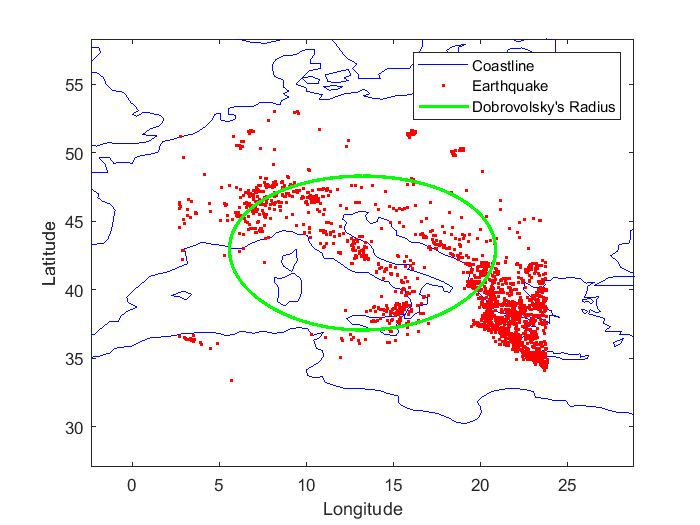

In [4]:
format compact

% The retrieved data are divided into packages. The number of them is provided as an output in the previous cell. 
% The following cycle, unwrap the packages of data retrieved from each request in an array, assuring that each row corresponds to a single earthquake event. 
k=1;
EQ_new = nan(size(EQ,1)*3,10);
for i = 1:size(EQ,1)
    EQ_temp = EQ(i).features;
    for j = 1:size(EQ_temp,1)
        hypocenter = EQ_temp(j).geometry.coordinates;
        EQ_magnitude = EQ_temp(j).properties.mag;
        EQ_origin_time = EQ_temp(j).properties.time;
        EQ_origin_time_1 = datetime([EQ_origin_time(1:10), ' ', EQ_origin_time(12:21)]);
        EQ_origin_time_vector = datevec(EQ_origin_time_1);
        EQ_new(k,:) = [hypocenter(1:2)', EQ_origin_time_vector(1:3), EQ_magnitude, -hypocenter(3), EQ_origin_time_vector(4:6)];
        k = k + 1;
    end
end
EQ_new = EQ_new(1:k-1,:);

%Creation of the map with all the retrieved events and the circle of Dobrovolsky's area to sub-select the new sub-catalog selection
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(EQ_new(:,1), EQ_new(:,2), '.r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', ['Dobrovolsky', 39, 's Radius']);

# Selection of earthquakes of interest
In the following lines, only the most interesting earthquakes are selected. In fact, we will consider a circular area defined by Dobrovolsky's Radius (km) = $10^{0.43 \times MAG}$ (Dobrovolsky et al., 1979). This is one of the possible areas that define the preparation of an earthquake, but it's widely used, and it corresponds to the distance where the seismic shaking is equal to the terrestrial tidal deformation.

In addition, we need to select only the earthquakes with a magnitude equal to or greater than the completeness magnitude of the earthquake catalogue.  
Last but not least, a selection of shallow earthquakes can be applied as deeper events are unlikely related to the interactions with the atmosphere and ionosphere. 

<b> References: </b>  
Dobrovolsky, I.P.; Zubkov, S.I.; Miachkin, V.I. Estimation of the Size of Earthquake Preparation Zones. PAGEOPH 1979, 117, 1025–1044, doi:10.1007/BF00876083.


In [5]:
%Calculus of the distance of each earthquake from the target event.
distance_from_target_EQ = distance(epilat, epilon, EQ_new(:,2), EQ_new(:,1));
%sub-selection of  events from the retrieved earthquake catalogue inside the green circle.
EQ_sel = EQ_new(distance_from_target_EQ <= radius_Dobrovolsky, :);
distance_from_target_EQ = distance_from_target_EQ(distance_from_target_EQ <= radius_Dobrovolsky);

Completeness_magnitude = 2.0; % From ZMap using Max curvature criterium
%in a future update, the MC can be calculated inside the VRE
%sub-selection of  events from the previous selection with magnitude equal or greater than MC.
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,6) >= Completeness_magnitude);
EQ_sel = EQ_sel(EQ_sel(:,6) >= Completeness_magnitude, :);

max_depth = 50;
%sub-selection of  events from the previous selection with depth minor or equal to the max_depth.
distance_from_target_EQ = distance_from_target_EQ(EQ_sel(:,7) <= max_depth);
EQ_sel = EQ_sel(EQ_sel(:,7) <= max_depth, :);

%Ordering all the events for their origin time (i.e., chronologically)
EQ_sel = sortrows(EQ_sel, [3,4,5,8,9,10]);

%show the final number of earthquakes in the selection for further analyses.
size(EQ_sel,1)

ans = 591

# Calculus of Cumulative Benioff Strain   
The Benioff cumulative strain is computed according to the original formulation of Benioff:  
$S(t) = \sum_{i}^{N}{\sqrt{E_i}}$  
where S is the Benioff Strain at time t and E_i is the earthquake energy calculated with the Richter equation:  
$E_i(J) = 10^{(1.5 \cdot M_i + 4.8)}$  
where M is the magnitude of the event i

<b> Reference: </b>  
Benioff, H. Global Strain Accumulation and Release as Revealed by Great Earthquakes. GSA Bulletin 1951, 62, 331–338, doi:10.1130/0016-7606(1951)62[331:GSAARA]2.0.CO;2.


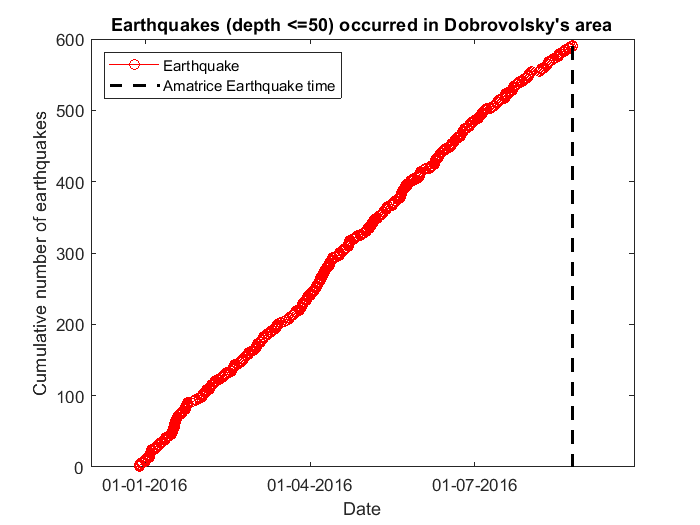

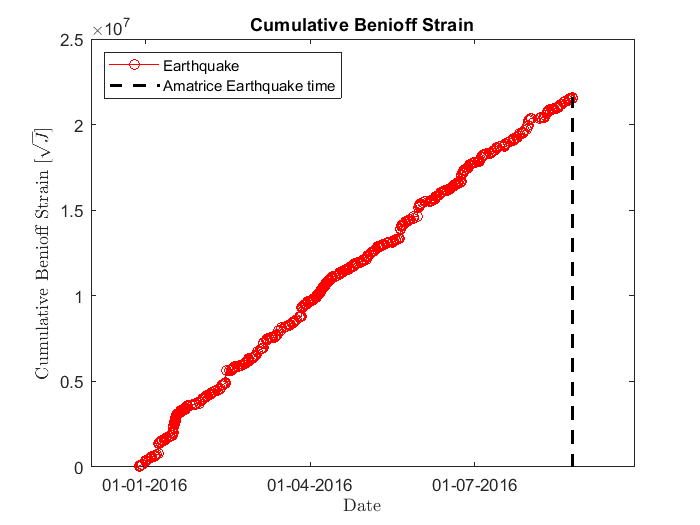

In [6]:
%Calculus of a vector that increases by one for each event.
cumulative_number = (1:size(EQ_sel,1))';
time_EQ_sel = datenum([EQ_sel(:,3:5), EQ_sel(:,8:10)]); 

%plot of the cumulative number of earthquakes over time.
figure;
plot(time_EQ_sel, cumulative_number, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_number(end)+1], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date')
ylabel('Cumulative number of earthquakes');
title(['Earthquakes (depth <=', num2str(max_depth), ') occurred in Dobrovolsky', 39, 's area']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')

%Calculus of Richter earthquake energy released for each event in Joules
EQ_energy = 10.^(1.5*EQ_sel(:,6)+4.8);

%Calculus of the square root of earthquake energy for each event
EQ_sqrt_energy = nan(size(EQ_sel,1),1);
%Calculus of cumulative Benioff Strain as the sum of the square root of energy calculated above.
EQ_sqrt_energy(1,1) = sqrt(EQ_energy(1));
for i=2:size(EQ_sel, 1)
EQ_sqrt_energy(i,1) = EQ_sqrt_energy(i-1,1) + sqrt(EQ_energy(i));
end

%plot of the square root of the energy
figure;
plot(time_EQ_sel, EQ_sqrt_energy, '-or');
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative Benioff Strain [$\sqrt{J}$]', 'Interpreter', 'latex');
title(['Cumulative Benioff Strain']);
legend('Earthquake', 'Amatrice Earthquake time', 'Location', 'NorthWest')



# Earthquake released energy as a function of the distance to the target earthquake
In the following, the earthquake released energy is weighted with the square distance to the incoming earthquake, according to the parameter $E_S$ introduced by prof. Katsumi Hattori (e.g., Hattori et al., 2013):  
$E_S = \sum_i{E_i \over r^2}$  
The parameter $E_S$ is calculated on all i-th events occurred in a single day.  
The concept is that an earthquake that happened closer to the future larger target is more important than one which is far.

<b> References: </b>  
Hattori, K.; Han, P.; Yoshino, C.; Febriani, F.; Yamaguchi, H.; Chen, C.-H. Investigation of ULF Seismo-Magnetic Phenomena in Kanto, Japan During 2000–2010: Case Studies and Statistical Studies. Surv Geophys 2013, 34, 293–316, doi:10.1007/s10712-012-9215-x.


number_of_analysed_days = 241

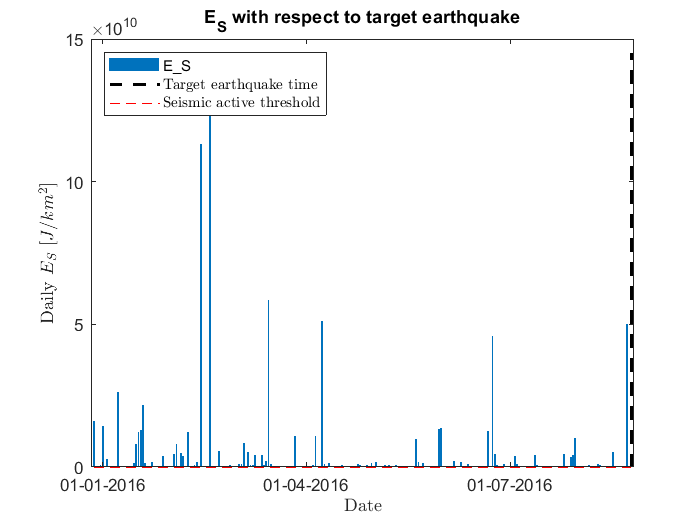

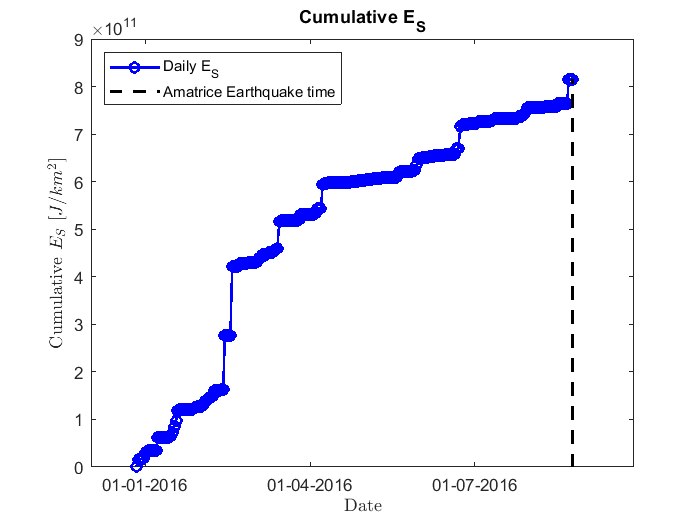

In [7]:
% Calculus of the Energy released by each earthquake divided by the square distance of the target event.
EQ_energy_for_ES = EQ_energy ./ (distance_from_target_EQ.^2);

% Calculus of daily Energy ES. At this purpose, the time span is firstly selected and then sum the energy ES for each event day-by-day
day_start = fix(time_start);
day_end = fix(time_end);
number_of_analysed_days = day_end - day_start + 1
% Creation of vector with daily energy ES basically equal to zero.
ES_Daily = zeros(number_of_analysed_days, 2);
% Calculus of actual daily energy ES.
k = 1;
for day_to_analysed = day_start:day_end
    [year_tba, month_tba, day_tba] = datevec(day_to_analysed);
    ES_Daily(k, :) = [day_to_analysed, sum(EQ_energy_for_ES(EQ_sel(:,3) == year_tba & EQ_sel(:,4) == month_tba & EQ_sel(:,5) == day_tba))];
    k = k + 1;
end

% plot of daily energy ES
figure;
bar(ES_Daily(:,1), ES_Daily(:,2));
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 max(ES_Daily(:,2))], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
line([day_start, day_end], [1e8, 1e8], 'LineStyle', '--', 'LineWidth', 1, 'Color', 'r');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Daily $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['E_S with respect to target earthquake']);
legend('E_S', 'Target earthquake time', 'Seismic active threshold', 'Location', 'NorthWest', 'Interpreter', 'latex')

% Calculus of cumulative ES over time
cumulative_ES = zeros(size(ES_Daily,1)+1,2);
cumulative_ES(1,1) = day_start - 1;
k = 2;
for i = 1:size(ES_Daily, 1)
    cumulative_ES(k,:) = [ES_Daily(i,1), cumulative_ES(k-1, 2)+ES_Daily(i,2)];
    k = k + 1;
end

% Plot of the cumulative ES over time
figure
plot(cumulative_ES(:,1), cumulative_ES(:,2), '-ob', 'Linewidth', 1.5);
datetick('x', 'dd-mm-yyyy', 'keeplimits');
line([EQ_time, EQ_time], [0 cumulative_ES(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Date', 'Interpreter', 'latex')
ylabel('Cumulative $E_S$ [$J/km^2$]', 'Interpreter', 'latex');
title(['Cumulative E_S']);
legend('Daily E_S', 'Amatrice Earthquake time', 'Location', 'NorthWest')

# Analysis of vatiations of plates movements from EPOS GNSS Positions 

number_of_GNSS_stations = 304

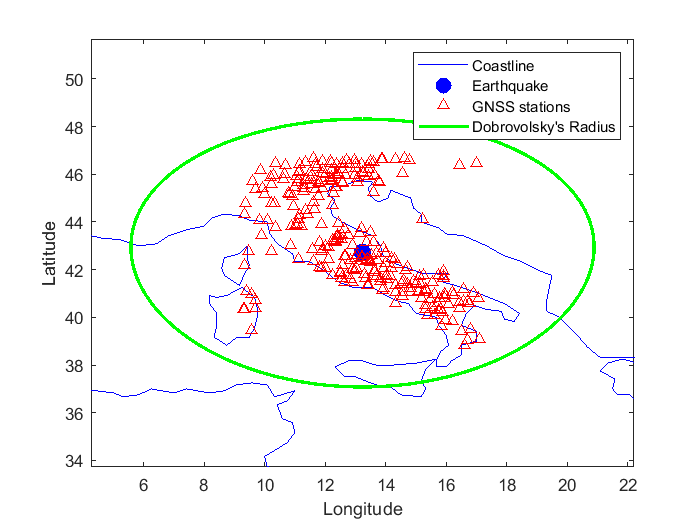

In [3]:
%Calculus of basic scientific parameters to setup the data request
%Calculus of earthquake origin time
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
%Calculus of time start and end of the VRE analysis
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
[year_start, month_start, day_start] = datevec(time_start);
[year_end, month_end, day_end] = datevec(time_end);
%Calculus of the research area and the limits in latitude and longitude to search for GNSS data (square inscribed in Dobrovolsky's area)
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = epilat - radius_Dobrovolsky/sqrt(2);
max_lat = epilat + radius_Dobrovolsky/sqrt(2);
min_lon = epilon - radius_Dobrovolsky/sqrt(2);
max_lon = epilon + radius_Dobrovolsky/sqrt(2);

%Construction of the URL to retrieve GNSS data with the above constraints
weburl_to_retrive_the_GNSS_station_list = ['https://gnssproducts.epos.ubi.pt/glass/products/velocities/geojson/SGO-EPND/', num2str(min_lon, '%.4f'), '/', num2str(min_lat, '%.4f'), '/', num2str(max_lon, '%.4f'), '/', num2str(max_lat, '%.4f'), '/'];
%Request of GNSS station list to EPOS data portal
GNSS_station_list = webread(weburl_to_retrive_the_GNSS_station_list);
%Organisation of the result from the EPOS data portal in a struct with one item for each retrieved stations
data_from_GNSS = {};
k_GNSS = 1;
if size(GNSS_station_list, 1) > 0
    GNSS_station_list = GNSS_station_list.features;
    number_of_GNSS_stations = size(GNSS_station_list, 1)
    if number_of_GNSS_stations > 0
        coordinates_of_GNSS = nan(number_of_GNSS_stations, 2);
        for i = 1:number_of_GNSS_stations
%It's necessary to insert a test of time availability inside the VRE time of interest
            coordinates_of_GNSS(i,1) = GNSS_station_list(i).properties.Longitude;
            coordinates_of_GNSS(i,2) = GNSS_station_list(i).properties.Latitude;
            weburl_to_retrive_the_data = ['https://gnssproducts.epos.ubi.pt/GlassFramework/webresources/products/timeseries/', GNSS_station_list(i).properties.GNSSStationID, '/SGO-EPND/weekly/enu/json/?epoch_start=', num2str(year_start), '-', num2str(month_start, '%02.0f'), '-', num2str(day_start, '%02.0f'), '&epoch_end=', num2str(year_end), '-', num2str(month_end, '%02.0f'), '-', num2str(day_end, '%02.0f')]; 
            GNSS_data = webread(weburl_to_retrive_the_data);
            if strcmp(GNSS_data, 'No data available') == 0
%In this case, there is available data, and we keep this data
                GNSS_data = GNSS_data.results;
%Organise the data from the stations in the array "extracted_data" with each row for a specific epoch:
% timestamp | North component | East component | Up component
                extracted_data = nan(size(GNSS_data,1), 4);
                for k = 1:size(GNSS_data,1)
                    extracted_data(k,1) = datenum(GNSS_data(k).epoch);
                    extracted_data(k,2) = GNSS_data(k).dn; %North GNSS component timeseries
                    extracted_data(k,3) = GNSS_data(k).de; %East GNSS component timeseries
                    extracted_data(k,4) = GNSS_data(k).du; %Up GNSS component timeseries
                end
% Extraction of the coordinates of the specific GNSS station
                data_from_GNSS{k_GNSS, 1}.coordinates = coordinates_of_GNSS(i,:);
                data_from_GNSS{k_GNSS, 1}.data = extracted_data;
                k_GNSS = k_GNSS + 1;
            end                      
        end
    end
end

%Plot of the map of the available GNSS stations from EPOS data portal 
coordinates_for_map = nan(k_GNSS-1, 2);
for i=1:(k_GNSS-1)
    coordinates_for_map(i,:) = data_from_GNSS{i}.coordinates;
end
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(coordinates_for_map(:,1), coordinates_for_map(:,2), '^r');
[aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
plot(bbs,aas,'-g', 'LineWidth',2);
axis([min_lon-5 max_lon+5 min_lat-5 max_lat+5]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations', ['Dobrovolsky', 39 ,'s Radius']);

The following block calculates some basic parameters to analyse the data from the GNSS stations.  
In particular, the **angular tolerance** is a parameter to consider aligning two different stations eventually with respect to the fault direction (or its perpendicular direction for transect). The **maximum distance** is the segment, along the fault direction, to be investigated and it's defined as 10 times the broken fault segment.

In [4]:
angular_tollerance = 5; %maximum angular difference to be considered on the same direction
distance_GNSS_station_EQ = distance(coordinates_for_map(:,2), coordinates_for_map(:,1), epilat, epilon)*111;
angle_to_EQ = atan2d((coordinates_for_map(:,2)-epilat),(coordinates_for_map(:,1)-epilon));
Length_of_broken_fault = 3 * EQ_depth; %Proposed in Doglioni et al., Sci. Rep., 2015
Maximum_distance = 10 * Length_of_broken_fault / 2 %searching for a distance of 10 times the broken segment and symmetrical to the epicenter.
%Maximum distance is calculated in km


Maximum_distance = 150

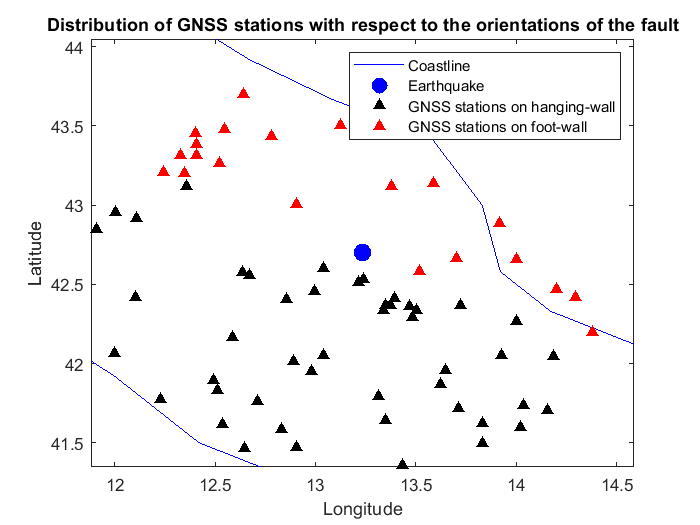

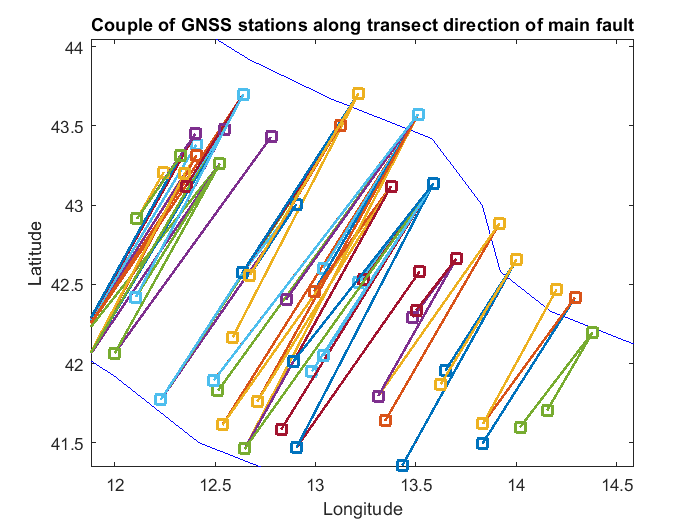

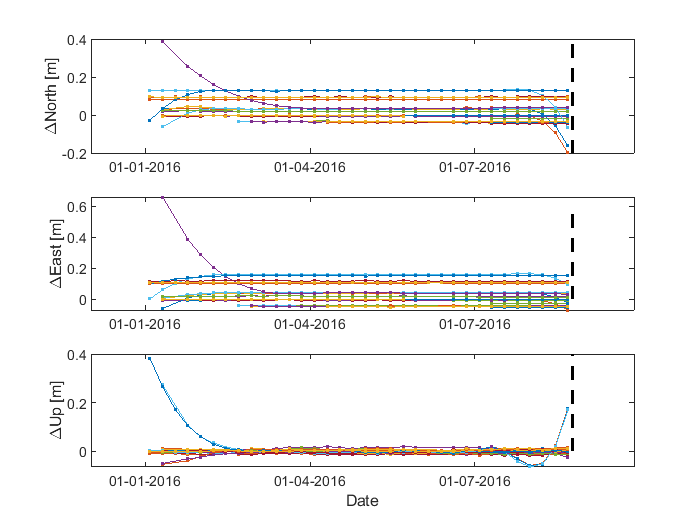

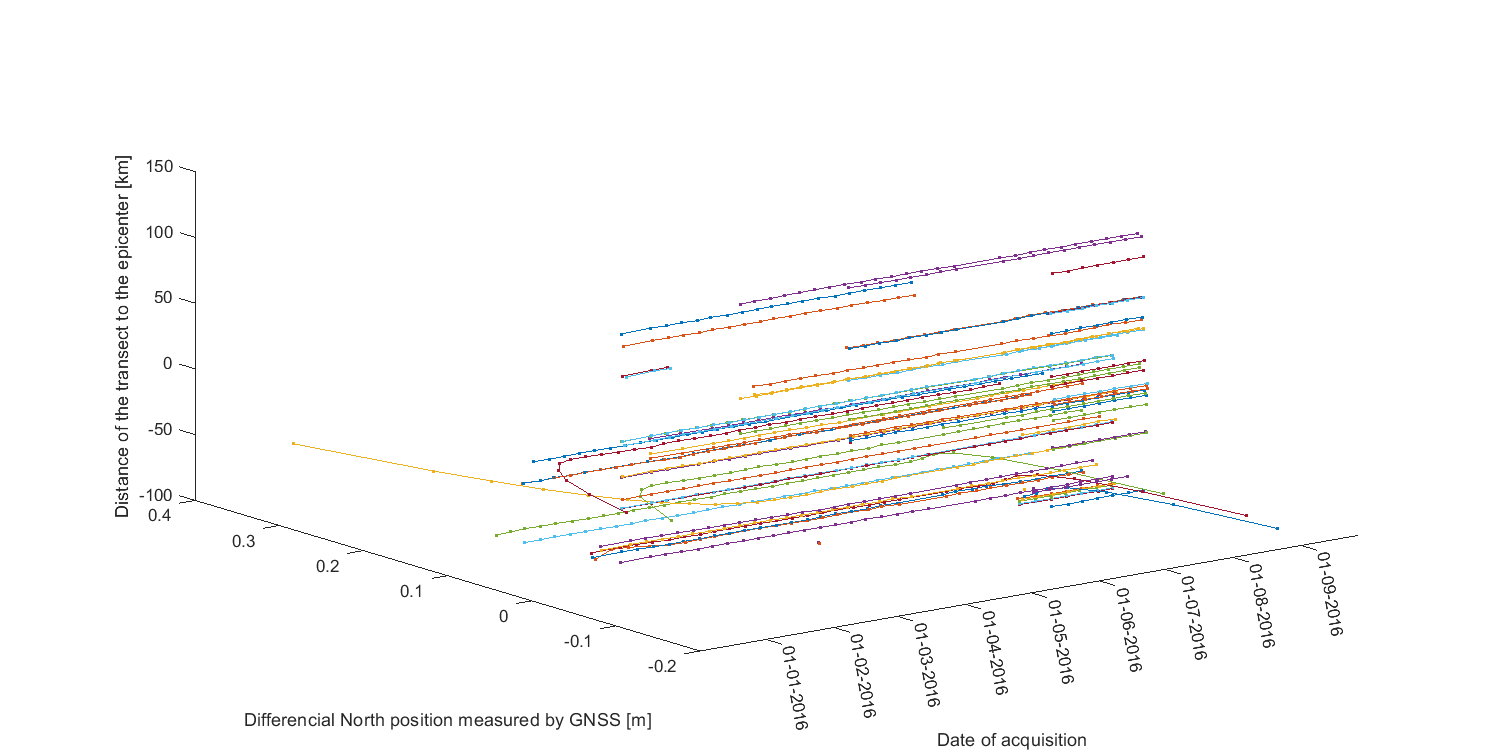

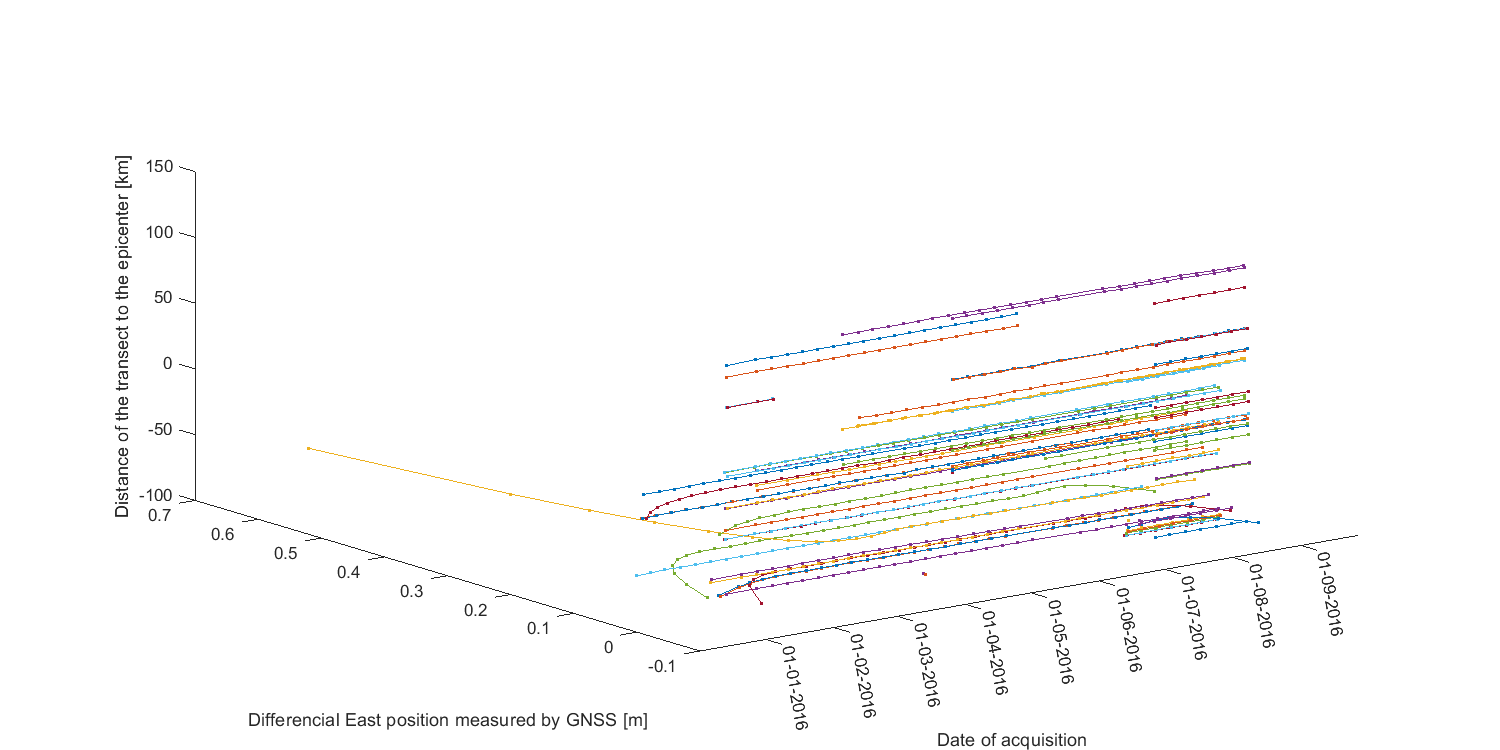

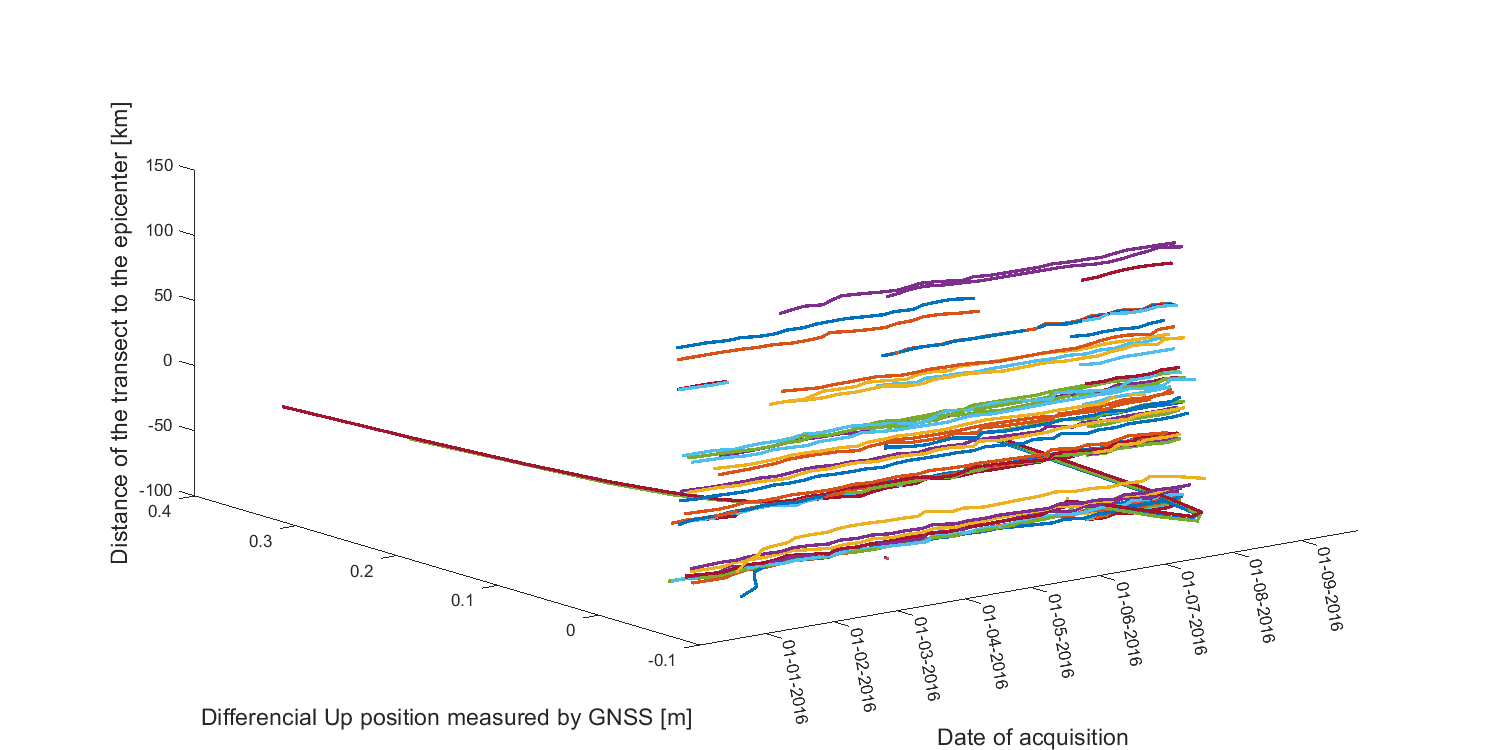

In [6]:
%Calculus of the straight angle of fault strike (same direction opposite verse)
Complementary_strike_angle = Fault_strike - 180;
%Calculus of the perpendicular direction to the one of the fault (transect direction)
Perpendicular_angle = Fault_strike - 90;
%Selection of the GNSS stations that rely on the side of the footwall or hanging wall with respect to the main fault.
%The selection is based on the comparison of the angle of the specific station with respect to the target earthquake.
GNSS_stations_on_footwall = data_from_GNSS((angle_to_EQ > Complementary_strike_angle & angle_to_EQ < Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
GNSS_stations_on_hanging = data_from_GNSS((angle_to_EQ < Complementary_strike_angle | angle_to_EQ > Fault_strike) & distance_GNSS_station_EQ <= Maximum_distance);
%Collection of the GNSS coordinates for the two groups of stations
for i = 1:size(GNSS_stations_on_hanging, 1)
    GNSS_stations_on_hanging_coordinates(i,:) = GNSS_stations_on_hanging{i}.coordinates;
end
for i = 1:size(GNSS_stations_on_footwall, 1)
    GNSS_stations_on_footwall_coordinates(i,:) = GNSS_stations_on_footwall{i}.coordinates;
end

%Creation of a map with the division of GNSS stations on the side of the footwall or hanging wall
figure
load coastlines
plot(coastlon, coastlat, '-b')
hold on
plot(epilon, epilat, 'ob', 'MarkerSize', 10, 'MarkerFaceColor', 'b')
plot(GNSS_stations_on_hanging_coordinates(:,1), GNSS_stations_on_hanging_coordinates(:,2), '^k', 'MarkerFaceColor', 'k');
plot(GNSS_stations_on_footwall_coordinates(:,1), GNSS_stations_on_footwall_coordinates(:,2), '^r', 'MarkerFaceColor', 'r');
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
legend('Coastline', 'Earthquake', 'GNSS stations on hanging-wall', 'GNSS stations on foot-wall');
title('Distribution of GNSS stations with respect to the orientations of the fault');

% Preparation of two figures: one is the map (figure_2_handle) with a couple of GNSS stations whose direction is perpendicular to the fault strike.
% The other figure (figure_1_handle) presents the results of the differential displacement for each couple of GNSS stations
figure_2_handle = figure;
load coastlines
plot(coastlon, coastlat, '-b');
hold on;
axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
xlabel('Longitude')
ylabel('Latitude')
title('Couple of GNSS stations along transect direction of main fault');

figure_1_handle = figure;
%this figure is divided in three panels for each component of GNSS signal in the form of time series.
%North
subplot(3,1,1)
plot([EQ_time, EQ_time], [-0.2, 0.4], '--k', 'LineWidth', 2);
hold on; %Allows to superpose the time series from different couples of GNSS stations    
%East
subplot(3,1,2)
plot([EQ_time, EQ_time], [0, 0.6], '--k', 'LineWidth', 2);
hold on;
%Up
subplot(3,1,3)
plot([EQ_time, EQ_time], [0, 0.4], '--k', 'LineWidth', 2);
hold on;

%the results are also stored in a structure called results_from_perpendicular_stations
results_from_perpendicular_stations = {};
k_stations = 1;
for i = 1:size(GNSS_stations_on_hanging, 1)
    % Calculate the angle of a station on footwall with respect to the i-station on hanging wall 
    angle_to_station = atan2d(GNSS_stations_on_footwall_coordinates(:,2)-GNSS_stations_on_hanging_coordinates(i,2),GNSS_stations_on_footwall_coordinates(:,1)-GNSS_stations_on_hanging_coordinates(i,1));
    % Select only the stations that are perpendicular to fault strike (i.e., they are on a transect).
    index_good_stations_footwall = find(abs(angle_to_station - (Fault_strike-90))  <= angular_tollerance | abs(angle_to_station - (Fault_strike - 270)) <= angular_tollerance);
    if size(index_good_stations_footwall, 1) > 0
        % Extract the data from the first station
        data_from_station_1 = GNSS_stations_on_hanging{i}.data;
        for k=1:size(index_good_stations_footwall, 1)
            % Extract the data from the second station
            data_from_station_2 = GNSS_stations_on_footwall{index_good_stations_footwall(k)}.data;
            % In order to compare the observations the measurements from second station are resampled on the time of the first station that in principle they could be different
            data_from_station_2_resamples = nan(size(data_from_station_1,1), 4);
            data_from_station_2_resamples(:,1) = data_from_station_1(:,1);
            data_from_station_2_resamples(:,2) = interp1(data_from_station_2(:,1),data_from_station_2(:,2), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,3) = interp1(data_from_station_2(:,1),data_from_station_2(:,3), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            data_from_station_2_resamples(:,4) = interp1(data_from_station_2(:,1),data_from_station_2(:,4), data_from_station_2_resamples(:,1), 'pchip', 'extrap');
            % Differences of GNSS measurements for the three components for a specific couple of GNSS station
            differences_GNSS = (data_from_station_1(:,2:4) - data_from_station_2_resamples(:,2:4));
            % The following calculus computes the distance of the transect from the epicenter.
            %The Heron's  formula is used: area  = sqrt(s(s-a)*(s-b)*(s-c))
            % Calculus of the length of the first side
            distance_st1_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), ...
            GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            % Calculus of the length of the second side
            distance_st1_EQ = distance(epilat, epilon, GNSS_stations_on_hanging{i}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(1));
            % Calculus of the length of the third side
            distance_EQ_st2 = distance(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), epilat, epilon); 
            semiperimeter = 0.5 * (distance_st1_st2+distance_st1_EQ+distance_EQ_st2);
            area = sqrt(semiperimeter*(semiperimeter-distance_st1_st2)*(semiperimeter-distance_st1_EQ)*(semiperimeter-distance_EQ_st2));
            height_triangle = 2 * area / distance_st1_st2;
            % Calculus of the distance of transect in km considering that 1 degree is about 111 km on Earth's Surface
            distance_st1_st2_from_EQ = height_triangle * 111;
            % Check if the transect is in one or opposite side of the earthquake
            angle_of_st2_to_EQ = atan2d(GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2)-epilat,GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1)-epilon);
            % In case is in the opposite side the distance is converted as negative
            if angle_of_st2_to_EQ > Perpendicular_angle
                distance_st1_st2_from_EQ = - distance_st1_st2_from_EQ;
            end
            % Plot the coordinates of the couple of stations on the map
            figure(figure_2_handle)
            plot([GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(1), GNSS_stations_on_hanging{i}.coordinates(1)], [GNSS_stations_on_footwall{index_good_stations_footwall(k)}.coordinates(2), GNSS_stations_on_hanging{i}.coordinates(2)], 's-', 'LineWidth', 1.5, 'MarkerSize', 8);
            % Store the results
            results_from_perpendicular_stations{k_stations,1}.distance = distance_st1_st2_from_EQ;
            results_from_perpendicular_stations{k_stations,1}.differences_GNSS = differences_GNSS;
            results_from_perpendicular_stations{k_stations,1}.time_differences_GNSS = data_from_station_1(:,1);
            results_from_perpendicular_stations{k_stations,1}.distance_st1_st2 = distance_st1_st2;
            k_stations = k_stations + 1;
            % Plot the time series in the other graph
            figure(figure_1_handle)
            subplot(3,1,1)
            % North GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,1), '.-');
            subplot(3,1,2)
            % East  GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,2), '.-');
            subplot(3,1,3)
            % Up  GNSS time series
            plot(data_from_station_1(:,1), differences_GNSS(:,3), '.-');
        end
    end
end

% Complete the time series graph with labels and convert the time axis into a better visualization
subplot(3,1,1)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
ylabel('\DeltaNorth [m]');
%legend('NumColumns', 3);
subplot(3,1,2)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
ylabel('\DeltaEast [m]');
subplot(3,1,3)
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date')
ylabel('\DeltaUp [m]');

% Repeat the previous graph of the time series in a separated 3D plot for time series with the vertical axis 
% in function of the transect distance to the earthquake 
figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,1), distance_GNSS*ones(size(time_data_station, 1), 1), '.-');
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial North position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');

figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,2), distance_GNSS*ones(size(time_data_station, 1), 1), '.-');
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition')
ylabel('Differencial East position measured by GNSS [m]')
zlabel('Distance of the transect to the epicenter [km]');

figure('Position', [1 1 1200 600])
for i = 1:size(results_from_perpendicular_stations,1)
    distance_GNSS = results_from_perpendicular_stations{i}.distance;
    data_station = results_from_perpendicular_stations{i}.differences_GNSS;
    time_data_station = results_from_perpendicular_stations{i}.time_differences_GNSS;
    plot3(time_data_station, data_station(:,3), distance_GNSS*ones(size(time_data_station, 1), 1), '.-', 'LineWidth', 2);
    hold on;
end
datetick('x', 'dd-mm-yyyy', 'keeplimits');
xlabel('Date of acquisition', 'FontSize', 14)
ylabel('Differencial Up position measured by GNSS [m]', 'FontSize', 14)
zlabel('Distance of the transect to the epicenter [km]', 'FontSize', 14);


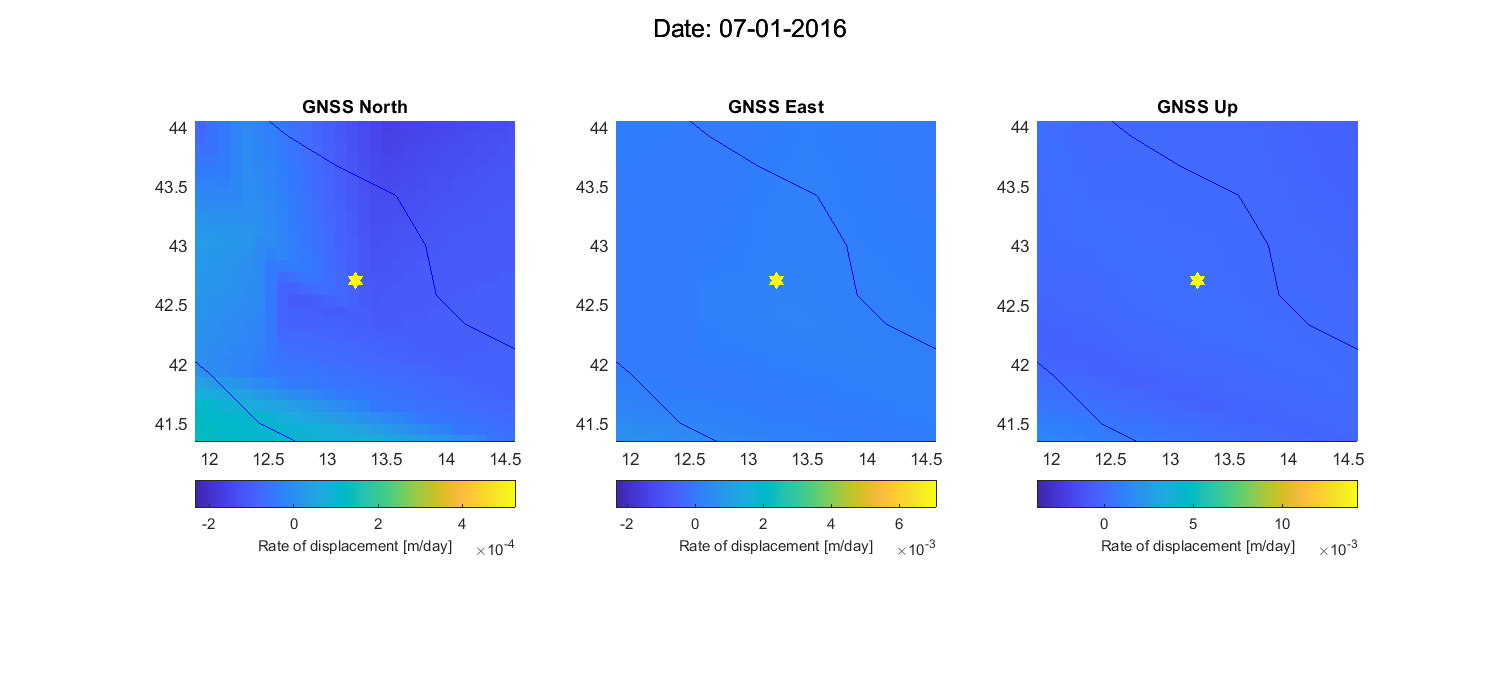

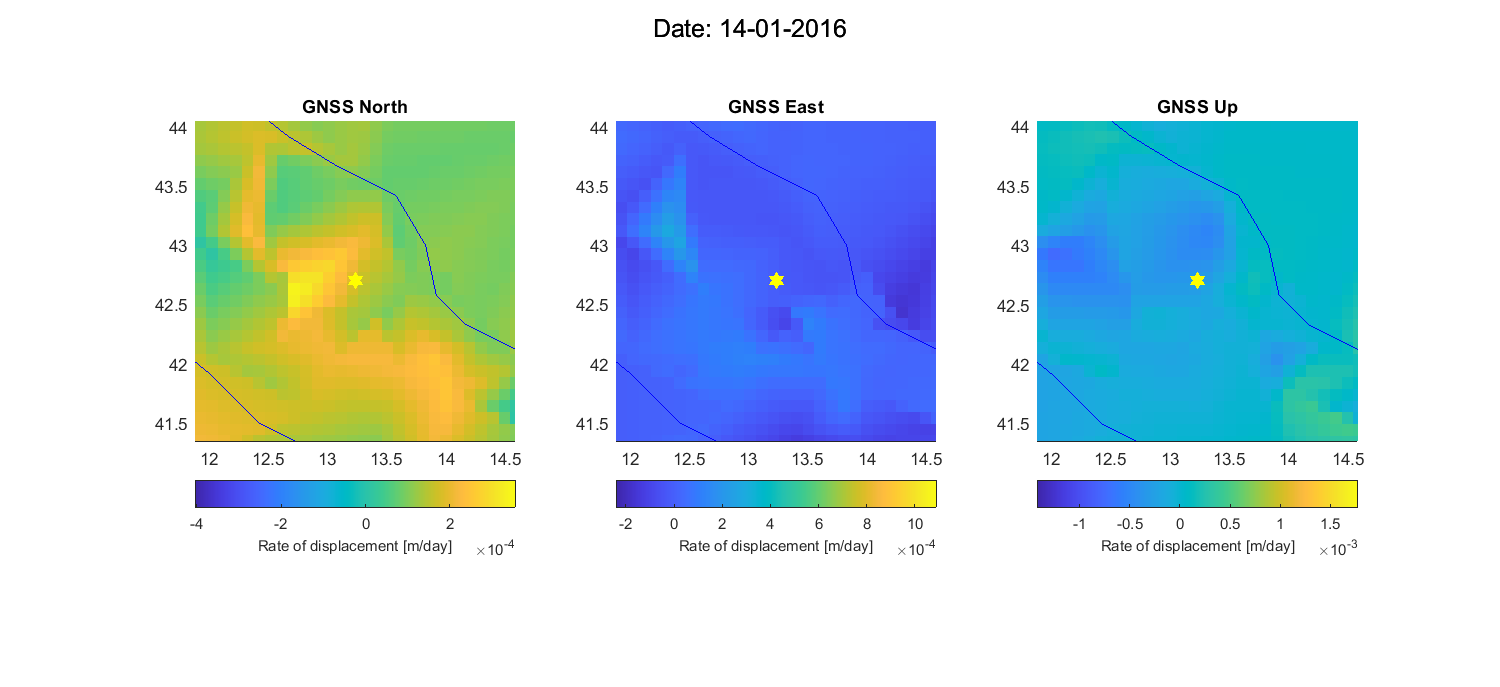

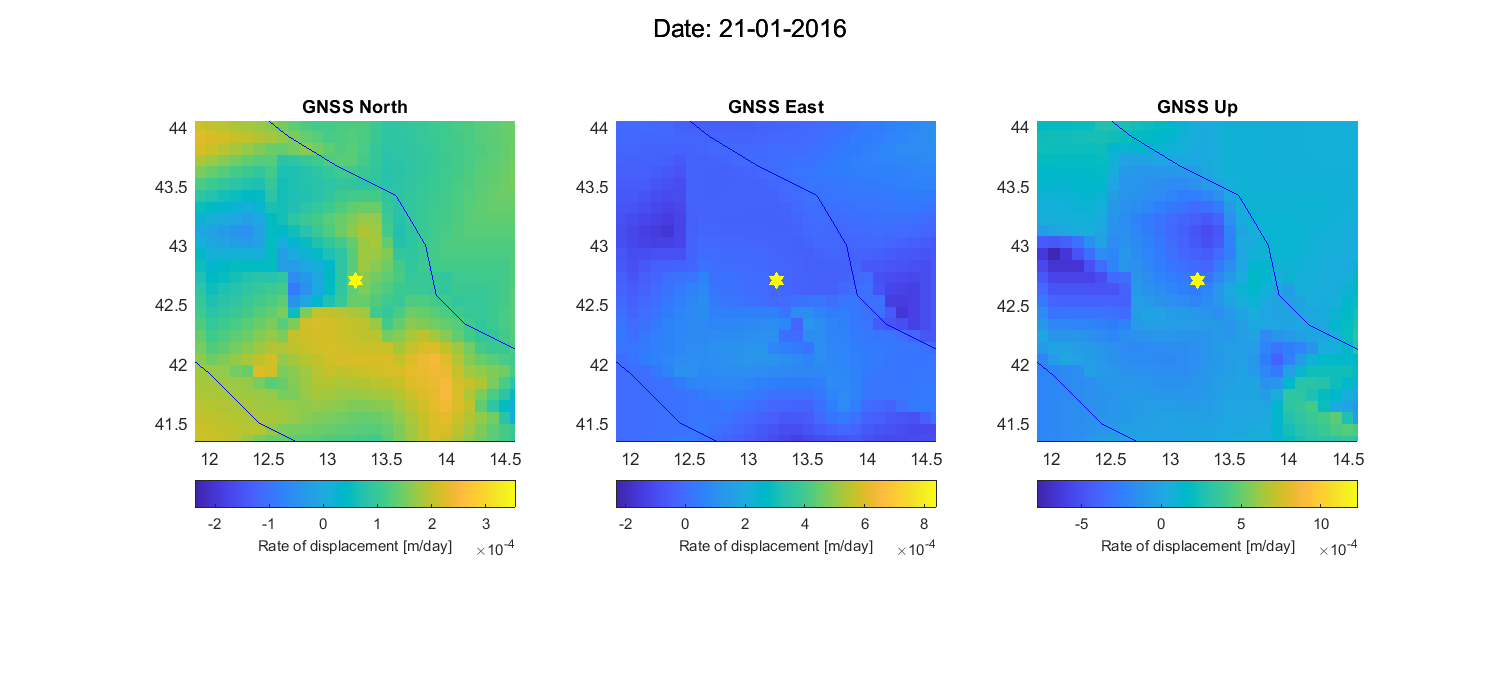

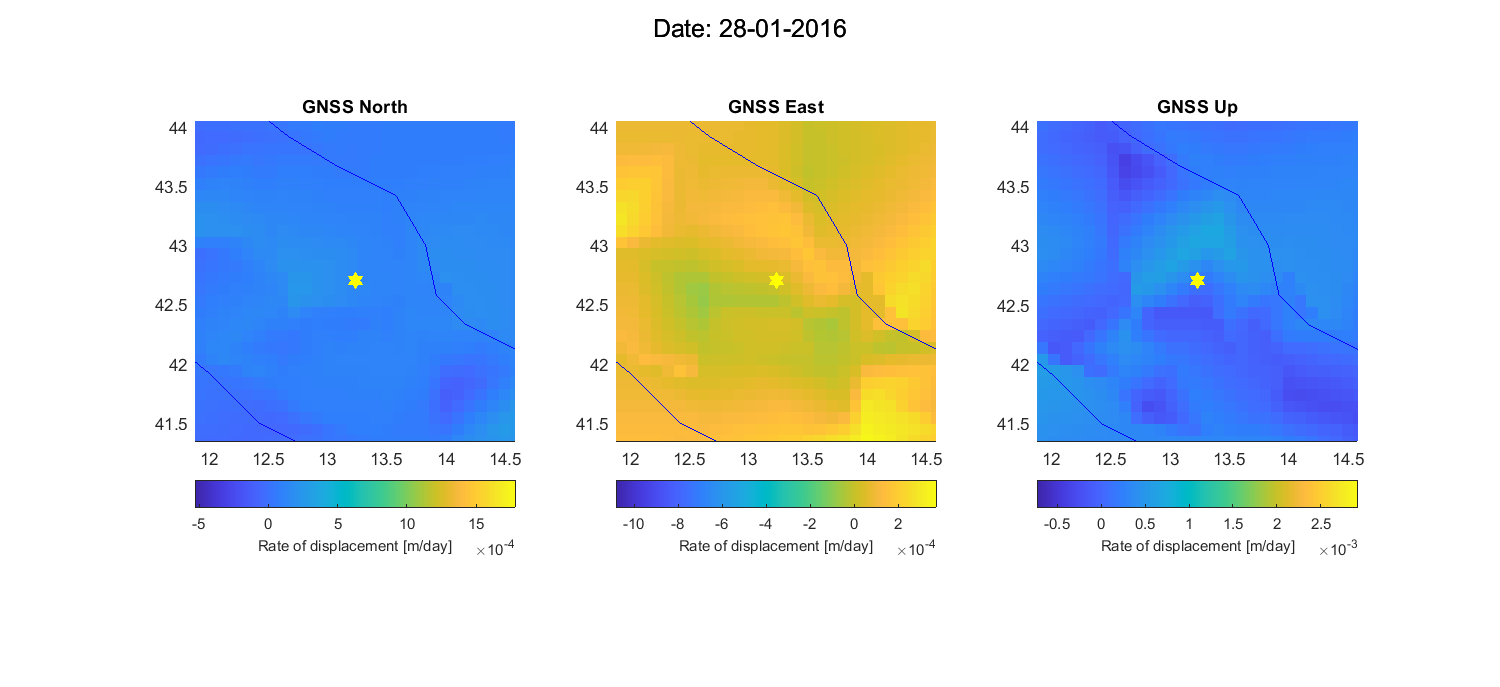

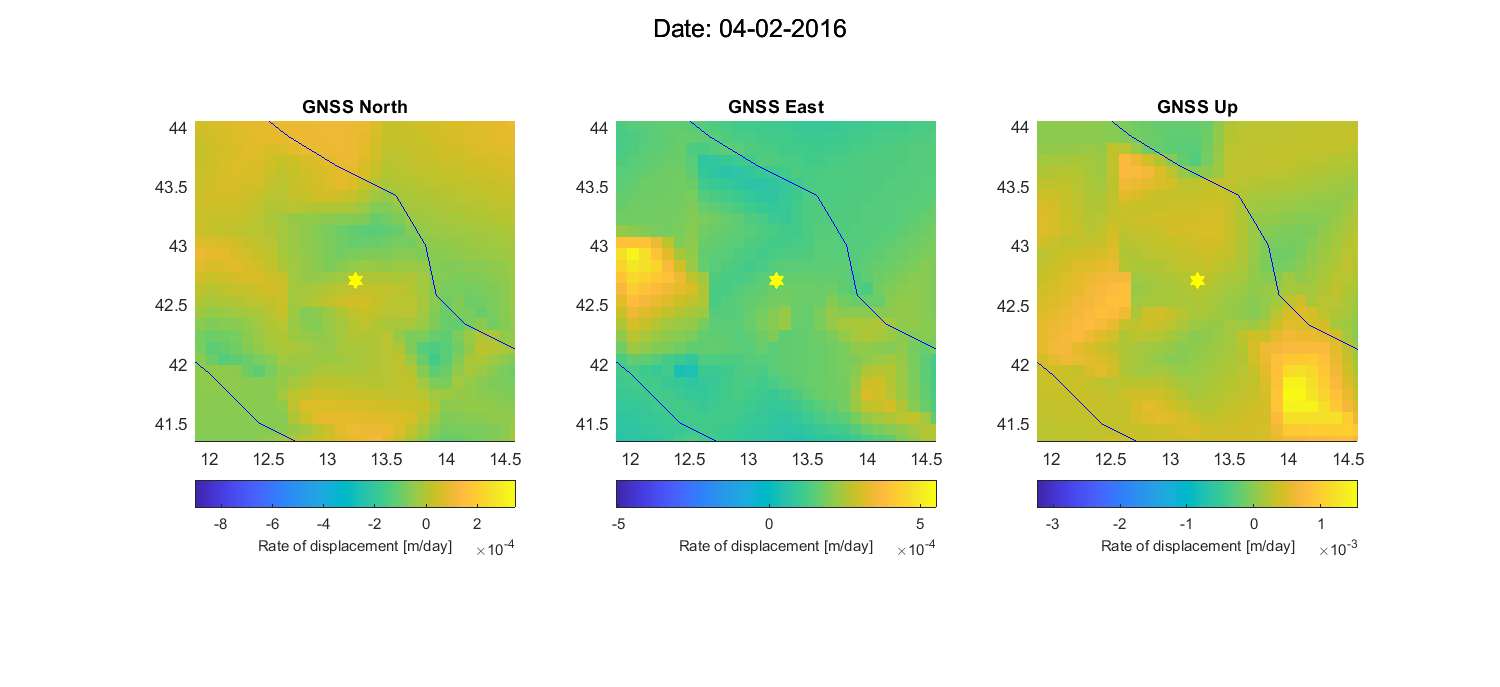

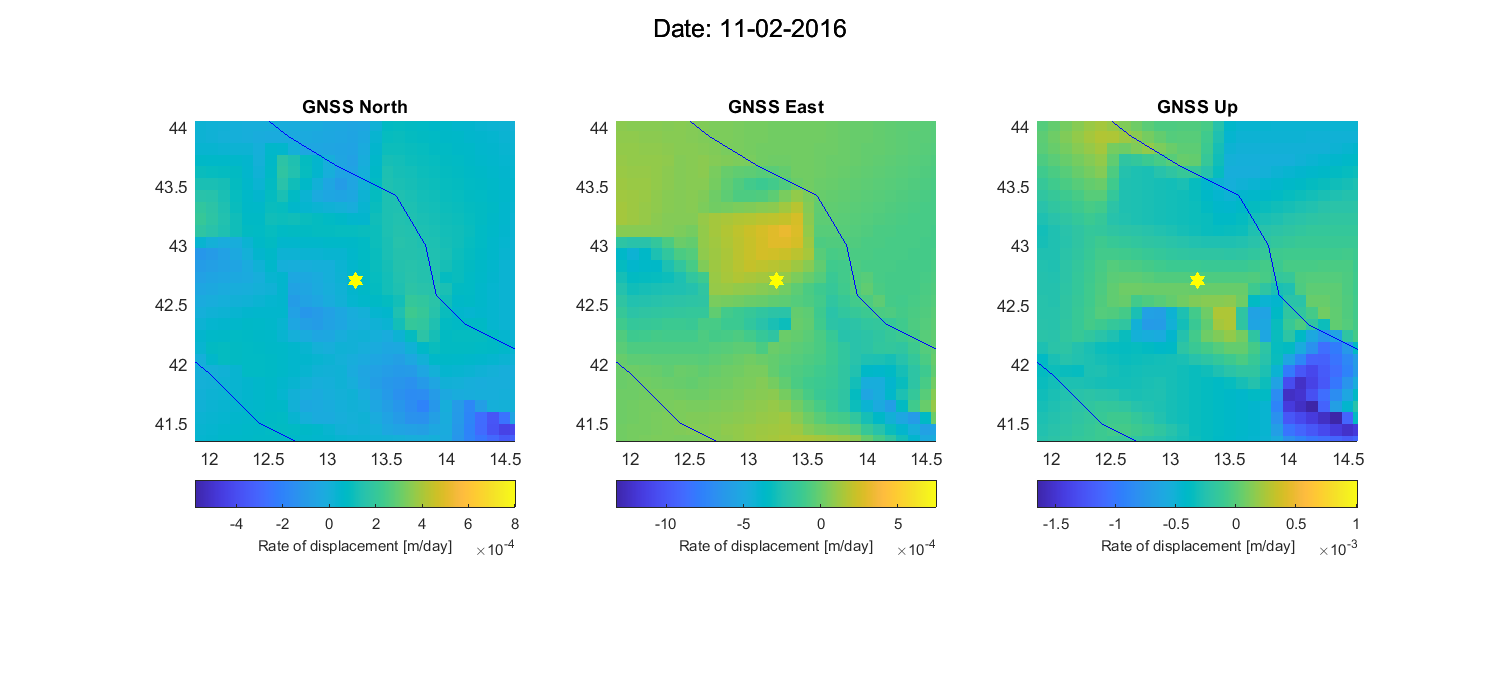

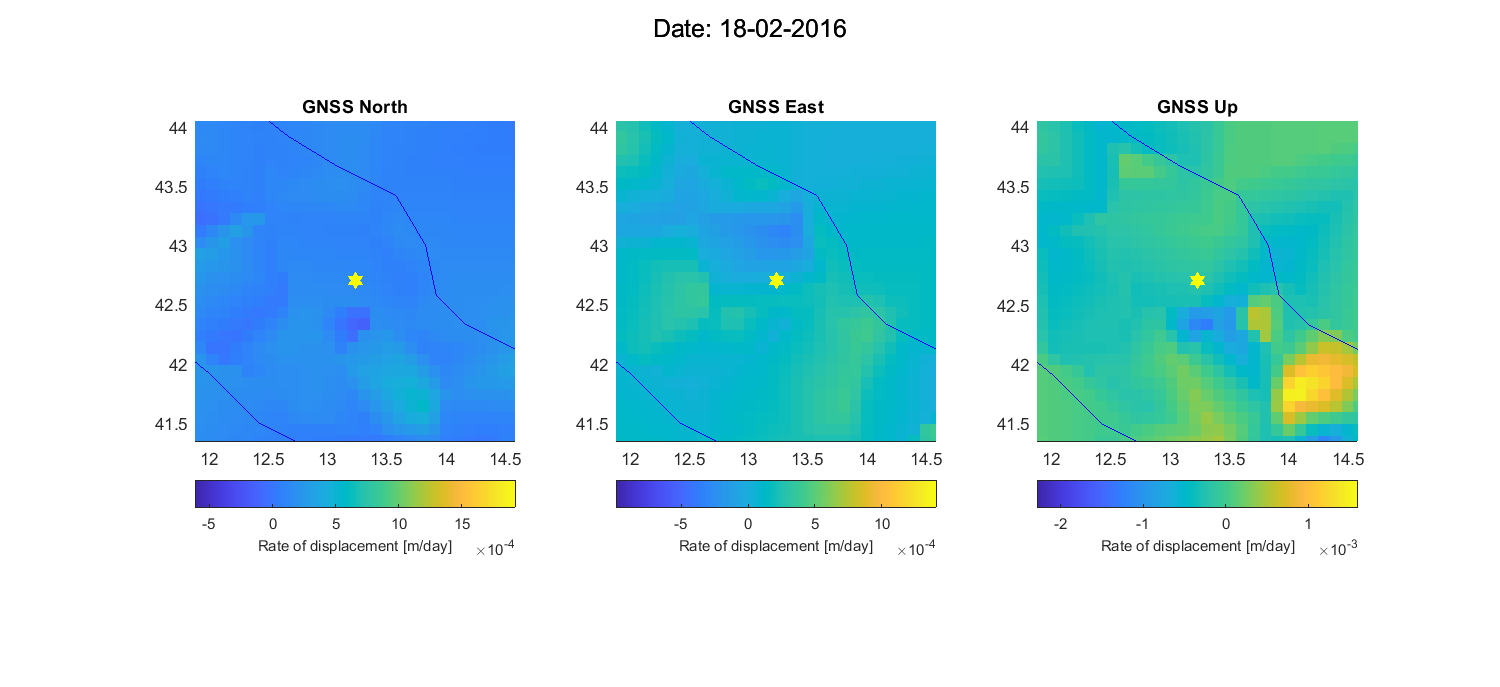

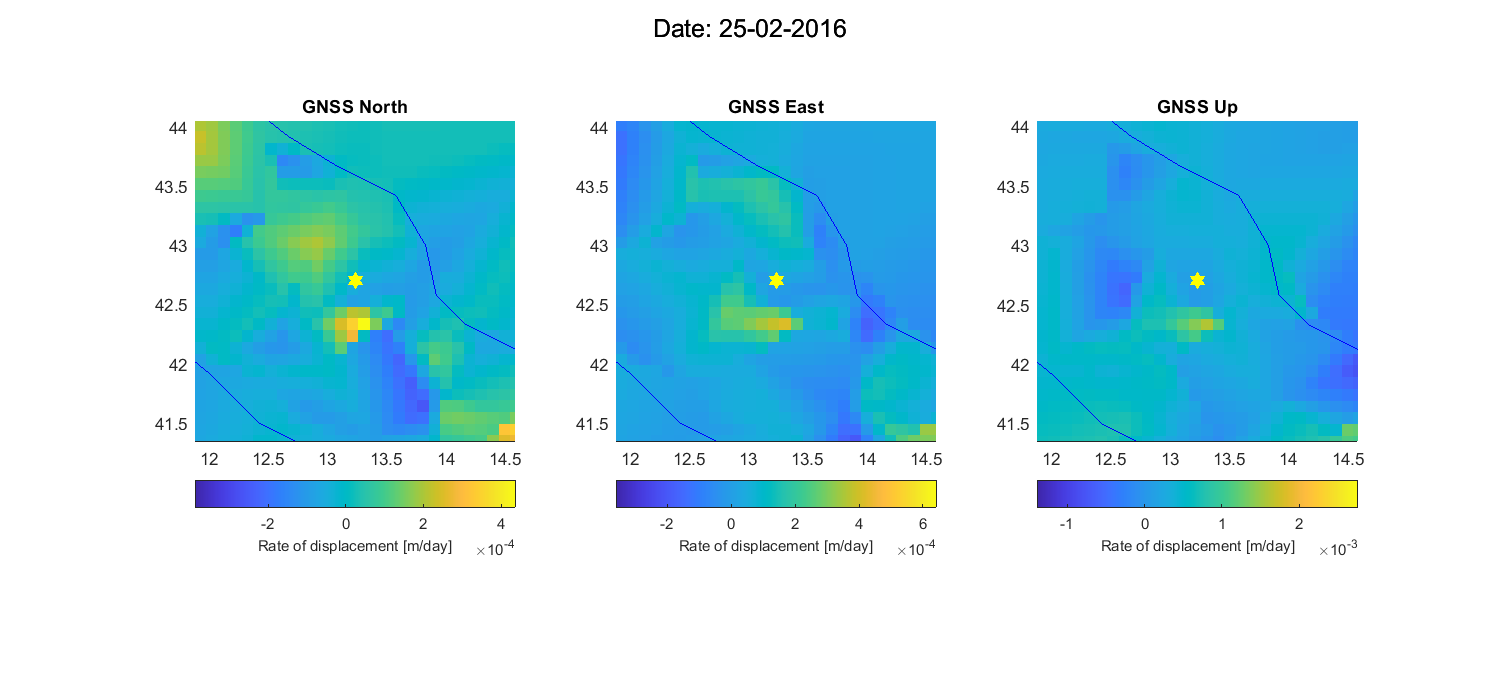

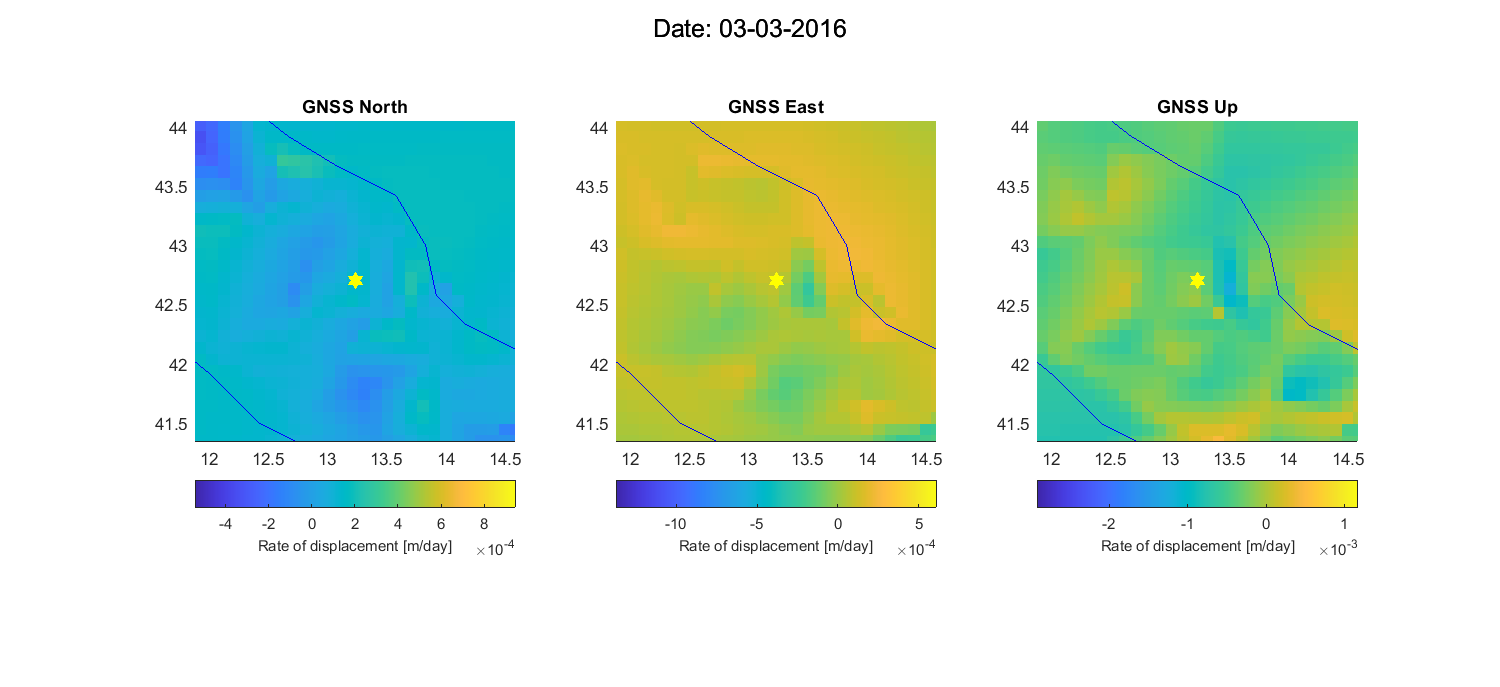

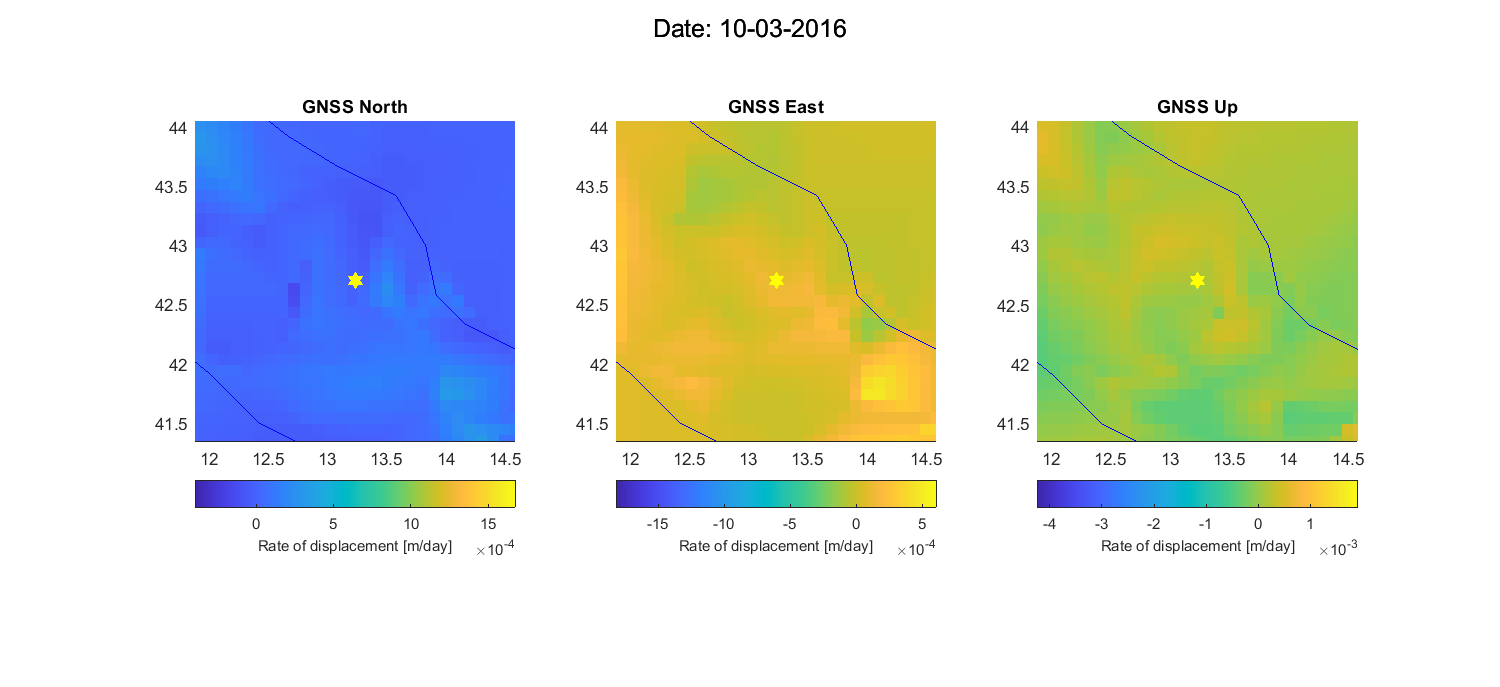

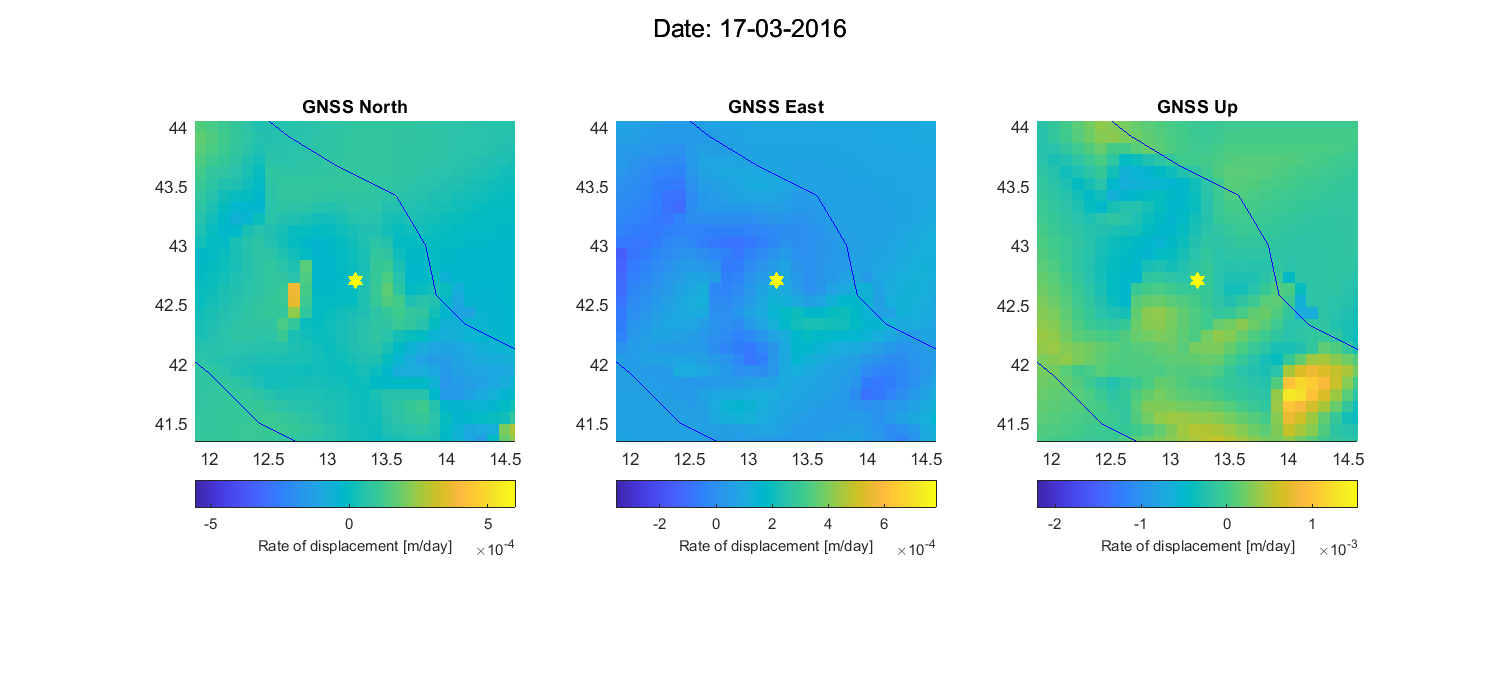

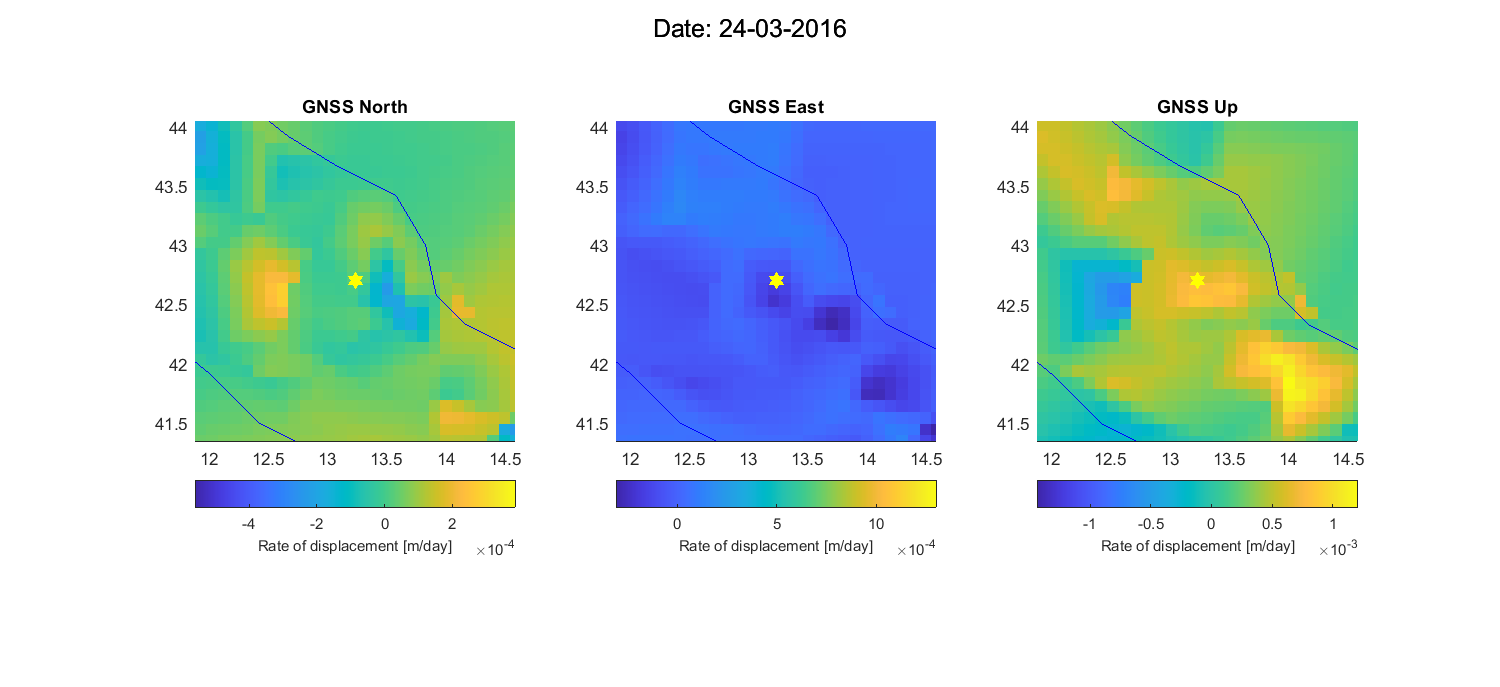

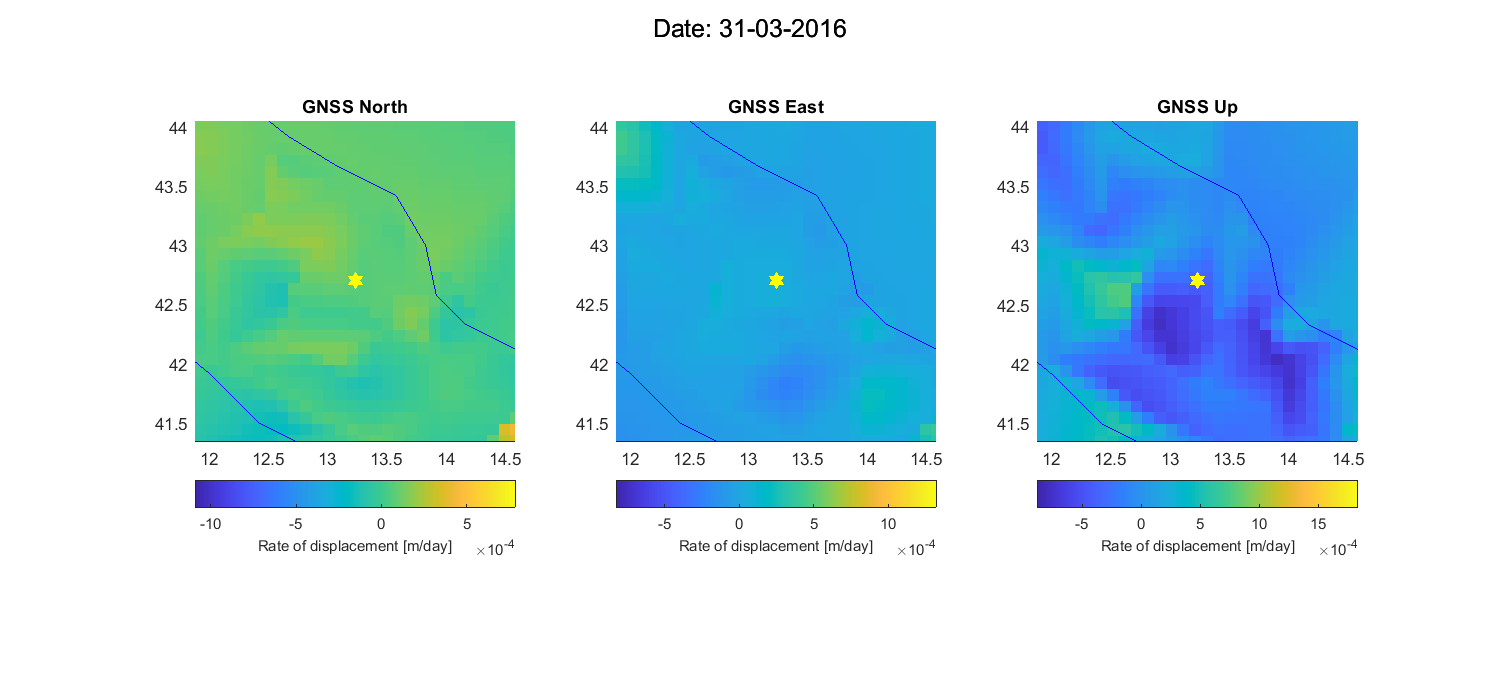

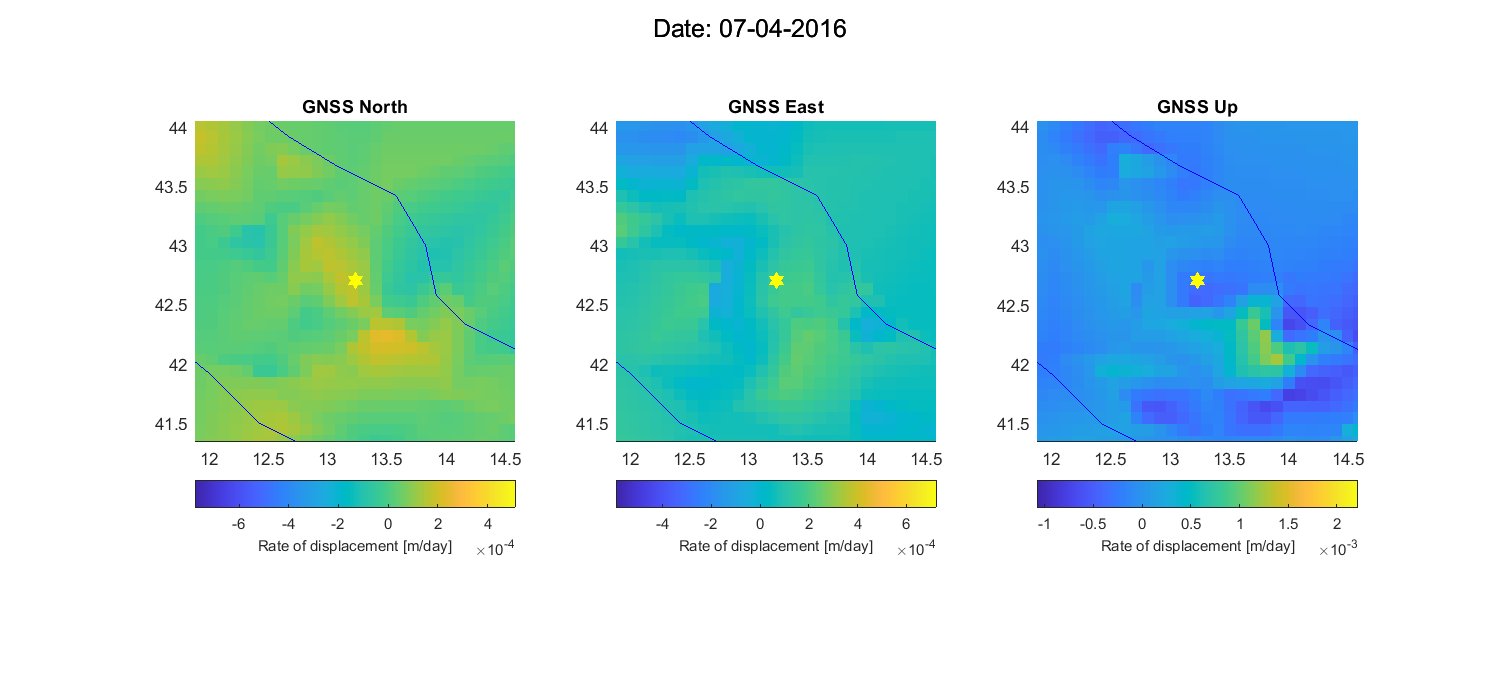

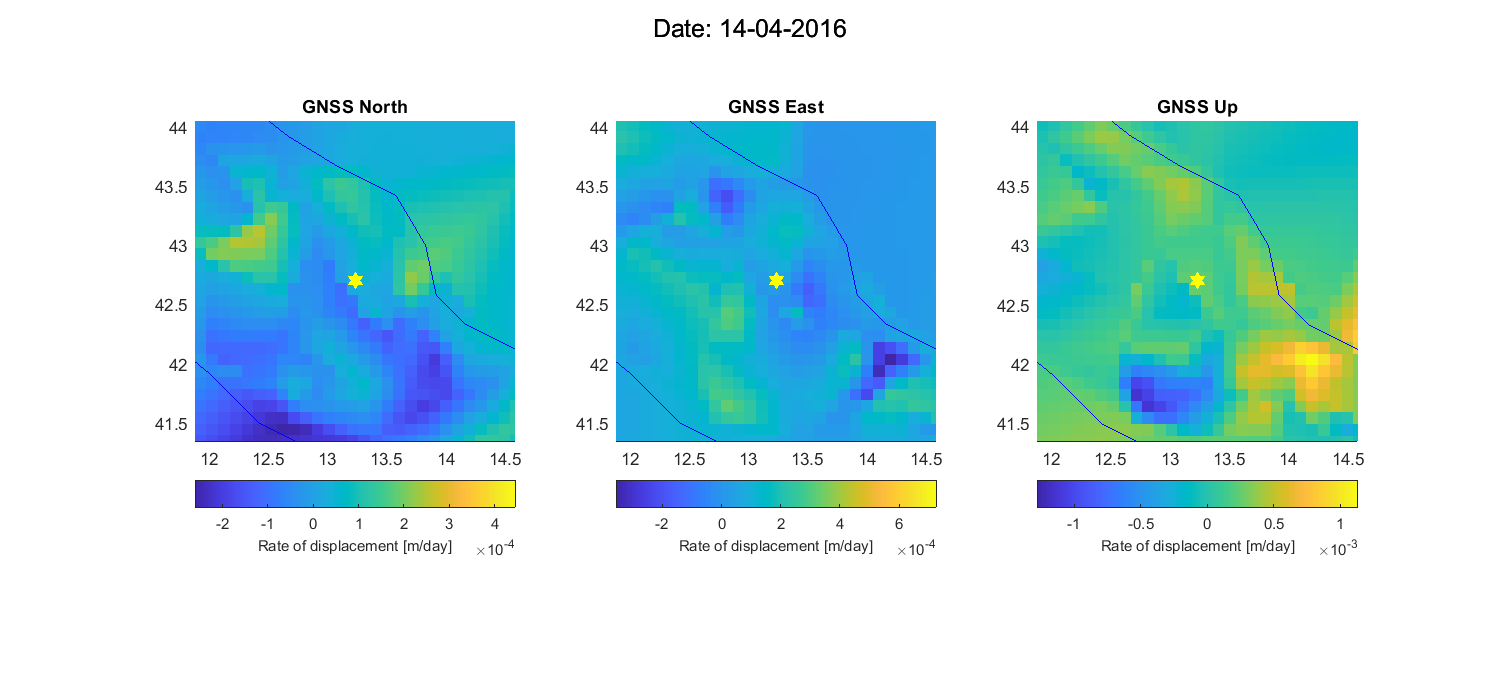

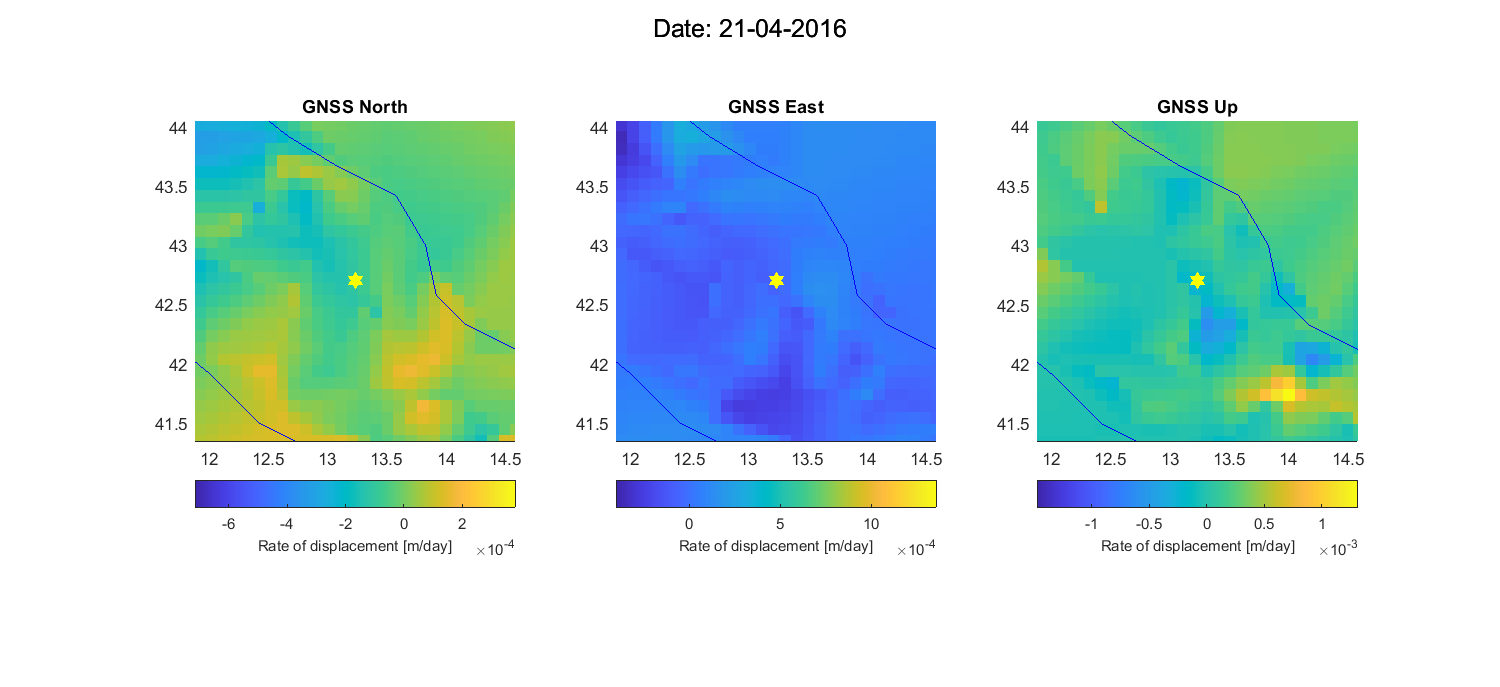

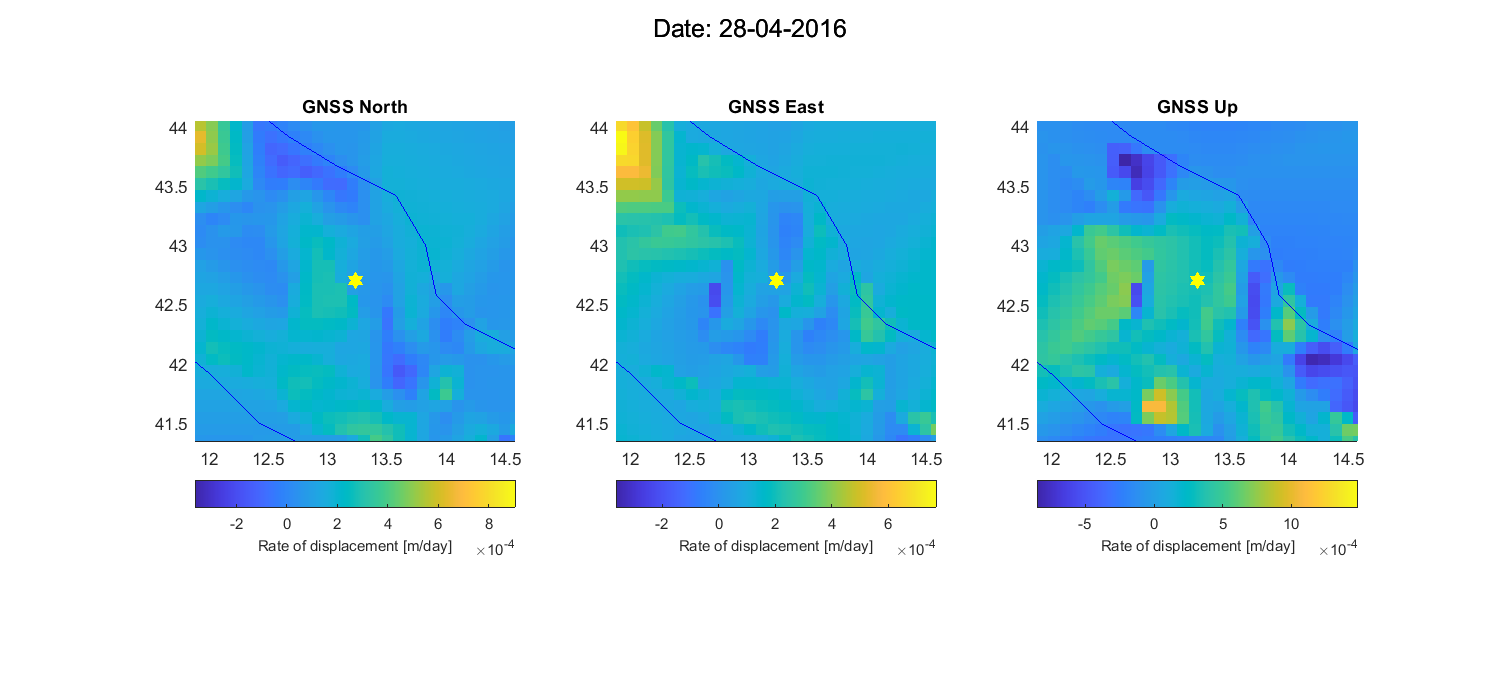

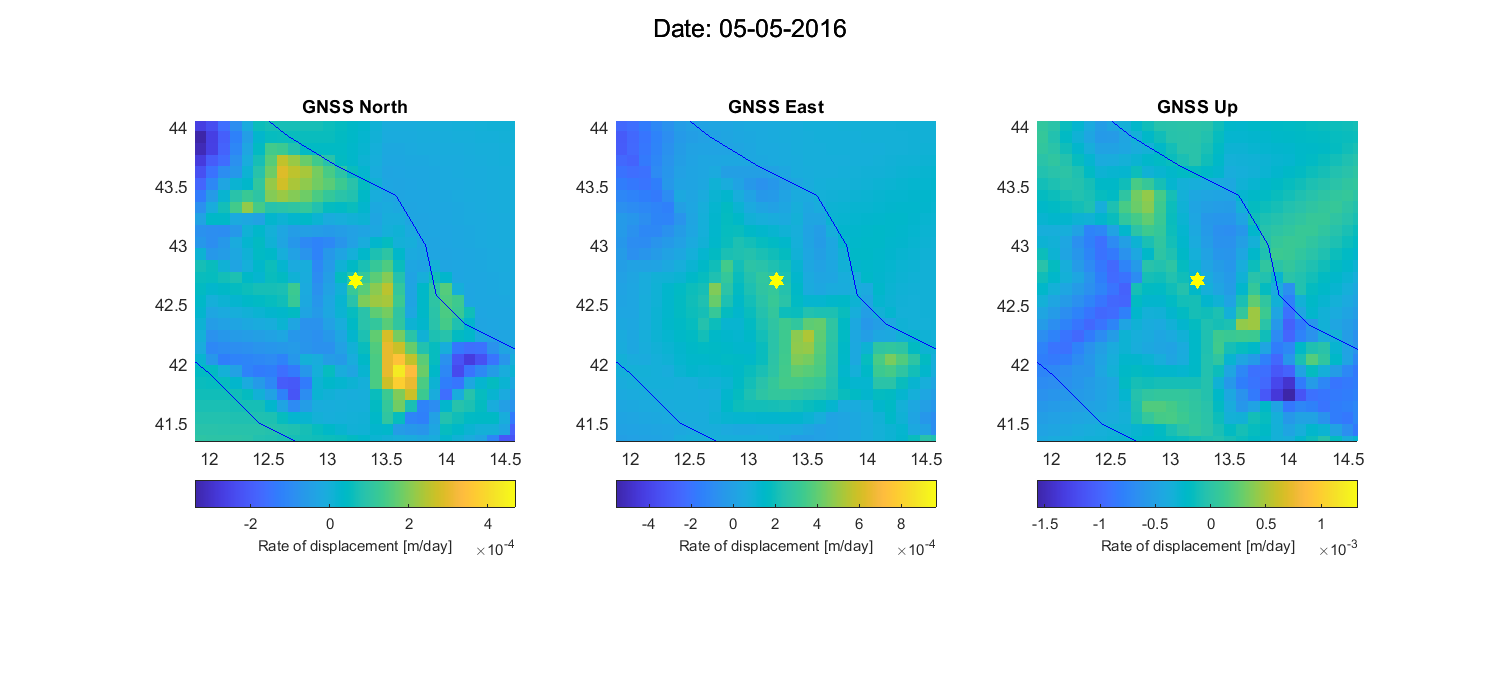

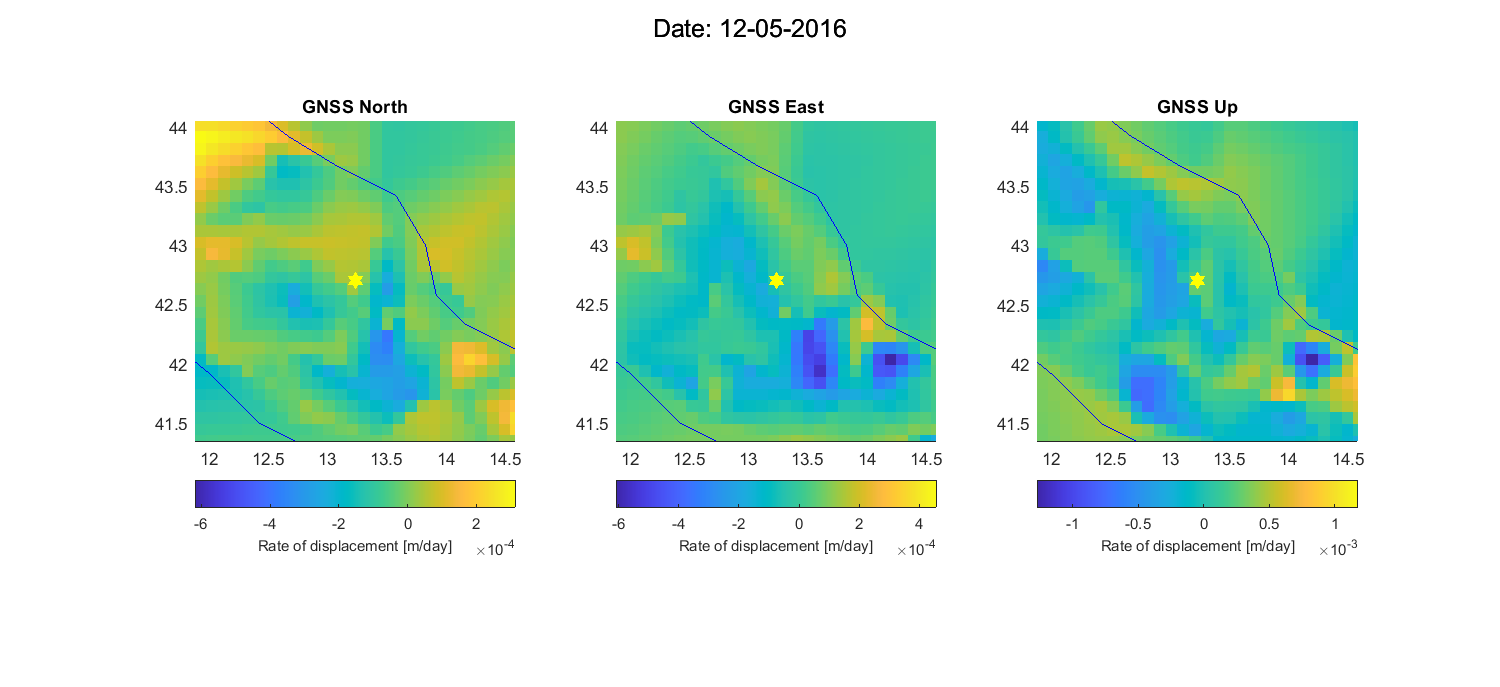

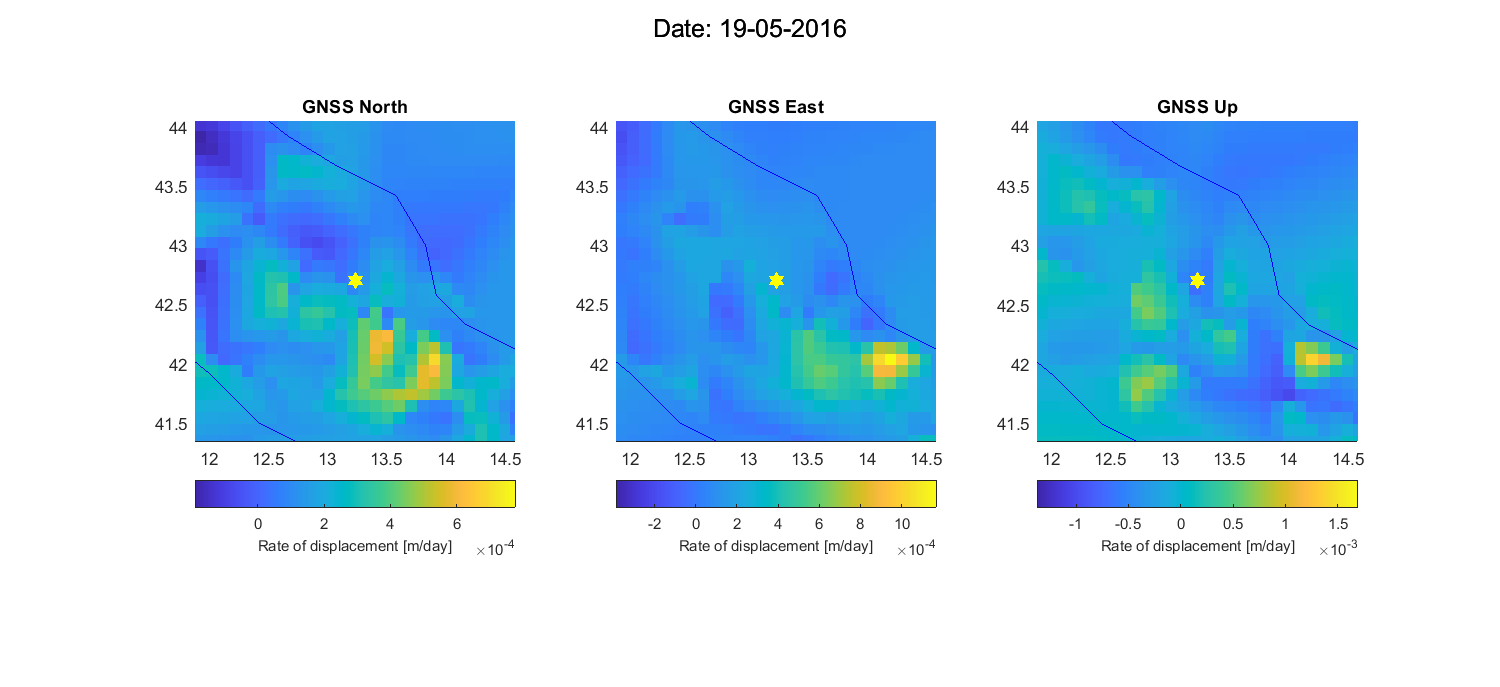

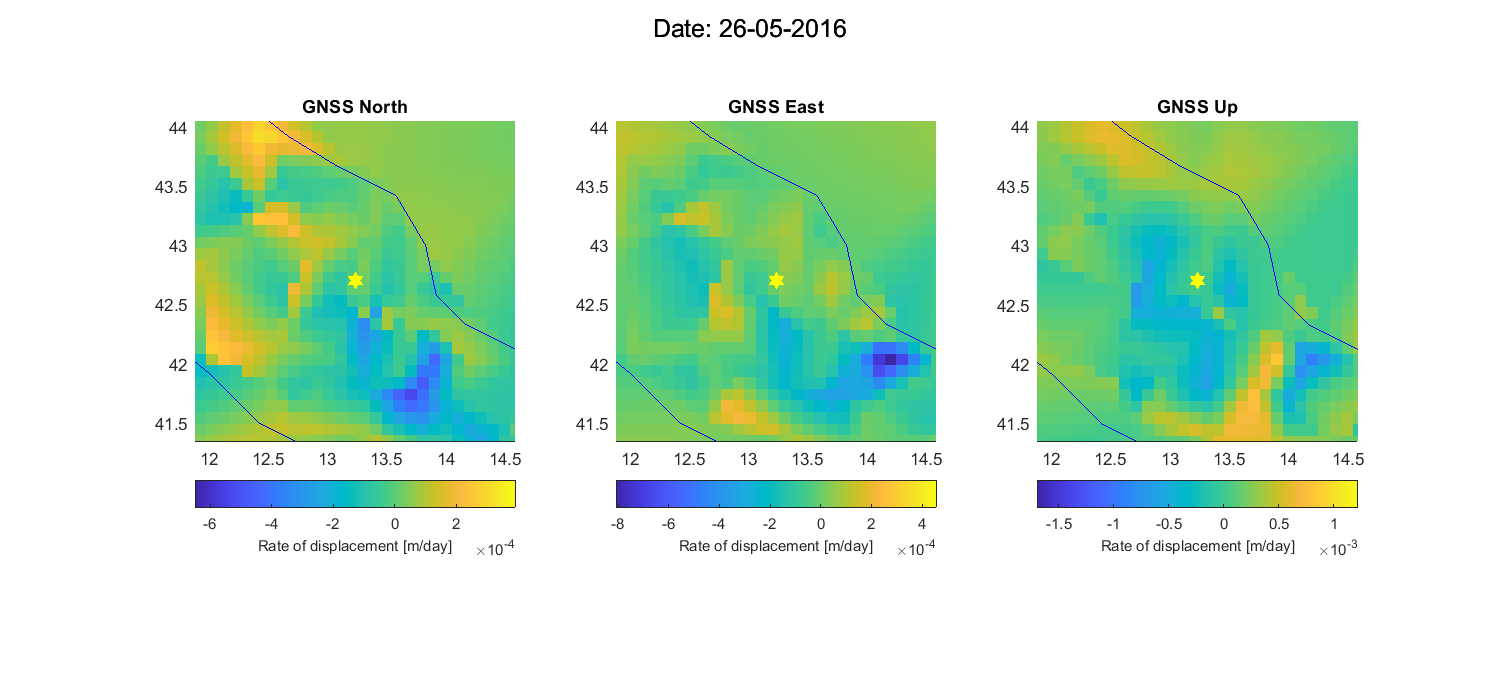

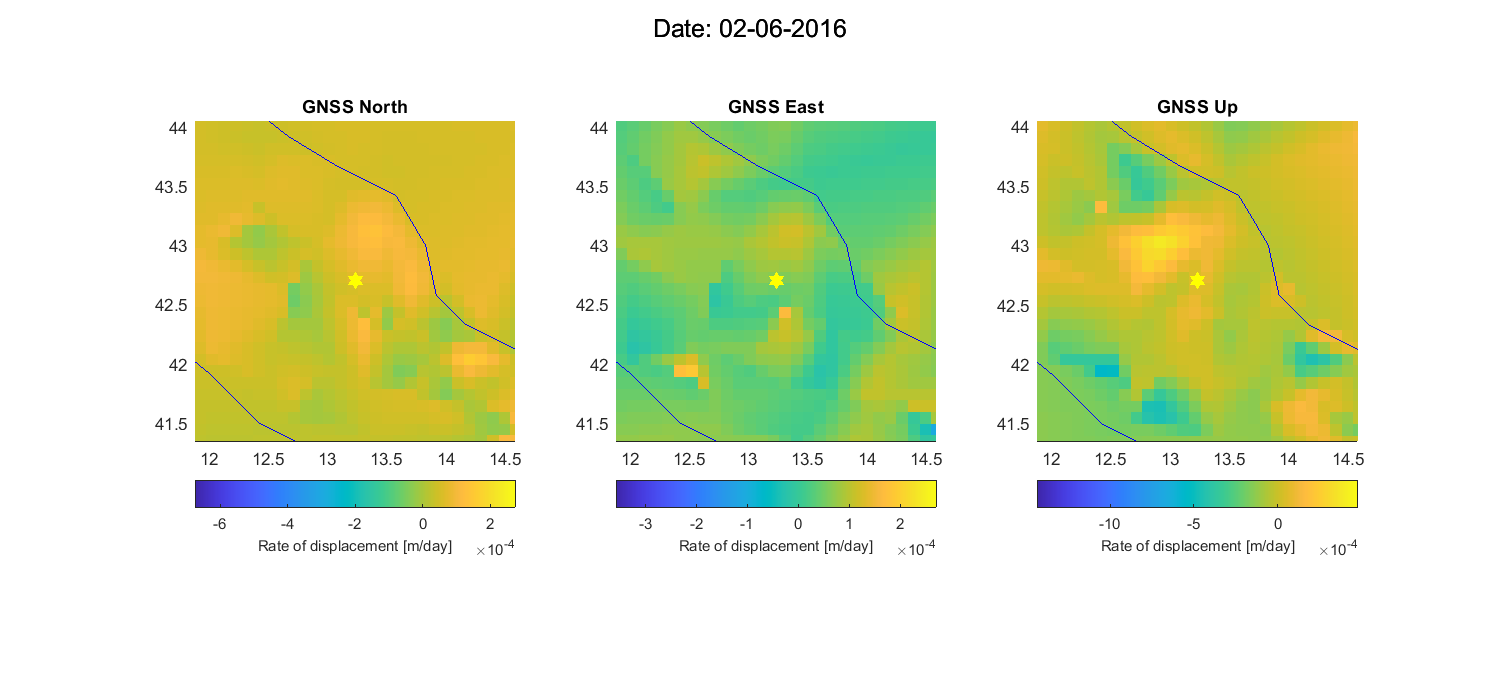

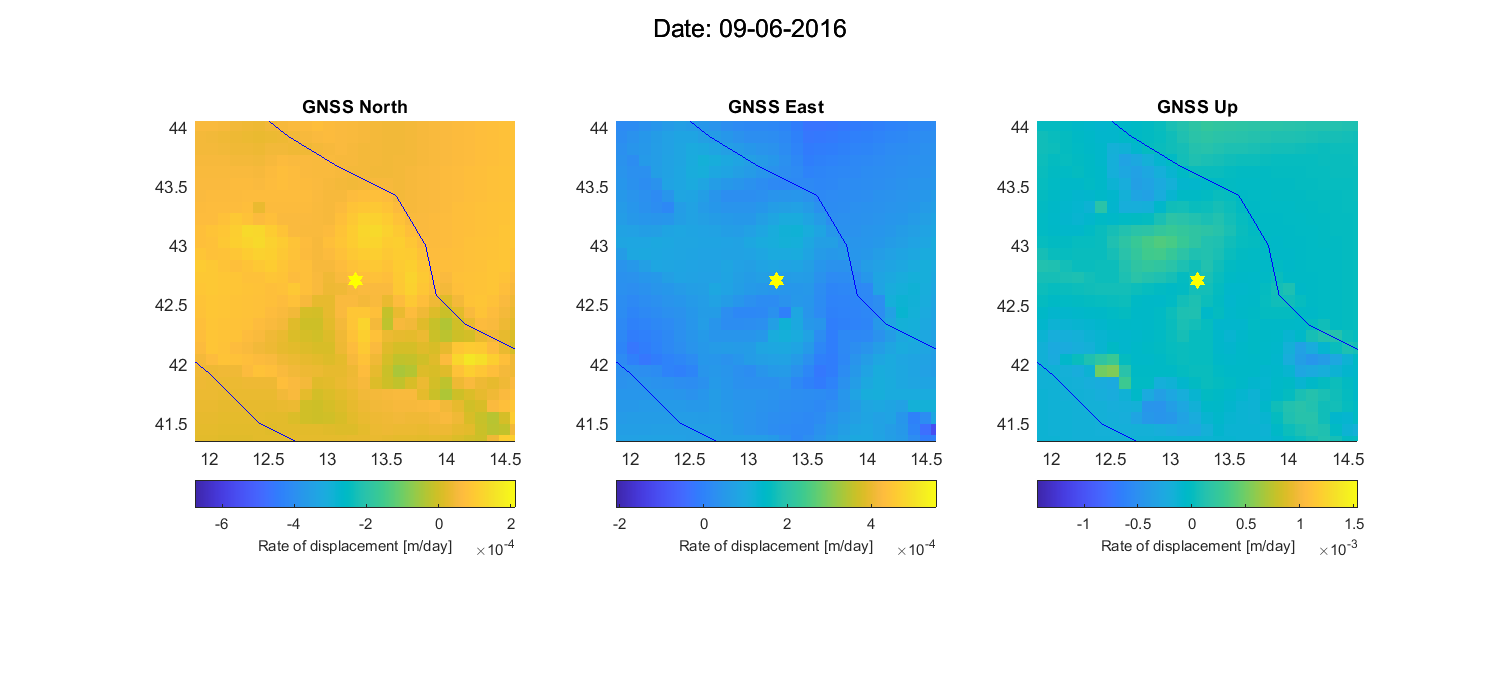

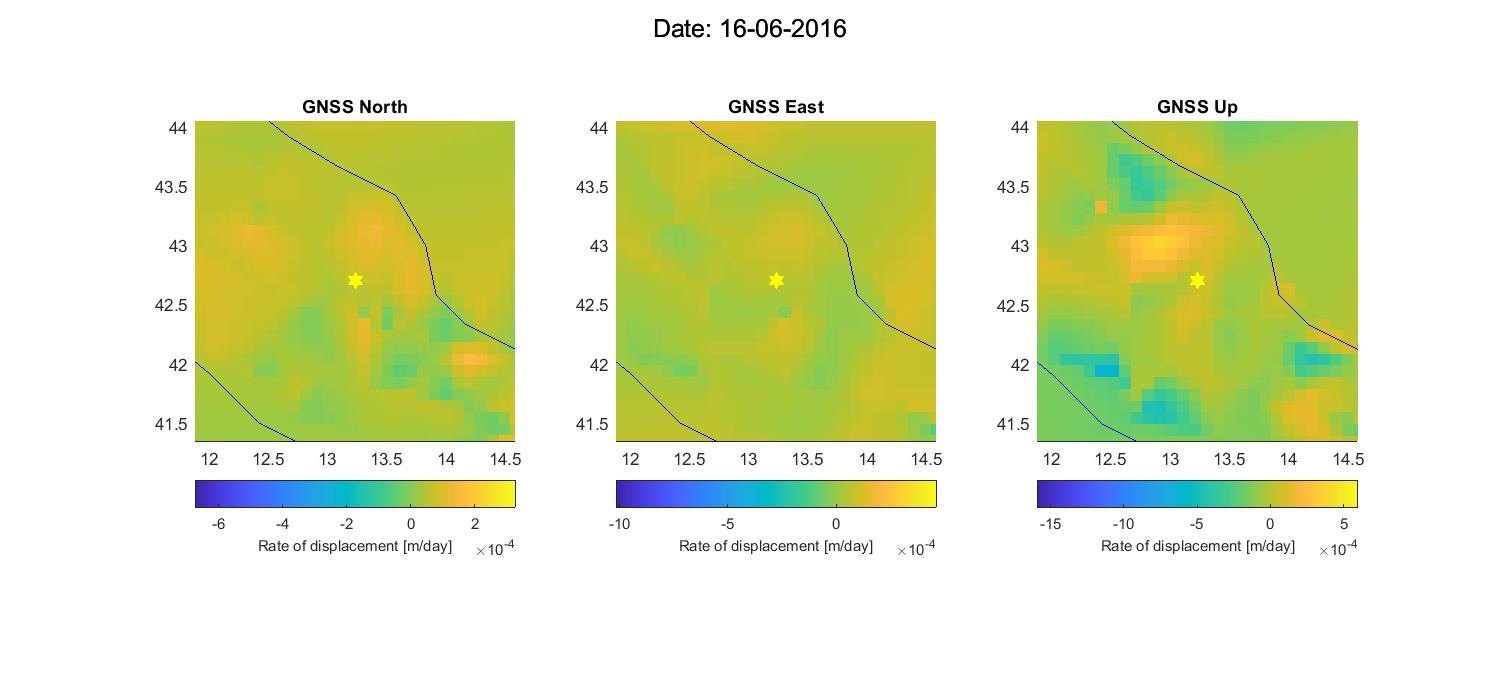

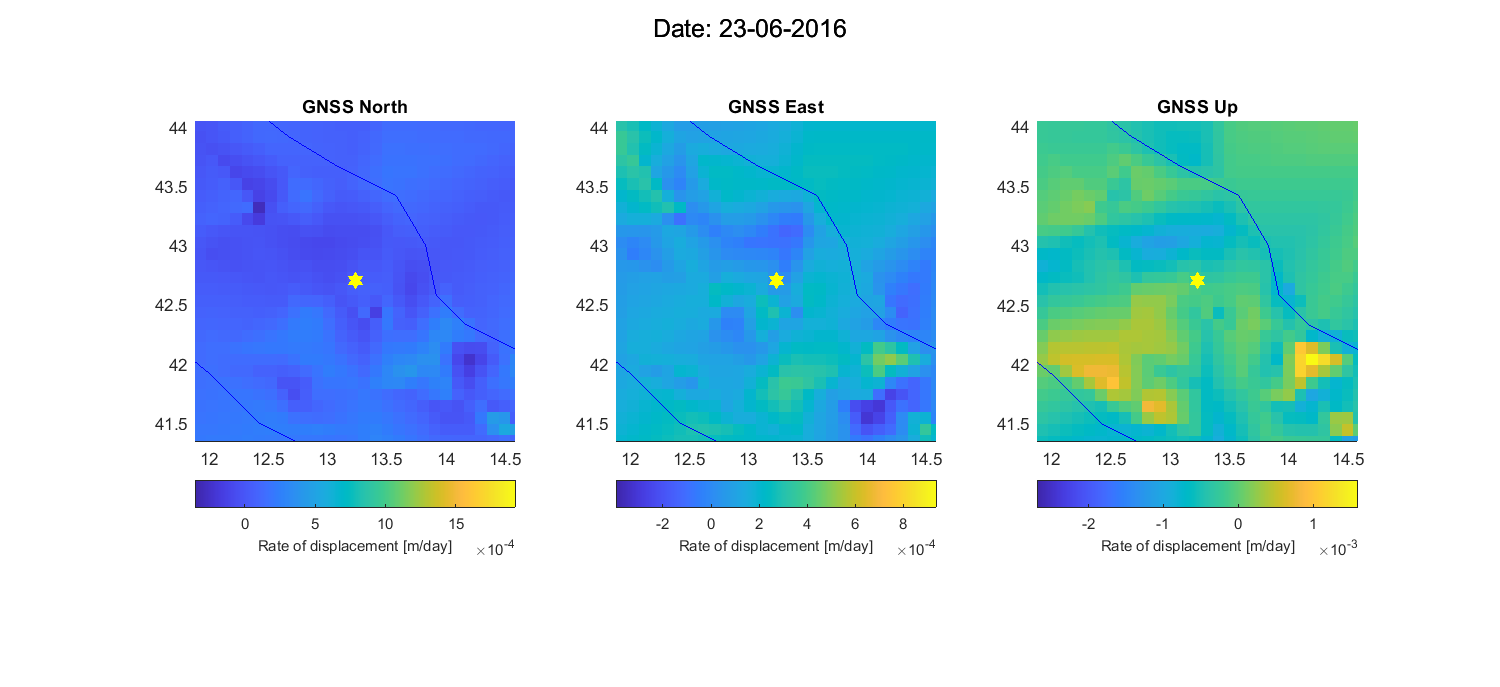

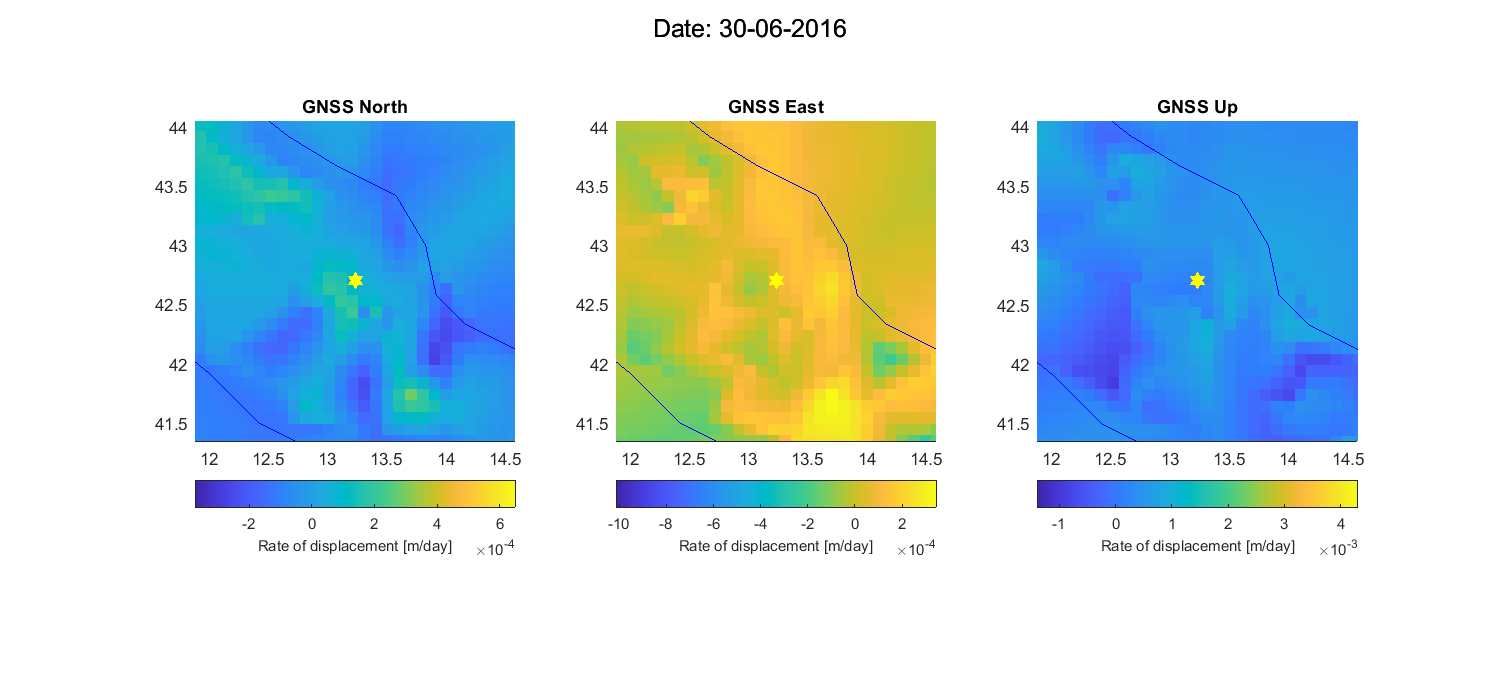

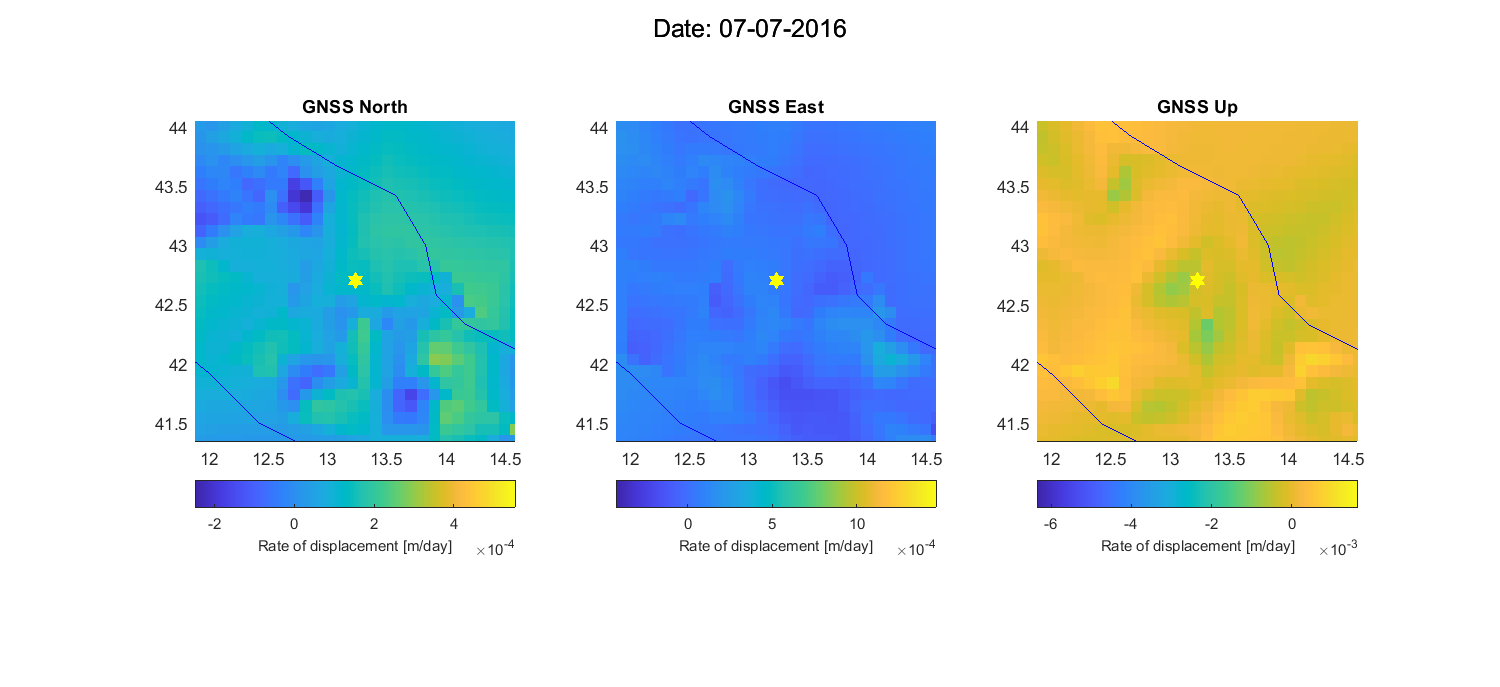

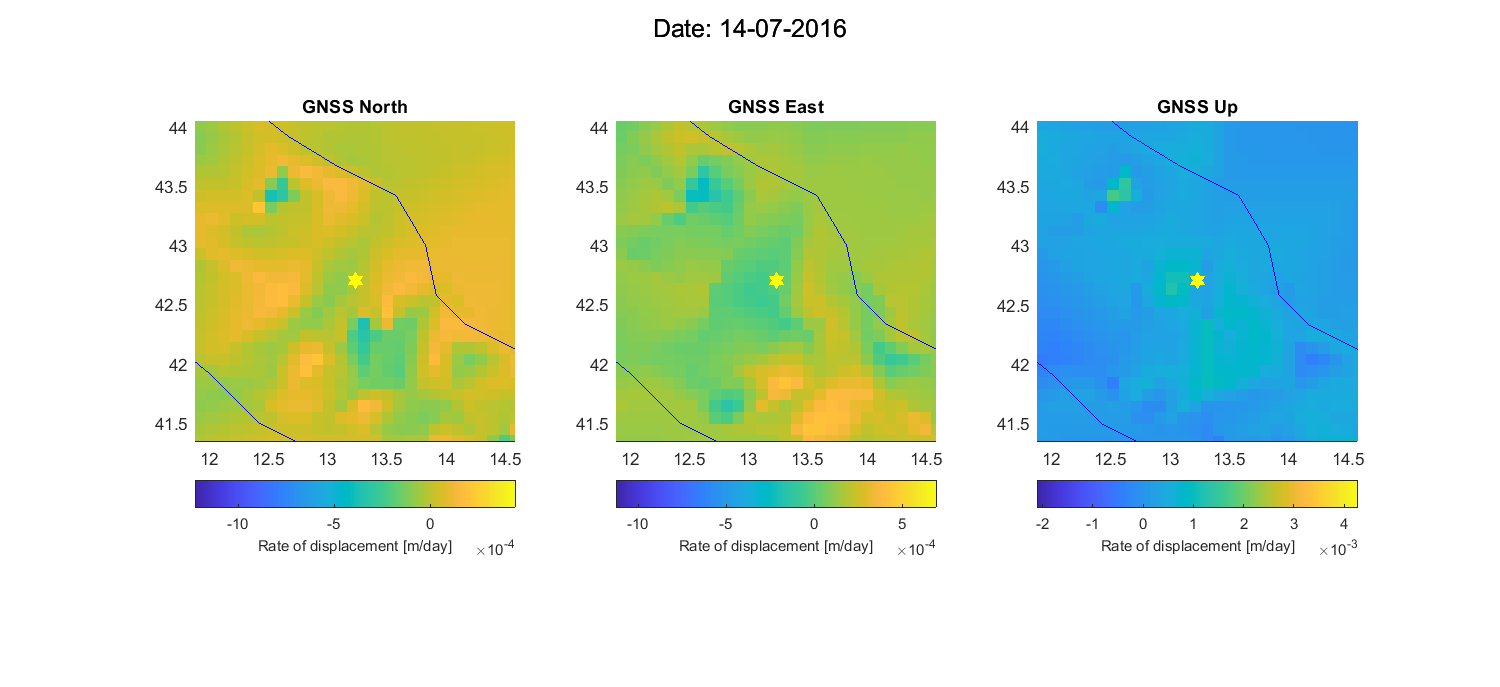

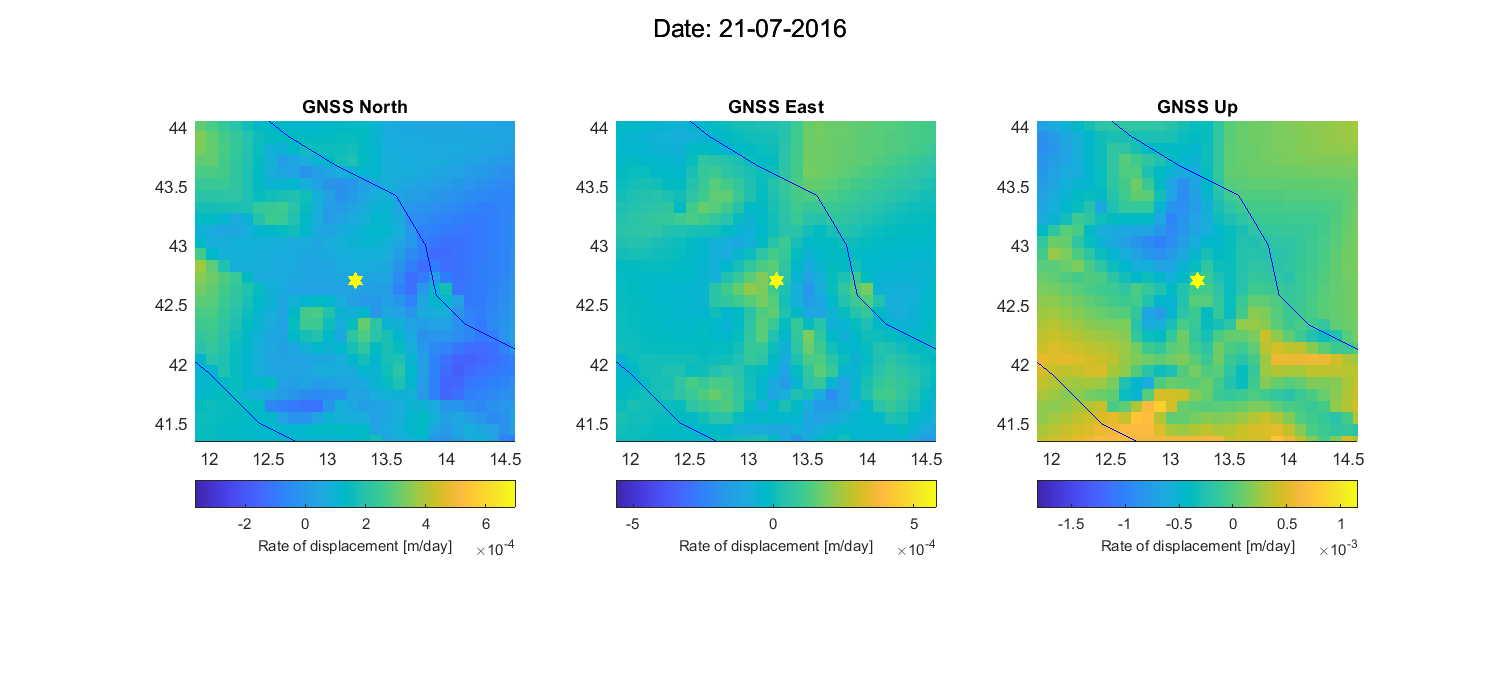

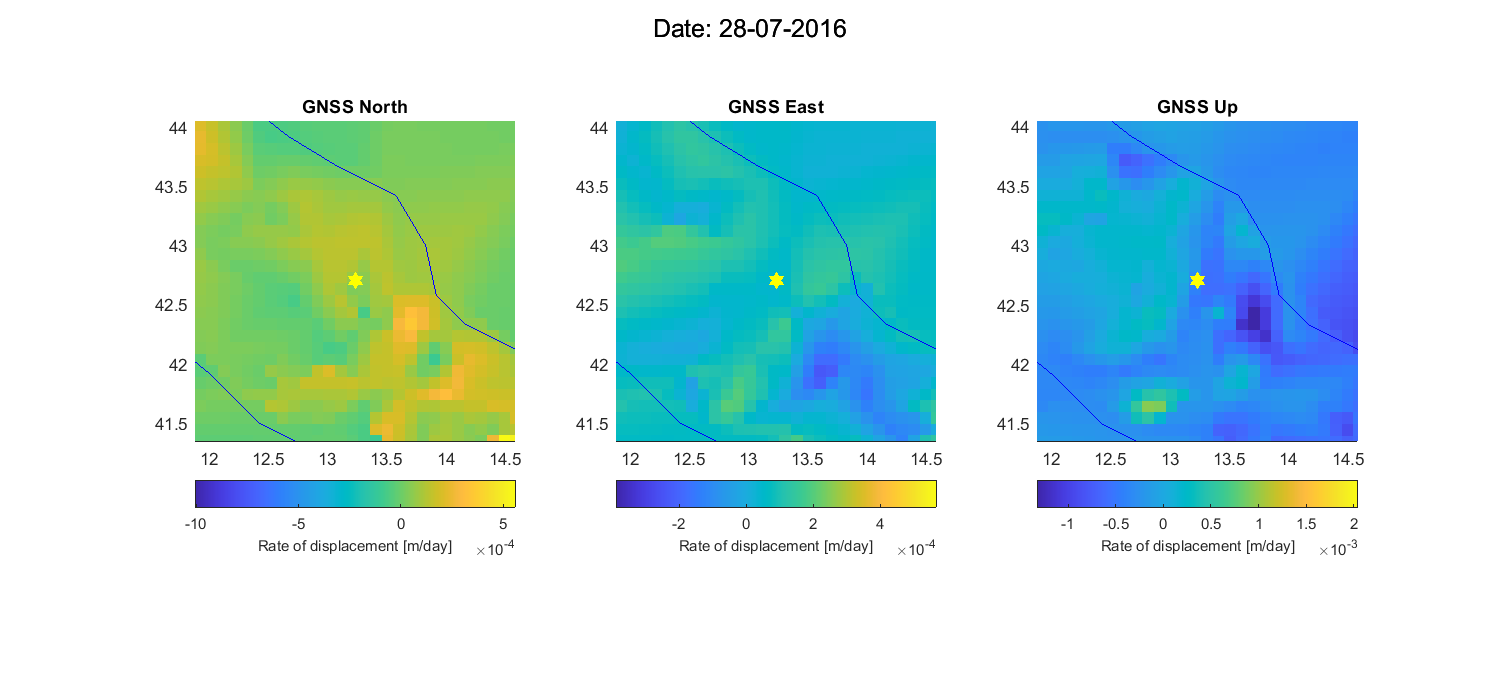

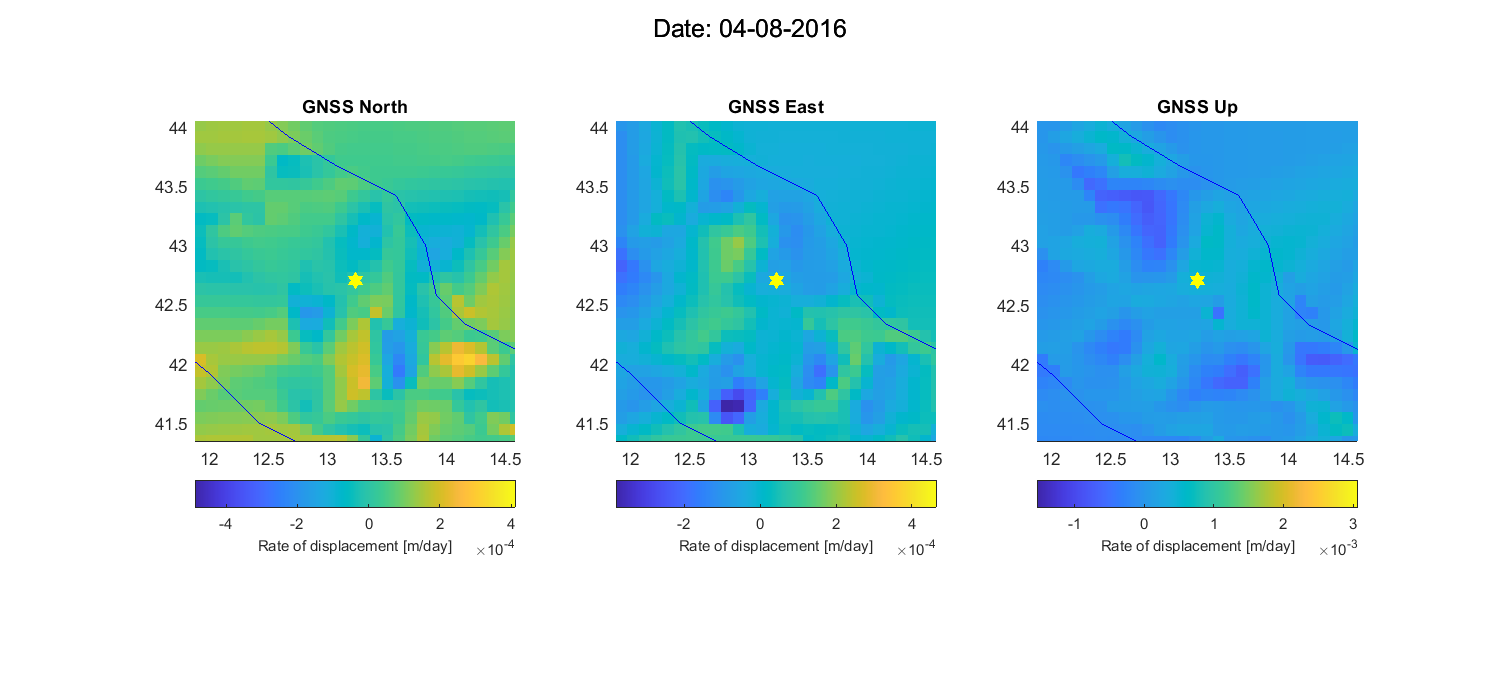

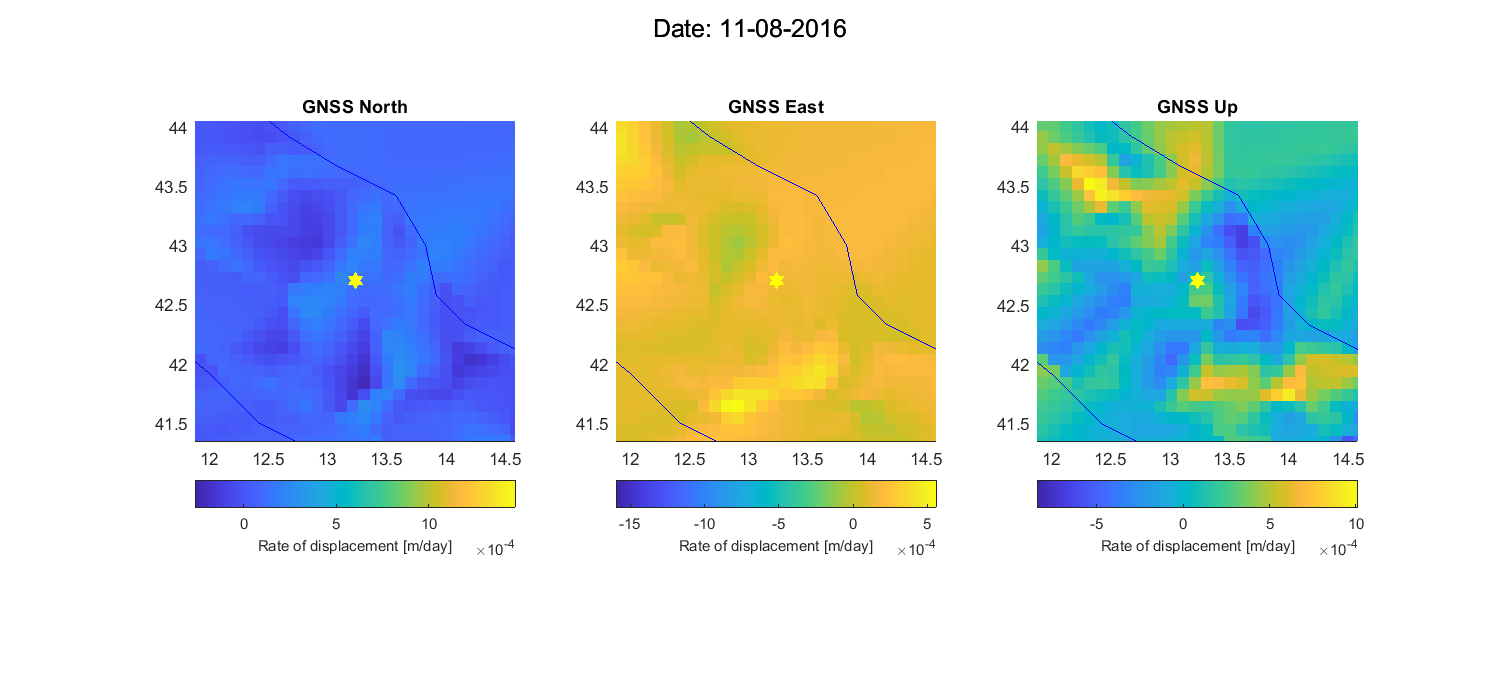

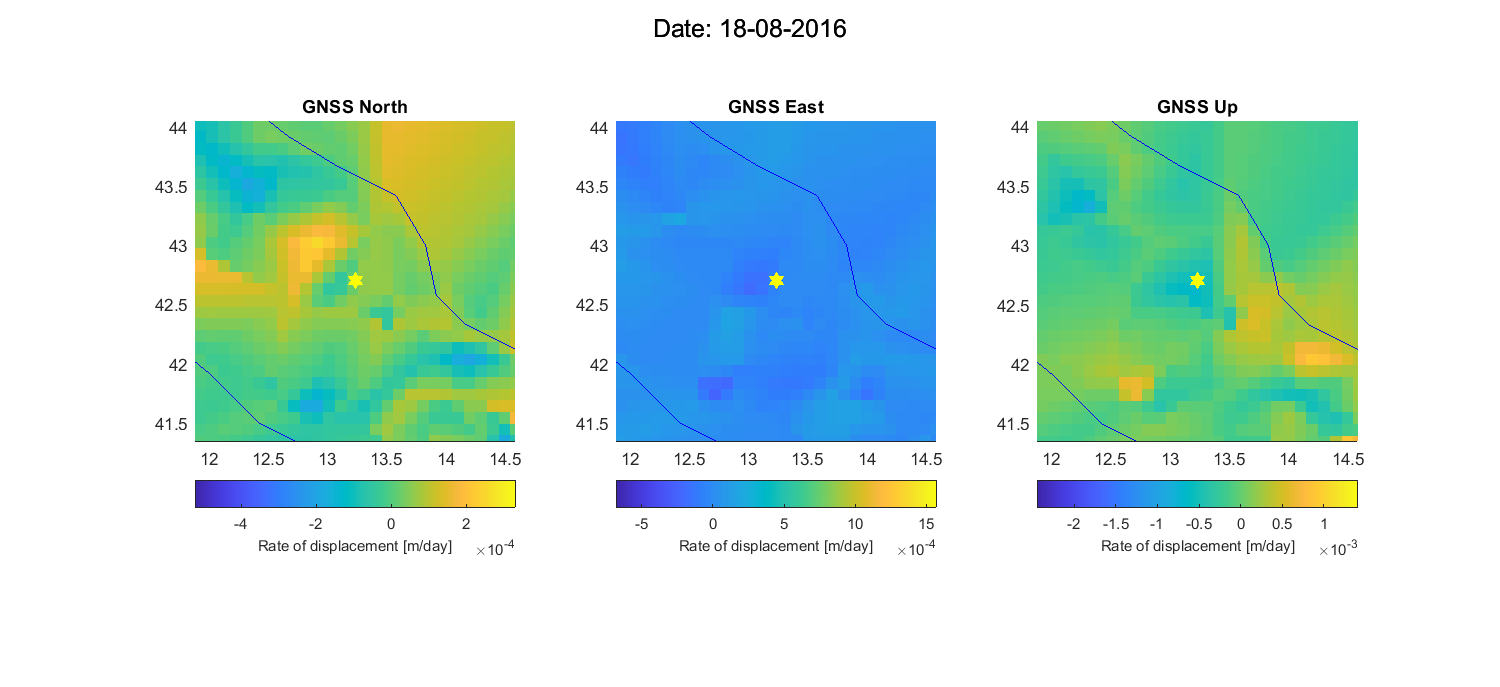

In [10]:
GNSS_timestamp = nan(size(data_from_GNSS, 1)*30,1);
k = 1;
for i = 1:size(data_from_GNSS, 1)
    timestamp_1 = data_from_GNSS{i}.data(:,1);
    GNSS_timestamp(k:k+size(timestamp_1,1)-1) = timestamp_1;
    k = k + size(timestamp_1,1);
end
GNSS_timestamp = GNSS_timestamp(1:k-1);
GNSS_timestamp = unique(GNSS_timestamp);

GNSS_all_data = nan(size(GNSS_timestamp,1), size(data_from_GNSS, 1), 3);
for i = 1:size(data_from_GNSS,1)
    GNSS_station_1 = data_from_GNSS{i}.data;
    time_stamp_station = GNSS_station_1(:,1);
    for k = 1:size(GNSS_timestamp,1)
        data_to_be_assigned = GNSS_station_1(time_stamp_station == GNSS_timestamp(k),2:4);
        if size(data_to_be_assigned,1)>0
            GNSS_all_data(k,i,:) =data_to_be_assigned;
        end
    end
end

%filling missing values with interpolated values
% for k = 2:size(GNSS_timestamp,1)-1
%    for i = 1:size(data_from_GNSS,1)
%        for j = 1:3
%            if isnan(GNSS_all_data(k,i,j))
%                previous_data = GNSS_all_data(k-1,i,j);
%                next_data = GNSS_all_data(k+1,i,j);
%                if isfinite(previous_data) && isfinite(next_data)
%                    GNSS_all_data(k,i,j) = interp1([GNSS_timestamp(k-1), GNSS_timestamp(k+1)], [previous_data, next_data], GNSS_timestamp(k), 'linear'); 
%                end
%            end
%        end
%    end
% end

station_good = nan(size(data_from_GNSS,1), 1);
station_coordinates = nan(size(data_from_GNSS,1), 2);
for i = 1:size(data_from_GNSS,1)
    if sum(isnan(GNSS_all_data(:,i,1)) | GNSS_all_data(:,i,1) == 0) >= size(GNSS_all_data,1) - 1
        station_good(i,1) = 0;
    else
        station_good(i,1) = 1;
    end
    station_coordinates(i,1:2) = data_from_GNSS{i}.coordinates;
end
GNSS_all_data = GNSS_all_data(:, station_good == 1, :);
station_coordinates = station_coordinates(station_good == 1, :);

for i = 1:size(GNSS_all_data,2)
    for j = 1:3
        data_to_be_analysed = GNSS_all_data(:,i,j);
        time_of_data_to_be_analysed = GNSS_timestamp(isfinite(data_to_be_analysed));
        data_to_be_analysed = data_to_be_analysed(isfinite(data_to_be_analysed));
        data_interpolated = interp1(time_of_data_to_be_analysed, data_to_be_analysed, GNSS_timestamp, 'linear');
        GNSS_all_data(:,i,j) = data_interpolated;
    end
end

min_lat_GNSS = min(station_coordinates(:,2));
max_lat_GNSS = max(station_coordinates(:,2));
min_lon_GNSS = min(station_coordinates(:,1));
max_lon_GNSS = max(station_coordinates(:,1));
resolution_GNSS = 0.1; %Resolution of maps from GNSS data

lon_vector = min_lon_GNSS:resolution_GNSS:max_lon_GNSS;
lat_vector = min_lat_GNSS:resolution_GNSS:max_lat_GNSS;
[grid_LAT, grid_LON] = meshgrid(lat_vector, lon_vector);
load coastlines;

GNSS_all_data_diff = diff(GNSS_all_data, 1, 1);
GNSS_timestamp_diff = GNSS_timestamp(1:end-1)/2 + GNSS_timestamp(2:end)/2;
for i = 1:size(GNSS_all_data_diff,1)
    GNSS_all_data_diff(i,:,:) = GNSS_all_data_diff(i,:,:) ./ (GNSS_timestamp(i+1)-GNSS_timestamp(i));
    data_for_map = reshape(GNSS_all_data_diff(i,:,:), size(GNSS_all_data_diff, 2), size(GNSS_all_data_diff, 3));
    station_coordinates_p = station_coordinates(isfinite(data_for_map(:,1)), :);
    data_for_map = data_for_map(isfinite(data_for_map(:,1)), :);
    F_N = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,1));
    F_E = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,2));
    F_U = scatteredInterpolant(station_coordinates_p(:,2), station_coordinates_p(:,1), data_for_map(:,3));
    interpolated_data_N = F_N(grid_LAT, grid_LON);
    interpolated_data_E = F_E(grid_LAT, grid_LON);
    interpolated_data_U = F_U(grid_LAT, grid_LON);
    figure('Position', [1 1 1200 550])
    subplot(1,3,1)
    geoshow(grid_LAT, grid_LON, interpolated_data_N, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b');
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y');
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
    title('GNSS North');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,2)
    geoshow(grid_LAT, grid_LON, interpolated_data_E, 'DisplayType', 'texturemap');
    hold on;
    plot(coastlon, coastlat, '-b');
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y');
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
    title('GNSS East');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    subplot(1,3,3)
    geoshow(grid_LAT, grid_LON, interpolated_data_U, 'DisplayType', 'texturemap');
    hold on
    plot(coastlon, coastlat, '-b');
    plot(epilon, epilat, 'hy', 'MarkerSize', 10, 'MarkerFaceColor', 'y');
    axis([epilon-Maximum_distance/111 epilon+Maximum_distance/111 epilat-Maximum_distance/111 epilat+Maximum_distance/111]); 
    title('GNSS Up');
    h = colorbar('southoutside');
    xlabel(h, 'Rate of displacement [m/day]');
    sgtitle(['Date: ', datestr(GNSS_timestamp_diff(i), 'dd-mm-yyyy')]);
end



# Geomagnetic ground observatories

The geomagnetic field at Earth's surface is monitored by a network of geomagnetic ground observatories. In this section, the Intermagnet data from TCS Geomagnetic Ground Observatories of EPOS is analysed. 

In [11]:
weburl_to_retrive_the_data = "https://wdcapi.bgs.ac.uk/metadata/epos-geojson/?provider=intermagnet";
Intermagnet_station_list = webread(weburl_to_retrive_the_data);
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
if size(Intermagnet_station_list,1) > 0
    current_web_options = weboptions;
    current_web_options.Timeout = 60*5;
    Intermagnet_station_list = Intermagnet_station_list.features;
    station_name  = {};
    station_coordinates = nan(size(Intermagnet_station_list,1), 2);
    for i=1:size(Intermagnet_station_list,1)
        station_name{i,1} = Intermagnet_station_list(i).properties.iaga_code;
        station_coordinates(i,:) = Intermagnet_station_list(i).geometry.coordinates;
    end

    distance_to_target_EQ = distance(station_coordinates(:,2),station_coordinates(:,1), epilat, epilon);
    [distance_closer_station, closer_station] = min(distance_to_target_EQ);
    stations_inside_r_Dob = find(distance_to_target_EQ <= radius_Dobrovolsky);
    stations_outside_r_Dob = find(distance_to_target_EQ > radius_Dobrovolsky & distance_to_target_EQ <= 2 * radius_Dobrovolsky);
    figure
    worldmap([epilat-2*radius_Dobrovolsky-5 epilat+2*radius_Dobrovolsky+5],[epilon-2*radius_Dobrovolsky-5 epilon+2*radius_Dobrovolsky+5])
    load coastlines;
    geoshow("landAreas.shp"); %geoshow(coastlat, coastlon);
    hold on;
    geoshow(station_coordinates(stations_inside_r_Dob,2), station_coordinates(stations_inside_r_Dob,1), 'DisplayType','point', 'Color', 'r');
    geoshow(station_coordinates(stations_outside_r_Dob,2), station_coordinates(stations_outside_r_Dob,1), 'DisplayType','point', 'Color', 'b');
    [aas,bbs]=scircle1(epilat,epilon,radius_Dobrovolsky);
    geoshow(aas, bbs, 'DisplayType','line', 'Color', 'g');
    legend('', 'Stations inside Dobrovolsky', 'Stations outside Dobrovolsky', 'Dobrovolsky', 'Location','bestoutside');

%It's necessary to have at least one station inside the research area and a minimum two stations to interpolate the value at the target staion.
    if size(stations_inside_r_Dob, 1) > 0 && size(stations_outside_r_Dob,1) > 1
        EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
        time_start = EQ_time - day_before;
        [year_start, month_start, day_start] = datevec(time_start);
        time_end = EQ_time + day_after + 1; %+1 is necesssary becuase the requests end at 00:00 of the following end day
        [year_end, month_end, day_end] = datevec(time_end);
        for i=1:size(stations_inside_r_Dob, 1)
            try
                weburl_to_retrive_the_data = ['https://imag-data.bgs.ac.uk/GIN_V1/GINServices?request=GetData&recordTermination=native&traceList=1234&colourTraces=True&observatoryIagaCode=', station_name{stations_inside_r_Dob(i)}, '&SamplesPerDay=Minute&dataStartDate=', num2str(year_start), '-', num2str(month_start, '%02.0f'), '-', num2str(day_start, '%02.0f'), '&dataEndDate=', num2str(year_end), '-', num2str(month_end, '%02.0f'), '-', num2str(day_end, '%02.0f'), '&publicationState=adj-or-rep&Format=json'];
                Geomagnetic_data = webread(weburl_to_retrive_the_data, current_web_options);
                GEOMAG_inside_r_Dob(i).IAGA_name = Geomagnetic_data.x_info.iaga_code;
                GEOMAG_inside_r_Dob(i).latitude = Geomagnetic_data.x_info.latitude;
                GEOMAG_inside_r_Dob(i).longitude = Geomagnetic_data.x_info.longitude;
                GEOMAG_inside_r_Dob(i).altitude = Geomagnetic_data.x_info.altitude;
                GEOMAG_inside_r_Dob(i).time = datetime(Geomagnetic_data.datetime, 'InputFormat', 'yyyy-MM-dd''T''HH:mm:ss.SSS''Z');
                GEOMAG_inside_r_Dob(i).X = Geomagnetic_data.X;
                GEOMAG_inside_r_Dob(i).Y = Geomagnetic_data.Y;
                GEOMAG_inside_r_Dob(i).Z = Geomagnetic_data.Z;
            catch request_exception
                disp(request_exception)
                station_name{stations_inside_r_Dob(i)}
            end
        end
        for i=1:size(stations_outside_r_Dob, 1)
            try
                weburl_to_retrive_the_data = ['https://imag-data.bgs.ac.uk/GIN_V1/GINServices?request=GetData&recordTermination=native&traceList=1234&colourTraces=True&observatoryIagaCode=', station_name{stations_outside_r_Dob(i)}, '&SamplesPerDay=Minute&dataStartDate=', num2str(year_start), '-', num2str(month_start, '%02.0f'), '-', num2str(day_start, '%02.0f'), '&dataEndDate=', num2str(year_end), '-', num2str(month_end, '%02.0f'), '-', num2str(day_end, '%02.0f'), '&publicationState=adj-or-rep&Format=json'];
                Geomagnetic_data = webread(weburl_to_retrive_the_data, current_web_options);
                GEOMAG_outside_r_Dob(i).IAGA_name = Geomagnetic_data.x_info.iaga_code;
                GEOMAG_outside_r_Dob(i).latitude = Geomagnetic_data.x_info.latitude;
                GEOMAG_outside_r_Dob(i).longitude = Geomagnetic_data.x_info.longitude;
                GEOMAG_outside_r_Dob(i).altitude = Geomagnetic_data.x_info.altitude;
                GEOMAG_outside_r_Dob(i).time = datetime(Geomagnetic_data.datetime, 'InputFormat', 'yyyy-MM-dd''T''HH:mm:ss.SSS''Z');
                GEOMAG_outside_r_Dob(i).X = Geomagnetic_data.X;
                GEOMAG_outside_r_Dob(i).Y = Geomagnetic_data.Y;
                GEOMAG_outside_r_Dob(i).Z = Geomagnetic_data.Z;
            catch request_exception
                disp(request_exception)
                station_name{stations_outside_r_Dob(i)}
            end

        end
        GEOMAG_inside_r_Dob_1 = GEOMAG_inside_r_Dob;
        clear GEOMAG_inside_r_Dob;
        k = 1;
        for i=1:size(GEOMAG_inside_r_Dob_1, 2)
            if sum(isfinite(GEOMAG_inside_r_Dob_1(i).X)) > 5 && sum(isfinite(GEOMAG_inside_r_Dob_1(i).Y)) > 5 && sum(isfinite(GEOMAG_inside_r_Dob_1(i).Z)) > 5
                GEOMAG_inside_r_Dob(k) = GEOMAG_inside_r_Dob_1(i);
                k = k + 1;
            end
        end
        GEOMAG_outside_r_Dob_1 = GEOMAG_outside_r_Dob;
        clear GEOMAG_outside_r_Dob;
        k = 1;
        for i=1:size(GEOMAG_outside_r_Dob_1, 2)
            if sum(isfinite(GEOMAG_outside_r_Dob_1(i).X)) > 5 && sum(isfinite(GEOMAG_outside_r_Dob_1(i).Y)) > 5 && sum(isfinite(GEOMAG_outside_r_Dob_1(i).Z)) > 5
                GEOMAG_outside_r_Dob(k) = GEOMAG_outside_r_Dob_1(i);
                k = k + 1;
            end
        end
        save("Geomagnetic_ground_data.mat", 'GEOMAG_inside_r_Dob', "GEOMAG_outside_r_Dob");
    end
end

Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

In [12]:
%check the altitude information in the retrieved data
for i=1:size(GEOMAG_inside_r_Dob, 2)
    if GEOMAG_inside_r_Dob(i).altitude == 0
        disp(['The altitude of ', GEOMAG_inside_r_Dob(i).IAGA_name, ' geomagnetic observatory is equal to 0 m.a.s.l. Check if this is right. The array index of this observatory is ', num2str(i), '.']);
    end
end
for i=1:size(GEOMAG_outside_r_Dob, 2)
    if GEOMAG_outside_r_Dob(i).altitude == 0
        disp(['The altitude of ', GEOMAG_outside_r_Dob(i).IAGA_name, ' geomagnetic observatory is equal to 0 m.a.s.l. Check if this is right. The array index of this observatory is ', num2str(i), '.']);
    end
end

The altitude of DUR geomagnetic observatory is equal to 0 m.a.s.l. Check if this is right. The array index of this observatory is 4.
The altitude of PEG geomagnetic observatory is equal to 0 m.a.s.l. Check if this is right. The array index of this observatory is 2.


In [ ]:
GEOMAG_inside_r_Dob(4).altitude = 920; %Set the proper altitude of Duronia (Italy) observatory as listed in https://intermagnet.org/metadata/#/imos
GEOMAG_outside_r_Dob(2).altitude = 380; %Set the proper altitude of Pedeli (Greece) observatory as listed in https://intermagnet.org/metadata/#/imos
save("Geomagnetic_ground_data.mat", 'GEOMAG_inside_r_Dob', "GEOMAG_outside_r_Dob");

Executing ...

## Subtraction of IGRF geomagnetic model  
In order to remove the main geomagnetic field, a model is subtracted.  
From EPOS data portal, TCS Geomagnetic the IGRF model is available, so it's retrieved for each station and subtracted from the data.

In [4]:
%Second part to subtract the IGRF model
load("Geomagnetic_ground_data.mat");
for i=1:size(GEOMAG_inside_r_Dob, 2)
    lat_station = GEOMAG_inside_r_Dob(i).latitude;
    lon_station = GEOMAG_inside_r_Dob(i).longitude;
    % EPOS IGRF expect altitude in km, while the previous data are in meters
    alt_station = GEOMAG_inside_r_Dob(i).altitude/1000;
    time_station = GEOMAG_inside_r_Dob(i).time;
    times_first_data = time_station(1);
    times_last_data = time_station(end);
    %we generated a time vector with 10 elements equispaced in the analysed
    %interval. This is due to the fact that IGRF model not take into account fast geomagnetic field variations and 
    % only the slow changing of geomagnetic field such as the secular variations
    time_vector = (linspace(times_first_data,times_last_data,10))';
    IGRF_data_X = nan(length(time_vector),1);
    IGRF_data_Y = nan(length(time_vector),1);
    IGRF_data_Z = nan(length(time_vector),1);
    for time_i = 1:length(time_vector)
        url_to_retrieve_IGRF = ['https://geomag.bgs.ac.uk/web_service/GMModels/igrf/13?latitude=', num2str(lat_station), '&longitude=', num2str(lon_station), '&altitude=', num2str(alt_station), '&date=', datestr(time_vector(time_i), 'yyyy-mm-dd'),  '&format=json'];
        IGRF_data = webread(url_to_retrieve_IGRF);
        IGRF_data_X(time_i,1) = IGRF_data.geomagnetic_field_model_result.field_value.north_intensity.value;
        IGRF_data_Y(time_i,1) = IGRF_data.geomagnetic_field_model_result.field_value.east_intensity.value;
        IGRF_data_Z(time_i,1) = IGRF_data.geomagnetic_field_model_result.field_value.vertical_intensity.value;
    end
    IGRF_data_X_1 = interp1(time_vector, IGRF_data_X, time_station);
    IGRF_data_Y_1 = interp1(time_vector, IGRF_data_Y, time_station);
    IGRF_data_Z_1 = interp1(time_vector, IGRF_data_Z, time_station);
    GEOMAG_inside_r_Dob(i).X = GEOMAG_inside_r_Dob(i).X - IGRF_data_X_1;
    GEOMAG_inside_r_Dob(i).Y = GEOMAG_inside_r_Dob(i).Y - IGRF_data_Y_1;
    GEOMAG_inside_r_Dob(i).Z = GEOMAG_inside_r_Dob(i).Z - IGRF_data_Z_1;
end

for i=1:size(GEOMAG_outside_r_Dob, 2)
    lat_station = GEOMAG_outside_r_Dob(i).latitude;
    lon_station = GEOMAG_outside_r_Dob(i).longitude;
    % EPOS IGRF expect altitude in km, while the previous data are in meters
    alt_station = GEOMAG_outside_r_Dob(i).altitude/1000;
    time_station = GEOMAG_outside_r_Dob(i).time;
    times_first_data = time_station(1);
    times_last_data = time_station(end);
    %we generated a time vector with 10 elements equispaced in the analysed
    %interval. This is due to the fact that IGRF model not take into account fast geomagnetic field variations and 
    % only the slow changing of geomagnetic field such as the secular variations
    time_vector = (linspace(times_first_data,times_last_data,10))';
    IGRF_data_X = nan(length(time_vector),1);
    IGRF_data_Y = nan(length(time_vector),1);
    IGRF_data_Z = nan(length(time_vector),1);
    for time_i = 1:length(time_vector)
        url_to_retrieve_IGRF = ['https://geomag.bgs.ac.uk/web_service/GMModels/igrf/13?latitude=', num2str(lat_station), '&longitude=', num2str(lon_station), '&altitude=', num2str(alt_station), '&date=', datestr(time_vector(time_i), 'yyyy-mm-dd'),  '&format=json'];
        IGRF_data = webread(url_to_retrieve_IGRF);
        IGRF_data_X(time_i,1) = IGRF_data.geomagnetic_field_model_result.field_value.north_intensity.value;
        IGRF_data_Y(time_i,1) = IGRF_data.geomagnetic_field_model_result.field_value.east_intensity.value;
        IGRF_data_Z(time_i,1) = IGRF_data.geomagnetic_field_model_result.field_value.vertical_intensity.value;
    end
    IGRF_data_X_1 = interp1(time_vector, IGRF_data_X, time_station);
    IGRF_data_Y_1 = interp1(time_vector, IGRF_data_Y, time_station);
    IGRF_data_Z_1 = interp1(time_vector, IGRF_data_Z, time_station);
    GEOMAG_outside_r_Dob(i).X = GEOMAG_outside_r_Dob(i).X - IGRF_data_X_1;
    GEOMAG_outside_r_Dob(i).Y = GEOMAG_outside_r_Dob(i).Y - IGRF_data_Y_1;
    GEOMAG_outside_r_Dob(i).Z = GEOMAG_outside_r_Dob(i).Z - IGRF_data_Z_1;
end
save("Geomagnetic_ground_data_residual.mat", 'GEOMAG_inside_r_Dob', "GEOMAG_outside_r_Dob");

The following lines analyses the geomagnetic ground data downloaded in the previous step.

In [5]:
load("Geomagnetic_ground_data_residual.mat");

%The following code prepare the data of the outside station in a matrix
%with time in row and station id in columns
time_station_out = GEOMAG_outside_r_Dob(1).time;
X_outside = nan(size(time_station_out,1), size(GEOMAG_outside_r_Dob,2));
Y_outside = nan(size(time_station_out,1), size(GEOMAG_outside_r_Dob,2));
Z_outside = nan(size(time_station_out,1), size(GEOMAG_outside_r_Dob,2));
for t_i = 1:size(time_station_out,1)
    for station = 1:size(GEOMAG_outside_r_Dob,2)
        X_outside(t_i,station) = GEOMAG_outside_r_Dob(station).X(t_i);
        Y_outside(t_i,station) = GEOMAG_outside_r_Dob(station).Y(t_i);
        Z_outside(t_i,station) = GEOMAG_outside_r_Dob(station).Z(t_i);
    end
end

lat_outside = nan(size(GEOMAG_outside_r_Dob,2), 1);
lon_outside = nan(size(GEOMAG_outside_r_Dob,2), 1);
alt_outside = nan(size(GEOMAG_outside_r_Dob,2), 1);

for station = 1:size(GEOMAG_outside_r_Dob,2)
    lat_outside(station, 1) = GEOMAG_outside_r_Dob(station).latitude;
    lon_outside(station, 1) = GEOMAG_outside_r_Dob(station).longitude;
    alt_outside(station, 1) = GEOMAG_outside_r_Dob(station).altitude;
end

lat_station = nan(size(GEOMAG_inside_r_Dob, 2), 1);
lon_station = nan(size(GEOMAG_inside_r_Dob, 2), 1);
alt_station = nan(size(GEOMAG_inside_r_Dob, 2), 1);
for i=1:size(GEOMAG_inside_r_Dob ,2)
    
    lat_station(i,1) = GEOMAG_inside_r_Dob(i).latitude;
    lon_station(i,1) = GEOMAG_inside_r_Dob(i).longitude;
    alt_station(i,1) = GEOMAG_inside_r_Dob(i).altitude;
end

### Important note: the following cell perform an interpolation of the closer data.  
An alternative approach with a surface fitting is presented in the following cell.

In [15]:
X_interpolated = nan(size(time_station_out,1), size(GEOMAG_inside_r_Dob ,2));
Y_interpolated = nan(size(time_station_out,1), size(GEOMAG_inside_r_Dob ,2));
Z_interpolated = nan(size(time_station_out,1), size(GEOMAG_inside_r_Dob ,2));
parfor t_i = 1:size(time_station_out,1)
    F_X_interp = scatteredInterpolant(lat_outside(isfinite(X_outside(t_i,:))'), lon_outside(isfinite(X_outside(t_i,:))'), alt_outside(isfinite(X_outside(t_i,:))'), (X_outside(t_i, isfinite(X_outside(t_i,:))))', "natural", "linear");
    X_interpolated(t_i,:) = (F_X_interp(lat_station, lon_station, alt_station))';
    F_Y_interp = scatteredInterpolant(lat_outside(isfinite(Y_outside(t_i,:))'), lon_outside(isfinite(Y_outside(t_i,:))'), alt_outside(isfinite(Y_outside(t_i,:))'), (Y_outside(t_i, isfinite(Y_outside(t_i,:))))', "natural", "linear");
    Y_interpolated(t_i,:) = (F_Y_interp(lat_station, lon_station, alt_station))';
    F_Z_interp = scatteredInterpolant(lat_outside(isfinite(Z_outside(t_i,:))'), lon_outside(isfinite(Z_outside(t_i,:))'), alt_outside(isfinite(Z_outside(t_i,:))'), (Z_outside(t_i, isfinite(Z_outside(t_i,:))))', "natural", "linear");
    Z_interpolated(t_i,:) = (F_Z_interp(lat_station, lon_station, alt_station))';
end
save('Interpolated_data.mat', "X_interpolated", "Y_interpolated", "Z_interpolated");

Starting parallel pool (parpool) using the 'Processes' profile ...
Connected to parallel pool with 6 workers.


The following cell fits a surface of the maximum degree available (max $5^{th}$) in function as the number of avialable stations outside the Dobrovoslky's area. Then, the fit is calculated for at the coordinates of the stations inside the Dobrovoslky's area.

In [6]:
X_interpolated = nan(size(time_station_out,1), size(GEOMAG_inside_r_Dob ,2));
Y_interpolated = nan(size(time_station_out,1), size(GEOMAG_inside_r_Dob ,2));
Z_interpolated = nan(size(time_station_out,1), size(GEOMAG_inside_r_Dob ,2));
%vector with the number of degree-of-freedom for each surface polynomial degree between 0 and 5
degree_dof = [0, 1; 1, 3; 2, 6; 3, 10; 4, 15; 5, 21];
parfor time_i = 1:size(time_station_out,1)
    %the following line s eventual stations with invalid data (Nan or Infinite)
    good_outside_stations = find(isfinite(X_outside(time_i,:)) & isfinite(Y_outside(time_i,:)) & isfinite(Z_outside(time_i,:)));
    number_of_outside_stations = length(good_outside_stations);
    %search for the maximum degree that is possible to fit using the good station selected above.
    temp_index = find(degree_dof(:,2) <= number_of_outside_stations);
    max_degree = degree_dof(temp_index(end),1);
    fit_poly_selected = ['poly', num2str(max_degree, '%d'), num2str(max_degree, '%d')];
    X_fit = fit([lat_outside(good_outside_stations), lon_outside(good_outside_stations)], (X_outside(time_i, good_outside_stations))', fit_poly_selected);
    Y_fit = fit([lat_outside(good_outside_stations), lon_outside(good_outside_stations)], (Y_outside(time_i, good_outside_stations))', fit_poly_selected);
    Z_fit = fit([lat_outside(good_outside_stations), lon_outside(good_outside_stations)], (Z_outside(time_i, good_outside_stations))', fit_poly_selected);
    X_interpolated(time_i,:) = (feval(X_fit, [lat_station, lon_station]))';
    Y_interpolated(time_i,:) = (feval(Y_fit, [lat_station, lon_station]))';
    Z_interpolated(time_i,:) = (feval(Z_fit, [lat_station, lon_station]))';
end
save('Interpolated_data.mat', "X_interpolated", "Y_interpolated", "Z_interpolated");

Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

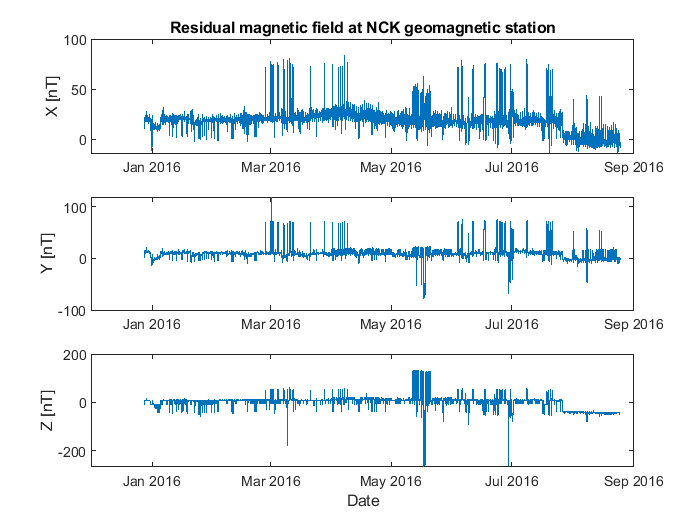

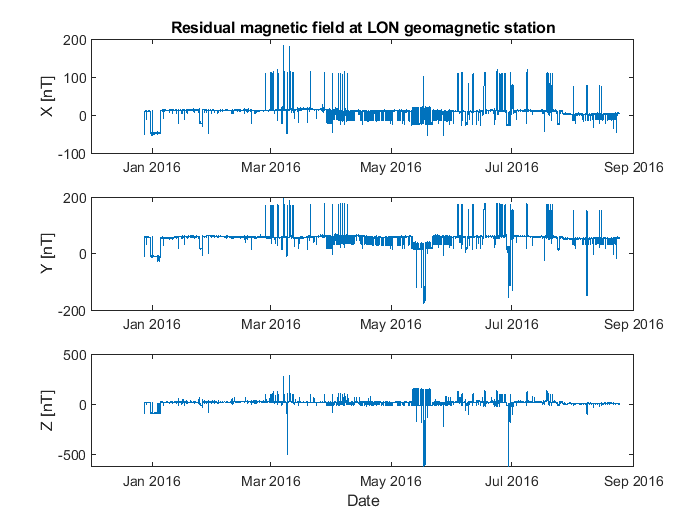

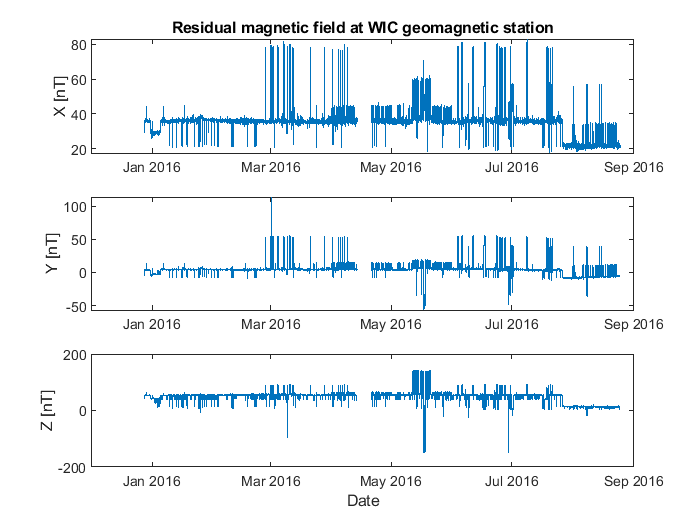

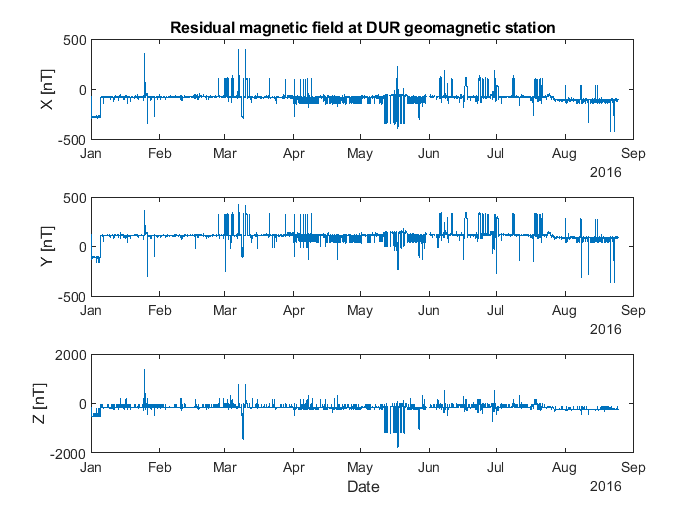

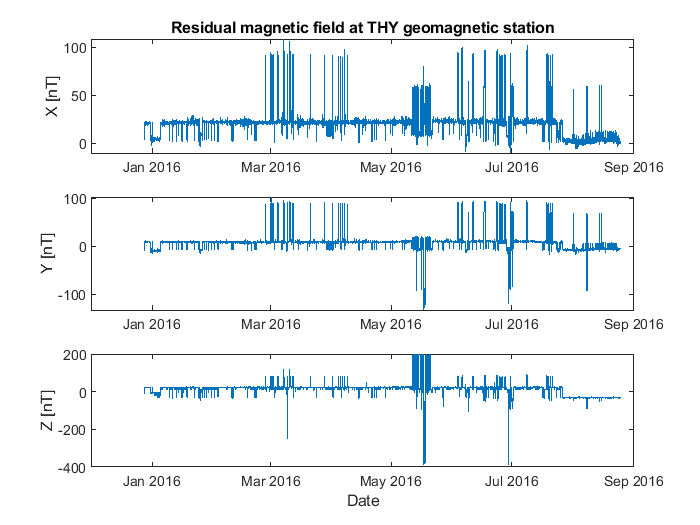

In [7]:
%Calculus and visualization of residuals

load("Interpolated_data.mat");
for i=1:size(GEOMAG_inside_r_Dob ,2)
    time_station_in = GEOMAG_inside_r_Dob(i).time;
    station_name = GEOMAG_inside_r_Dob(i).IAGA_name;
    residual_X(:,i) = GEOMAG_inside_r_Dob(i).X - X_interpolated(:,i);
    residual_Y(:,i) = GEOMAG_inside_r_Dob(i).Y - Y_interpolated(:,i);
    residual_Z(:,i) = GEOMAG_inside_r_Dob(i).Z - Z_interpolated(:,i);
    figure
    subplot(3,1,1)
    plot(time_station_in, residual_X(:,i));
    ylabel('X [nT]');
    title(['Residual magnetic field at ', station_name, ' geomagnetic station']);
    subplot(3,1,2)
    plot(time_station_in, residual_Y(:,i));
    ylabel('Y [nT]');
    subplot(3,1,3)
    plot(time_station_in, residual_Z(:,i));
    ylabel('Z [nT]');
    xlabel('Date')
end

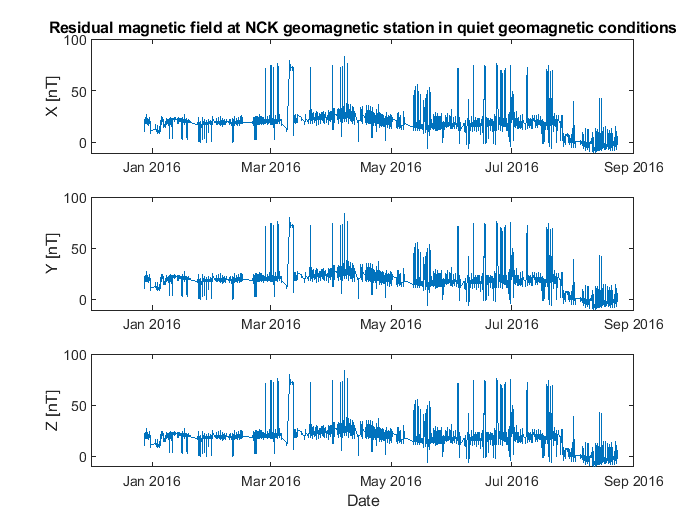

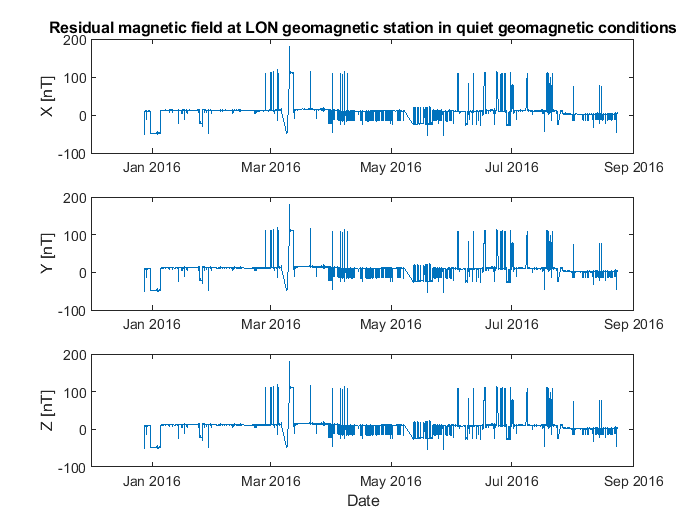

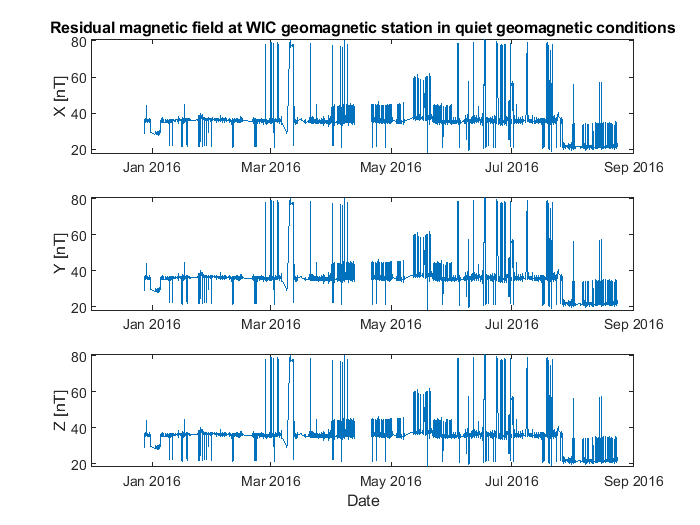

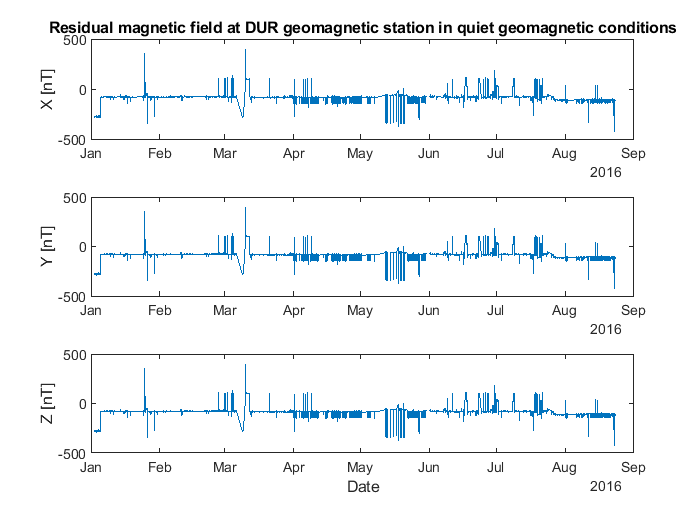

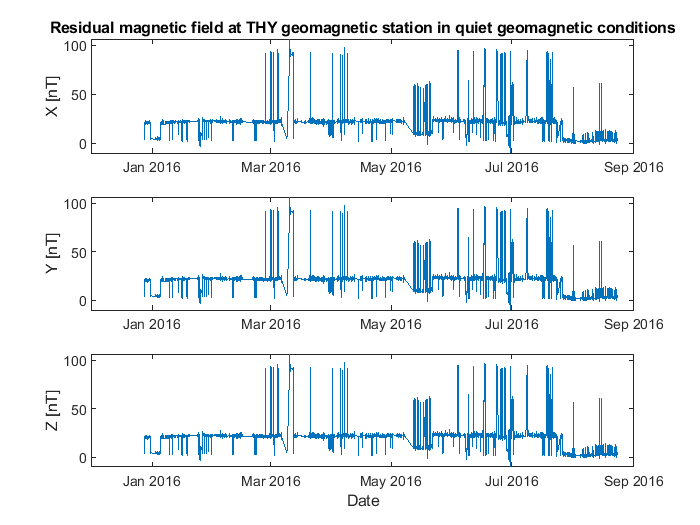

In [8]:
%Calculus and visualization of residuals with filtering of the disturbed time

idst=load('dst_index2.dat');
iap=load('ap_index2.dat');
max_dst = 20;
max_ap = 10;

load("Interpolated_data.mat");
% cycle over the geomagnetic stations inside the research area. 
for i=1:size(GEOMAG_inside_r_Dob ,2)
    time_station_in = GEOMAG_inside_r_Dob(i).time;
    [year_data, month_data, day_data, hour_data] = datevec(time_station_in);
    time_station_in_without_min_sec = datenum([year_data, month_data, day_data, hour_data, zeros(size(hour_data,1), 2)]);
    time_station_in_without_min_sec = unique(time_station_in_without_min_sec);
    [year_data_1, month_data_1, day_data_1, hour_data_1] = datevec(time_station_in_without_min_sec);
    dst_value = nan(size(time_station_in,1), 1);
    ap_value = nan(size(time_station_in,1), 1);
    for t_i = 1:size(time_station_in_without_min_sec,1)
        [dst,ap]=geomagnetic_indexes([year_data_1(t_i) month_data_1(t_i) day_data_1(t_i) hour_data_1(t_i)],idst,iap);
        dst_value(year_data == year_data_1(t_i) & month_data == month_data_1(t_i) & day_data == day_data_1(t_i) & hour_data == hour_data_1(t_i)) = dst;
        ap_value(year_data == year_data_1(t_i) & month_data == month_data_1(t_i) & day_data == day_data_1(t_i) & hour_data == hour_data_1(t_i)) = ap;
    end
    station_name = GEOMAG_inside_r_Dob(i).IAGA_name;
    residual_X(:,i) = GEOMAG_inside_r_Dob(i).X - X_interpolated(:,i);
    residual_Y(:,i) = GEOMAG_inside_r_Dob(i).Y - Y_interpolated(:,i);
    residual_Z(:,i) = GEOMAG_inside_r_Dob(i).Z - Z_interpolated(:,i);
    time_quiet = time_station_in(abs(dst_value) <= max_dst & ap_value <= max_ap);
    residual_X_quiet(:,i) = residual_X(abs(dst_value) <= max_dst & ap_value <= max_ap, i);
    residual_Y_quiet(:,i) = residual_Y(abs(dst_value) <= max_dst & ap_value <= max_ap, i);
    residual_Z_quiet(:,i) = residual_Z(abs(dst_value) <= max_dst & ap_value <= max_ap, i);

    figure
    subplot(3,1,1)
    plot(time_quiet, residual_X_quiet(:,i));
    ylabel('X [nT]');
    title(['Residual magnetic field at ', station_name, ' geomagnetic station in quiet geomagnetic conditions']);
    subplot(3,1,2)
    plot(time_quiet, residual_X_quiet(:,i));
    ylabel('Y [nT]');
    subplot(3,1,3)
    plot(time_quiet, residual_X_quiet(:,i));
    ylabel('Z [nT]');
    xlabel('Date')
end

In [9]:
% Before filtering the data, we need to make uniform the vector.
% We achieved this by an interpolation of the values over a uniform time vector (a sample every minute)
uniform_quiet_time = (time_quiet(1):1/24/60:time_quiet(end))';
residual_X_quiet_filtered_data = nan(size(uniform_quiet_time, 1), size(GEOMAG_inside_r_Dob ,2));
residual_Y_quiet_filtered_data = nan(size(uniform_quiet_time, 1), size(GEOMAG_inside_r_Dob ,2));
residual_Z_quiet_filtered_data = nan(size(uniform_quiet_time, 1), size(GEOMAG_inside_r_Dob ,2));
% cycle over the geomagnetic stations inside the research area. 
parfor i=1:size(GEOMAG_inside_r_Dob ,2)
    signal_to_be_filtered = interp1(time_quiet, residual_X_quiet(:,i), uniform_quiet_time, 'pchip');
    
    %Design of a low pass filter with 12 hour and 6 hours of pass and cutoff periods. 
    % 12 hours must be transformed in 1 minute sampling. 1/(12x60) = 0.001389 
    % 6 hours must be transformed in 1 minute sampling. 1/(6x60) = 0.002778
    low_pass_filter = designfilt("lowpassfir", PassbandFrequency=0.001389,StopbandFrequency=0.002778, ...
        PassbandRipple=1,StopbandAttenuation=60, DesignMethod="equiripple");
    residual_X_quiet_filtered = filtfilt(low_pass_filter,signal_to_be_filtered);
    signal_to_be_filtered = interp1(time_quiet, residual_Y_quiet(:,i), uniform_quiet_time, 'pchip');
    residual_Y_quiet_filtered = filtfilt(low_pass_filter,signal_to_be_filtered);
    signal_to_be_filtered = interp1(time_quiet, residual_Z_quiet(:,i), uniform_quiet_time, 'pchip');
    residual_Z_quiet_filtered = filtfilt(low_pass_filter,signal_to_be_filtered);

    iqr_residual_X = iqr(residual_X_quiet_filtered);
    upper_percentile_X = prctile(residual_X_quiet_filtered, 75);
    lower_percentile_X = prctile(residual_X_quiet_filtered, 25);
    residual_X_quiet_filtered(residual_X_quiet_filtered > upper_percentile_X + 10 * iqr_residual_X) = nan;
    residual_X_quiet_filtered(residual_X_quiet_filtered < lower_percentile_X - 10 * iqr_residual_X) = nan;
    iqr_residual_Y = iqr(residual_Y_quiet_filtered);
    upper_percentile_Y = prctile(residual_Y_quiet_filtered, 75);
    lower_percentile_Y = prctile(residual_Y_quiet_filtered, 25);
    residual_Y_quiet_filtered(residual_Y_quiet_filtered > upper_percentile_Y + 10 * iqr_residual_Y) = nan;
    residual_Y_quiet_filtered(residual_Y_quiet_filtered < lower_percentile_Y - 10 * iqr_residual_Y) = nan;
    iqr_residual_Z = iqr(residual_Z_quiet_filtered);
    upper_percentile_Z = prctile(residual_Z_quiet_filtered, 75);
    lower_percentile_Z = prctile(residual_Z_quiet_filtered, 25);
    residual_Z_quiet_filtered(residual_Z_quiet_filtered > upper_percentile_Z + 10 * iqr_residual_Z) = nan;
    residual_Z_quiet_filtered(residual_Z_quiet_filtered < lower_percentile_Z - 10 * iqr_residual_Z) = nan;

    % store filtered data for the following analyses
    residual_X_quiet_filtered_data(:,i) = residual_X_quiet_filtered;
    residual_Y_quiet_filtered_data(:,i) = residual_Y_quiet_filtered;
    residual_Z_quiet_filtered_data(:,i) = residual_Z_quiet_filtered;
end
save('Residual_geomag_data.mat', 'residual_X_quiet_filtered_data', 'residual_Y_quiet_filtered_data', 'residual_Z_quiet_filtered_data');

> In <a href="matlab:matlab.lang.internal.introspective.errorDocCallback('interp1>Interp1DStripNaN', 'C:\Program Files\MATLAB\R2024b\toolbox\matlab\polyfun\interp1.m', 242)" style="font-weight:bold">interp1>Interp1DStripNaN</a> (<a href="matlab: opentoline('C:\Program Files\MATLAB\R2024b\toolbox\matlab\polyfun\interp1.m',242,0)">line 242</a>)
In <a href="matlab:matlab.lang.internal.introspective.errorDocCallback('interp1', 'C:\Program Files\MATLAB\R2024b\toolbox\matlab\polyfun\interp1.m', 173)" style="font-weight:bold">interp1</a> (<a href="matlab: opentoline('C:\Program Files\MATLAB\R2024b\toolbox\matlab\polyfun\interp1.m',173,0)">line 173</a>)
In <a href="matlab:matlab.lang.internal.introspective.errorDocCallback('datetime/interp1', 'C:\Program Files\MATLAB\R2024b\toolbox\matlab\datatypes\datetime\@datetime\interp1.m', 93)" style="font-weight:bold">datetime/interp1</a> (<a href="matlab: opentoline('C:\Program Files\MATLAB\R2024b\toolbox\matlab\datatypes\datetime\@datetime\interp1.m',

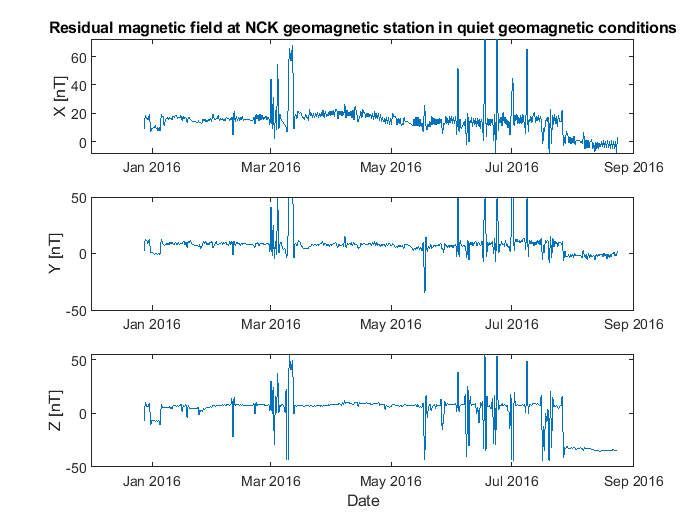

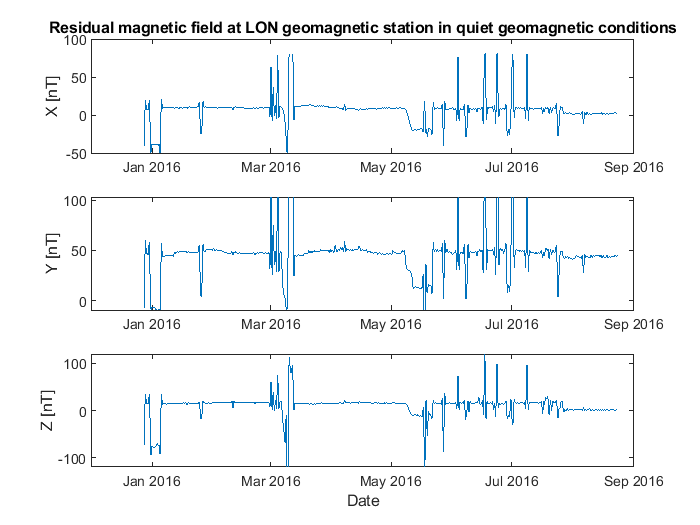

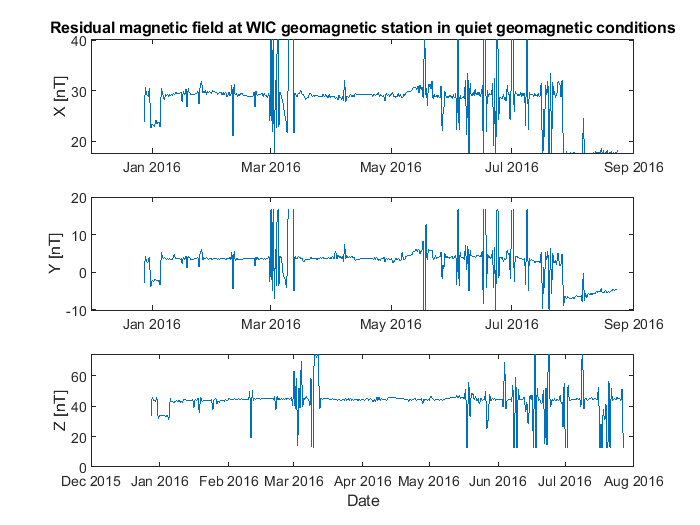

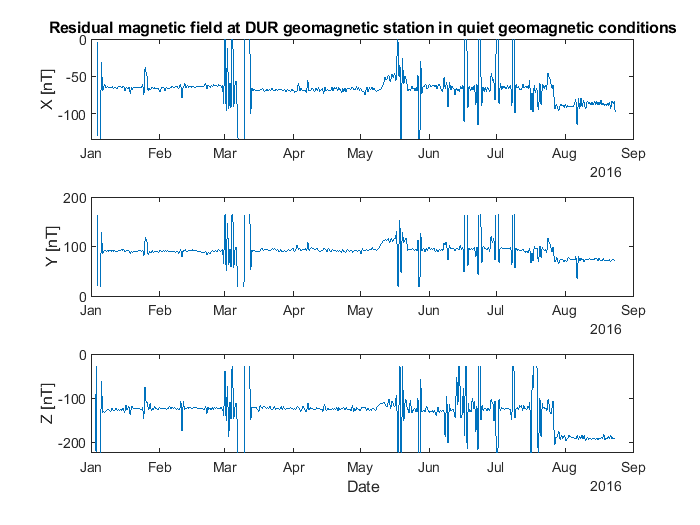

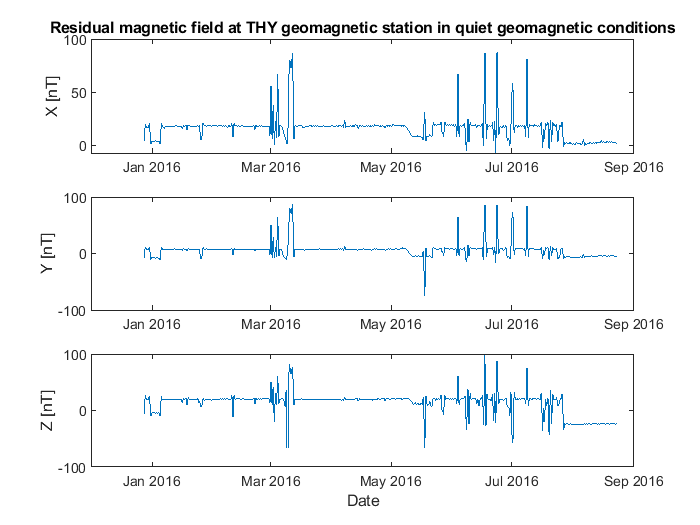

In [10]:
load('Residual_geomag_data.mat');

for i=1:size(GEOMAG_inside_r_Dob ,2)
    station_name = GEOMAG_inside_r_Dob(i).IAGA_name;
    figure
    subplot(3,1,1)
    plot(uniform_quiet_time, residual_X_quiet_filtered_data(:,i));
    ylabel('X [nT]');
    title(['Residual magnetic field at ', station_name, ' geomagnetic station in quiet geomagnetic conditions']);
    subplot(3,1,2)
    plot(uniform_quiet_time, residual_Y_quiet_filtered_data(:,i));
    ylabel('Y [nT]');
    subplot(3,1,3)
    plot(uniform_quiet_time, residual_Z_quiet_filtered_data(:,i));
    ylabel('Z [nT]');
    xlabel('Date')

   
    
end


## Atmospheric analysis

The atmospheric analysis uses a method called MEANS which is a variation of CAPRI algoritms. A full description of the methods can be found in:  
1. Piscini, A.; De Santis, A.; Marchetti, D.; Cianchini, G. A Multi-Parametric Climatological Approach to Study the 2016 Amatrice–Norcia (Central Italy) Earthquake Preparatory Phase. Pure Appl. Geophys. 2017, 174, 3673–3688. <a href="https://doi.org/10.1007/s00024-017-1597-8">doi:10.1007/s00024-017-1597-8</a>.
2. Marchetti, D.; De Santis, A.; Shen, X.; Campuzano, S.A.; Perrone, L.; Piscini, A.; Di Giovambattista, R.; Jin, S.; Ippolito, A.; Cianchini, G.; et al. Possible Lithosphere-Atmosphere-Ionosphere Coupling Effects Prior to the 2018 Mw = 7.5 Indonesia Earthquake from Seismic, Atmospheric and Ionospheric Data. J. Asian Earth Sci. 2020, 188, 104097. <a href="https://doi.org/10.1016/j.jseaes.2019.104097">doi:10.1016/j.jseaes.2019.104097</a>.


The atmospheric analysis uses the MERRA2 climatological archive data from NASA (doi: <a href="https://doi.org/10.5067/KLICLTZ8EM9D"> 10.5067/KLICLTZ8EM9D</a>).  
This version of the VRE uses data that were downloaded and pre-processed. In future releases, the automatic download of the dataset will be provided.

The pre-processed data are inside the file "Atmospheric_data_for_Norcia.mat".

In this session the data from MERRA-2 Climatological archive will be downloaded and analysed
**Important note:**  
The MERRA-2 data are open but require a free account on EarthData Nasa portal. The following line will ask you your username (generally your registration email) and your password in order to download the data.

In order to mask the password the Matlab tool logindlg has been used. Proper credit to: Jeremy Smith (2025). login (https://www.mathworks.com/matlabcentral/fileexchange/8499-login), MATLAB Central File Exchange. Retrieved January 25, 2025.

The following cell reports the function called *"logindlg"* by Jeremy Smith that permits the insertion of ones's own credentials masking the password. 


In [4]:
% Credit of this cell and function to Jeremy Smith, https://www.mathworks.com/matlabcentral/fileexchange/8499-login
% LOGINDLG   Dialog for visually secure login.
%   Examples:
%       [login password] = logindlg('Title','Login Title');  % Returns the login and
%          password with the dialog title 'Login Title'.
%
%       password = logindlg;  % Returns only the password with a default
%          dialog title.
%
%       password = logindlg('Password','only');  % Displays only a password
%          edit box and returns the password.
%
%       password = logindlg('Title','Login Title','Password','only');
%          % Creates a password only dialog with 'Login Title' as the
%          dialog title.
%
%
%
%
% Author: Jeremy Smith
% Date: September 24, 2005
% Last Edit: January 28, 2010
% Version: 1.3
% Tested on: Matlab 7.0.4.365 (R14) Service Pack 2, Matlab 7.1 SP 3, and
%       Matlab 7.4.0.287 (R2007a)
% Description: custom login dialog because Matlab doesn't have an option
%       for characters in an edit field to be replaced by asterisks
%       (password security).
%
%       Note:  On very slow computers the first few password characters may 
%       have a delay before they are converted to asterisks.

% Changelist:
%   1.3: -Pressing the Escape key with focus anywhere on the dialog will
%            now cancel the dialog box
%        -Typo correction
%        -Escape no longer creates an empty character in the password field
%   1.2: -Tab no longer triggers the OK button in the password box
%        -Improved the script help
%        -Removed horizontal alignment from buttons
%        -Added the option to display only the password box
%   1.1: -Added positioning code so it'll display in the center of the screen
%        -If only one output is specified the password will be returned
%            instead of the login as in Version 1.0
%        -Escape will not only close the dialog if neither edit box is active
%        -When the dialog appears the first edit box will be active
%        -Added a few more comments
%        -Removed the clc, it was left in by mistake in Version 1.0

function [varargout]=logindlg(varargin)

% Number of inputs check
if nargin ==  0 || nargin == 2 || nargin == 4
else
    error('Incorrect number of input arguments.')
end

% Input Type Check
for i=1:1:length(varargin)
    if ~ischar(varargin{i})
        error('Inputs must be strings.')
    end
end

% Title Option
if nargin == 0
    Title = 'Login';
elseif nargin == 2 && ~isempty(strmatch('title',lower(varargin)))
    Title = varargin{2};
elseif nargin == 2 && isempty(strmatch('title',lower(varargin)))
    Title = 'Login';
elseif nargin == 4 && ~isempty(strmatch('title',lower(varargin)))
    S = strmatch('title',lower(varargin));
    if S == 1
        Title = varargin{2};
    elseif S == 3
        Title = varargin{4};
    else
        error('Invalid title.')
    end
else
    error('Invalid title.')
end

% Password Option
if nargin == 0
    Pass = 0;
elseif nargin == 2 && ~isempty(strmatch('password',lower(varargin{1}))) && ~isempty(strmatch('only',lower(varargin{2})))
    Pass = 1;
elseif nargin == 4 && ~isempty(strmatch('password',lower(varargin))) && ~isempty(strmatch('only',lower(varargin)))
    P = strmatch('password',lower(varargin));
    O = strmatch('only',lower(varargin));
    if P == 1 && O == 2
        Pass = 1;
    elseif P == 3 && O == 4
        Pass = 1;
    end
elseif nargin == 2 && isempty(strmatch('password',lower(varargin))) == 1
    Pass = 0;
else
    error('Invalid password option.')
end

% Output Error Check
if nargout > 1 && Pass == 1 || nargout > 2
    error('Too many output arguments.')
end

% Get Properties
Color = get(0,'DefaultUicontrolBackgroundcolor');

% Determine the size and position of the login interface
if Pass == 0
    Height = 9.5;
else
    Height = 5.5;
end
set(0,'Units','characters')
Screen = get(0,'screensize');
Position = [Screen(3)/2-17.5 Screen(4)/2-4.75 35 Height];
set(0,'Units','pixels')

% Create the GUI
gui.main = dialog('HandleVisibility','on',...
    'IntegerHandle','off',...
    'Menubar','none',...
    'NumberTitle','off',...
    'Name','Login',...
    'Tag','logindlg',...
    'Color',Color,...
    'Units','characters',...
    'Userdata','logindlg',...
    'Position',Position);

% Set the title
if ischar(Title) == 1
    set(gui.main,'Name',Title,'Closerequestfcn',{@Cancel,gui.main},'Keypressfcn',{@Escape})
end

% Texts
if Pass == 0
    gui.login_text = uicontrol(gui.main,'Style','text','FontSize',8,'HorizontalAlign','left','Units','characters','String','Login','Position',[1 7.65 20 1]);
end
gui.password_text = uicontrol(gui.main,'Style','text','FontSize',8,'HorizontalAlign','left','Units','characters','String','Password','Position',[1 4.15 20 1]);

% Edits
if Pass == 0
    gui.edit1 = uicontrol(gui.main,'Style','edit','FontSize',8,'HorizontalAlign','left','BackgroundColor','white','Units','characters','String','','Position',[1 6.02 33 1.7],'KeyPressfcn',{@Escape});
end
gui.edit2 = uicontrol(gui.main,'Style','edit','FontSize',8,'HorizontalAlign','left','BackgroundColor','white','Units','characters','String','','Position',[1 2.52 33 1.7],'KeyPressfcn',{@KeyPress_Function,gui.main},'Userdata','');

% Buttons
gui.OK = uicontrol(gui.main,'Style','push','FontSize',8,'Units','characters','String','OK','Position',[12 .2 10 1.7],'Callback',{@OK,gui.main},'KeyPressfcn',{@Escape});
gui.Cancel = uicontrol(gui.main,'Style','push','FontSize',8,'Units','characters','String','Cancel','Position',[23 .2 10 1.7],'Callback',{@Cancel,gui.main},'KeyPressfcn',{@Escape});

setappdata(0,'logindlg',gui) % Save handle data
setappdata(gui.main,'Check',0) % Error check setup. If Check remains 0 an empty cell array will be returned

if Pass == 0
    uicontrol(gui.edit1) % Make the first edit box active
else
    uicontrol(gui.edit2)  % Make the second edit box active if the first isn't present
end

% Pause the GUI and wait for a button to be pressed
uiwait(gui.main)

Check = getappdata(gui.main,'Check'); % Check to see if a button was pressed

% Format output
if Check == 1
    if Pass == 0
        Login = get(gui.edit1,'String');
    end
    Password = get(gui.edit2,'Userdata');
    
    if nargout == 1 % If only one output specified output Password
        varargout(1) = {Password};
    elseif nargout == 2 % If two outputs specified output both Login and Password
        varargout(1) = {Login};
        varargout(2) = {Password};
    end
else % If OK wasn't pressed output nothing
    if nargout == 1
        varargout(1) = {[]};
    elseif nargout == 2
        varargout(1) = {[]};
        varargout(2) = {[]};
    end
end

delete(gui.main) % Close the GUI
setappdata(0,'logindlg',[]) % Erase handles from memory

%% Hide Password
function KeyPress_Function(h,eventdata,fig)
% Function to replace all characters in the password edit box with
% asterisks
password = get(h,'Userdata');
key = get(fig,'currentkey');

switch key
    case 'backspace'
        password = password(1:end-1); % Delete the last character in the password
    case 'return'  % This cannot be done through callback without making tab to the same thing
        gui = getappdata(0,'logindlg');
        OK([],[],gui.main);
    case 'tab'  % Avoid tab triggering the OK button
        gui = getappdata(0,'logindlg');
        uicontrol(gui.OK);
    case 'escape'
        % Close the login dialog
        Escape(fig,[])
    otherwise
        password = [password get(fig,'currentcharacter')]; % Add the typed character to the password
end

SizePass = size(password); % Find the number of asterisks
if SizePass(2) > 0
    asterisk(1,1:SizePass(2)) = '*'; % Create a string of asterisks the same size as the password
    set(h,'String',asterisk) % Set the text in the password edit box to the asterisk string
else
    set(h,'String','')
end

set(h,'Userdata',password) % Store the password in its current state

%% Cancel
function Cancel(h,eventdata,fig)
uiresume(fig)

%% OK
function OK(h,eventdata,fig)
% Set the check and resume
setappdata(fig,'Check',1)
uiresume(fig)

%% Escape
function Escape(h,eventdata)
% Close the login if the escape button is pushed and neither edit box is
% active
fig = h;
while ~strcmp(get(fig,'Type'),'figure')
    fig = get(fig,'Parent');
end
key = get(fig,'currentkey');

if isempty(strfind(key,'escape')) == 0
    Cancel([],[],fig)
end

In [21]:
% User_ED = inputdlg('Please insert your username (generally email) of your EarthData account: ', "s");
% pwd_ED =  inputdlg('Please insert your password of your EarthData account: ', "s");

[User_ED pwd_ED] = logindlg('Please insert your username and password for your EarthData account','Login Title');

Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

In [22]:
% Section to download the necessary data from NASA - MERRA2

options_for_NASA = weboptions('Username', User_ED,'Password', pwd_ED, 'Timeout', 30000);
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;
min_lat = round(epilat - radius_Dobrovolsky/sqrt(2));
max_lat = round(epilat + radius_Dobrovolsky/sqrt(2));
min_lon = round(epilon - radius_Dobrovolsky/sqrt(2));
max_lon = round(epilon + radius_Dobrovolsky/sqrt(2));
local_midnight = - epilon/15;
UT_time_of_data = round(local_midnight);
if UT_time_of_data >= 24
    UT_time_of_data = UT_time_of_data - 24;
end
if UT_time_of_data < 0
    UT_time_of_data = UT_time_of_data + 24;
end
index_of_time_data = UT_time_of_data + 1; %The index is increased of a unit as Matlab starts to count from "1"


time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
[year_end1, month_end1, day_end1] = datevec(time_end);
[year_end, ~] = datevec(now); %2024;
year_end = year_end -1; %Stop the analysis the year before the present one.
number_of_analysed_days = day_after + day_before + 1;
if (datenum([1980 month_end1 day_end1]) - number_of_analysed_days) < datenum([1980 1 1])
    year_start = 1981;
else
    year_start = 1980;
end
[~, month_start, day_start] = datevec(time_start);
time_start = datenum([year_start, month_start, day_start]);
time_end = datenum([year_end, month_end1, day_end1]);
number_of_analysed_days = time_end - time_start + 1;
if exist('Atmospheric_data_from_MERRA2.mat') > 0
    load('Atmospheric_data_from_MERRA2.mat');
else
    TCWV = nan(number_of_analysed_days, 1);
    TCWV_time = nan(number_of_analysed_days, 1);
    SO2 = nan(number_of_analysed_days, 1);
    SO2_time = nan(number_of_analysed_days, 1);
    DMS = nan(number_of_analysed_days, 1);
    DMS_time = nan(number_of_analysed_days, 1);
    AOT = nan(number_of_analysed_days, 1);
    AOT_time = nan(number_of_analysed_days, 1);
    CO = nan(number_of_analysed_days, 1);
    CO_time = nan(number_of_analysed_days, 1);
    TO3 = nan(number_of_analysed_days, 1);
    TO3_time = nan(number_of_analysed_days, 1);
    SAT = nan(number_of_analysed_days, 1);
    SAT_time = nan(number_of_analysed_days, 1);
    HUM = nan(number_of_analysed_days, 1);
    HUM_time = nan(number_of_analysed_days, 1);
    SLHF = nan(number_of_analysed_days, 1);
    SLHF_time = nan(number_of_analysed_days, 1);
    RAIN = nan(number_of_analysed_days, 1);
    RAIN_time = nan(number_of_analysed_days, 1);
end

k = 1;
list_of_days = nan(number_of_analysed_days, 1);
for year_tba = year_start:year_end
    time_start_1 = datenum([year_tba EQ_month EQ_day]) - day_before;
    time_end_1 = datenum([year_tba EQ_month EQ_day]) + day_after;
    for day_tba = time_start_1:time_end_1
        list_of_days(k,1) = day_tba;
        k = k + 1;
    end
end
list_of_days = list_of_days(1:k-1);

k = 1;
for i_day = 1:size(list_of_days,1)
    day_to_be_analyed=list_of_days(i_day); %fix(time_start):fix(time_end)
    [year_tba, month_tba, day_tba] = datevec(day_to_be_analyed)
    if sum(TCWV_time == day_to_be_analyed) == 0
    % if isnan(TCWV_time(k)) == 1
        index_nan = find(isnan(TCWV_time));
        if size(index_nan,1) == 0
            index_nan = size(TCWV_time,1) + 1;
        else
            index_nan = index_nan(1);
        end

        % MERRA2_100.*.19800101.nc4
        % MERRA2_200.*.19920101.nc4
        % MERRA2_300.*.20010101.nc4
        % MERRA2_400.*.20110101.nc4
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end

        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2I1NXINT.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.inst1_2d_int_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&VERSION=1.02&SERVICE=L34RS_MERRA2&DATASET_VERSION=5.12.4&LABEL=', version_f, '.inst1_2d_int_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&FORMAT=bmM0Lw&VARIABLES=TQV&SHORTNAME=M2I1NXINT&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00%2F', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T23%3A00%3A59'];
        TCVW_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, TCVW_p);
        fclose(file_output);
        TCVW_1 = ncread('test_MERRA.nc', 'TQV');
        %time_TCWV = ncread('test_MERRA.nc', 'time');
        TCWV(index_nan,1) = mean(reshape(TCVW_1, size(TCVW_1,1)*size(TCVW_1,2), 1));
        TCWV_time(index_nan,1) = day_to_be_analyed;
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV');
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN_time', '-append');
        end
    end
    
    if sum(SO2_time == day_to_be_analyed) == 0
    % if isnan(SO2_time(k)) == 1
        index_nan = find(isnan(SO2_time));
        if size(index_nan,1) == 0
            index_nan = size(SO2_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2T1NXAER.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.tavg1_2d_aer_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&SERVICE=L34RS_MERRA2&VERSION=1.02&LABEL=', version_f, '.tavg1_2d_aer_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&SHORTNAME=M2T1NXAER&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A30%3A00&DATASET_VERSION=5.12.4&VARIABLES=DMSSMASS%2CSO2SMASS%2CTOTEXTTAU&FORMAT=nc4%2F'];
        SO2_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, SO2_p);
        fclose(file_output);
        SO2_1 = ncread('test_MERRA.nc', 'SO2SMASS');
        DMS_1 = ncread('test_MERRA.nc', 'DMSSMASS');
        AOT_1 = ncread('test_MERRA.nc', 'TOTEXTTAU');
        SO2(index_nan,1) = mean(reshape(SO2_1(:,:,index_of_time_data), size(SO2_1,1)*size(SO2_1,2), 1));
        SO2_time(index_nan,1) = day_to_be_analyed;
        DMS(index_nan,1) = mean(reshape(DMS_1(:,:,index_of_time_data), size(DMS_1,1)*size(DMS_1,2), 1));
        DMS_time(index_nan,1) = day_to_be_analyed;
        AOT(index_nan,1) = mean(reshape(AOT_1(:,:,index_of_time_data), size(AOT_1,1)*size(AOT_1,2), 1));
        AOT_time(index_nan,1) = day_to_be_analyed;
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV');
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN_time', '-append');
        end
    end
    
    if sum(CO_time == day_to_be_analyed) == 0
    % if isnan(CO_time(k)) == 1
    index_nan = find(isnan(CO_time));
        if size(index_nan,1) == 0
            index_nan = size(CO_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2T1NXCHM.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.tavg1_2d_chm_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&FORMAT=bmM0Lw&VERSION=1.02&LABEL=', version_f, '.tavg1_2d_chm_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&SHORTNAME=M2T1NXCHM&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00&DATASET_VERSION=5.12.4&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&VARIABLES=COSC%2CTO3&SERVICE=L34RS_MERRA2'];
        CO_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, CO_p);
        fclose(file_output);
        CO_1 = ncread('test_MERRA.nc', 'COSC');
        TO3_1 = ncread('test_MERRA.nc', 'TO3');
        CO(index_nan,1) = mean(reshape(CO_1(:,:,index_of_time_data), size(CO_1,1)*size(CO_1,2), 1));
        CO_time(index_nan,1) = day_to_be_analyed;
        TO3(index_nan,1) = mean(reshape(TO3_1(:,:,index_of_time_data), size(TO3_1,1)*size(TO3_1,2), 1));
        TO3_time(index_nan,1) = day_to_be_analyed;
        
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV');
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN_time', '-append');
        end
    end
    
    if sum(SAT_time == day_to_be_analyed) == 0
    % if isnan(SAT_time(k)) == 1
        index_nan = find(isnan(SAT_time));
        if size(index_nan,1) == 0
            index_nan = size(SAT_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2I1NXLFO.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.inst1_2d_lfo_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&VERSION=1.02&SERVICE=L34RS_MERRA2&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&DATASET_VERSION=5.12.4&SHORTNAME=M2I1NXLFO&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00&LABEL=', version_f, '.inst1_2d_lfo_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc&VARIABLES=QLML%2CTLML&FORMAT=nc4%2F'];
        SAT_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, SAT_p);
        fclose(file_output);
        SAT_1 = ncread('test_MERRA.nc', 'TLML');
        HUM_1 = ncread('test_MERRA.nc', 'QLML');
        SAT(index_nan,1) = mean(reshape(SAT_1(:,:,index_of_time_data), size(SAT_1,1)*size(SAT_1,2), 1));
        SAT_time(index_nan,1) = day_to_be_analyed;
        HUM(index_nan,1) = mean(reshape(HUM_1(:,:,index_of_time_data), size(HUM_1,1)*size(HUM_1,2), 1));
        HUM_time(index_nan,1) = day_to_be_analyed;
        
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV');
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN_time', '-append');
        end
    end
    
    if sum(RAIN_time == day_to_be_analyed) == 0
    % if isnan(RAIN_time(k)) == 1
        index_nan = find(isnan(RAIN_time));
        if size(index_nan,1) == 0
            index_nan = size(RAIN_time,1) + 1;
        else
            index_nan = index_nan(1);
        end
        if day_to_be_analyed < datenum([1992 1 1])
            version_f = 'MERRA2_100';
        elseif day_to_be_analyed < datenum([2001 1 1])
            version_f = 'MERRA2_200';
        elseif day_to_be_analyed < datenum([2011 1 1])
            version_f = 'MERRA2_300';
        elseif (day_to_be_analyed >= datenum([2020 9 1]) && day_to_be_analyed <= datenum([2020 9 30])) || (day_to_be_analyed >= datenum([2021 6 1]) && day_to_be_analyed <= datenum([2021 9 30]))
            version_f = 'MERRA2_401';
        else
            version_f = 'MERRA2_400';
        end
        weburl_to_retrive_the_data = ['https://goldsmr4.gesdisc.eosdis.nasa.gov/daac-bin/OTF/HTTP_services.cgi?FILENAME=%2Fdata%2FMERRA2%2FM2T1NXFLX.5.12.4%2F', num2str(year_tba), '%2F', num2str(month_tba, '%02.0f'), '%2F', version_f, '.tavg1_2d_flx_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.nc4&VARIABLES=EFLUX%2CPRECTOT&VERSION=1.02&SERVICE=L34RS_MERRA2&DATASET_VERSION=5.12.4&BBOX=', num2str(min_lat),'%2C', num2str(min_lon), '%2C', num2str(max_lat), '%2C', num2str(max_lon), '&FORMAT=bmM0Lw&SHORTNAME=M2T1NXFLX&TIME=', num2str(year_tba), '-', num2str(month_tba, '%02.0f'),'-', num2str(day_tba, '%02.0f'), 'T', num2str(UT_time_of_data, '%02.0f'),'%3A00%3A00&LABEL=', version_f, '.tavg1_2d_flx_Nx.', num2str(year_tba), num2str(month_tba, '%02.0f'), num2str(day_tba, '%02.0f'), '.SUB.nc'];
        SLHF_p = webread(weburl_to_retrive_the_data, options_for_NASA);
        file_output = fopen('test_MERRA.nc', 'w');
        fwrite(file_output, SLHF_p);
        fclose(file_output);
        SLHF_1 = ncread('test_MERRA.nc', 'EFLUX');
        RAIN_1 = ncread('test_MERRA.nc', 'PRECTOT');
        SLHF(index_nan,1) = mean(reshape(SLHF_1(:,:,index_of_time_data), size(SLHF_1,1)*size(SLHF_1,2), 1));
        SLHF_time(index_nan,1) = day_to_be_analyed;
        RAIN(index_nan,1) = mean(reshape(RAIN_1(:,:,index_of_time_data), size(RAIN_1,1)*size(RAIN_1,2), 1));
        RAIN_time(index_nan,1) = day_to_be_analyed;
        
        if mod(k,15) == 0 %save downloaded data every 15 timesteps to protect against eventual website failure
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV');
            save('Atmospheric_data_from_MERRA2.mat', 'TCWV_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SO2_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'DMS_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'AOT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'CO_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'TO3_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SAT_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'HUM_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'SLHF_time', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN', '-append');
            save('Atmospheric_data_from_MERRA2.mat', 'RAIN_time', '-append');
        end
    end    
    
    k = k + 1;
end

save('Atmospheric_data_from_MERRA2.mat', 'TCWV');
save('Atmospheric_data_from_MERRA2.mat', 'TCWV_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'SO2', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'SO2_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'DMS', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'DMS_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'AOT', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'AOT_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'CO', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'CO_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'TO3', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'TO3_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'SAT', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'SAT_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'HUM', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'HUM_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'SLHF', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'SLHF_time', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'RAIN', '-append');
save('Atmospheric_data_from_MERRA2.mat', 'RAIN_time', '-append');



Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

number_of_analysed_days =    241

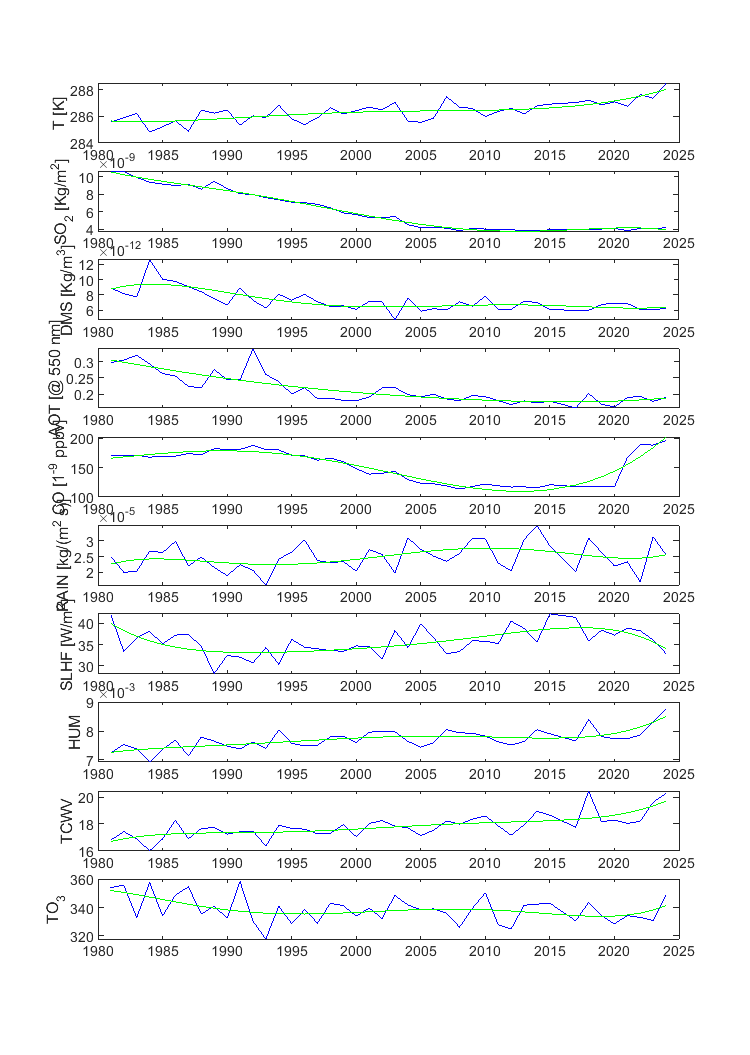

In [20]:
% load("Atmospheric_data_for_Norcia.mat");
load('Atmospheric_data_from_MERRA2.mat');
global_warming_correction = 5;
EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;
number_of_analysed_days = time_end - time_start + 1
[year_end1, month_end1, day_end1] = datevec(time_end);
year_end = 2024;
if (datenum([1980 month_end1 day_end1]) - number_of_analysed_days) < datenum([1980 1 1])
    year_start = 1981;
else
    year_start = 1980;
end
year_to_be_analysed = year_end-year_start;
mean_SO2 = nan(number_of_analysed_days,year_to_be_analysed);
mean_DMS = nan(number_of_analysed_days,year_to_be_analysed);
mean_AOT = nan(number_of_analysed_days,year_to_be_analysed);
mean_CO = nan(number_of_analysed_days,year_to_be_analysed);
mean_SAT = nan(number_of_analysed_days, year_to_be_analysed);
mean_HUM = nan(number_of_analysed_days,year_to_be_analysed);
mean_SLHF = nan(number_of_analysed_days,year_to_be_analysed);
mean_RAIN = nan(number_of_analysed_days,year_to_be_analysed);
mean_TCWV = nan(number_of_analysed_days,year_to_be_analysed);
mean_TO3 = nan(number_of_analysed_days,year_to_be_analysed);
mean_SO2_anno_EQ = zeros(number_of_analysed_days, 1);
mean_DMS_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_AOT_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_CO_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_SAT_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_HUM_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_SLHF_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_RAIN_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_TCWV_anno_EQ  = zeros(number_of_analysed_days, 1);
mean_TO3_anno_EQ  = zeros(number_of_analysed_days, 1);

SO2_EQ = SO2;
DMS_EQ = DMS;
AOT_EQ = AOT;
CO_EQ = CO;
SAT_EQ = SAT;
HUM_EQ = HUM;
SLHF_EQ = SLHF;
RAIN_EQ = RAIN;
TCWV_EQ = TCWV;
TO3_EQ = TO3;
time_atmospheric_data = SO2_time;

anno_arr = 1;
for year_i=year_to_be_analysed:-1:0 % anno=anno_inizio:anno_fine
    anno = year_end-year_i;
    %     day_tbc = giorni_prima;
    data_fine = datenum([anno EQ_month EQ_day]);
    data_inizio = data_fine - number_of_analysed_days+1;
    if EQ_month == 1 || (EQ_month == 2 && EQ_day < 29)
        year_to_be_checked_for_leap = anno - 1;
    else
        year_to_be_checked_for_leap = anno;
    end
    Leap_day = datenum([year_to_be_checked_for_leap 2 29]);
    [~, ~, day_check] = datevec(Leap_day);
    if day_check == 29 && data_inizio <= Leap_day && data_fine >= Leap_day
        data_inizio = data_inizio - 1;
    end
    
    giorno_arr = 1;
    
    for i=data_inizio:data_fine
        [~, mese_p, giorno_p] = datevec(i);
        index_data = find(time_atmospheric_data == i);
        if not(mese_p == 2 && giorno_p == 29)
            
            
            % , SO2_EQ, DMS_EQ, AOT_EQ, CO_EQ, SAT_EQ, HUM_EQ, SLHF_EQ,
            % RAIN_EQ time_atmospheric_data
            
            if anno == EQ_year
                mean_SO2_anno_EQ(giorno_arr,1) = SO2_EQ(index_data);
                mean_DMS_anno_EQ(giorno_arr,1) = DMS_EQ(index_data);
                mean_AOT_anno_EQ(giorno_arr,1) = AOT_EQ(index_data);
                mean_CO_anno_EQ(giorno_arr,1) = CO_EQ(index_data);
                mean_SAT_anno_EQ(giorno_arr,1) = SAT_EQ(index_data);
                mean_RAIN_anno_EQ(giorno_arr,1) = RAIN_EQ(index_data);
                mean_SLHF_anno_EQ(giorno_arr,1) = SLHF_EQ(index_data);
                mean_HUM_anno_EQ(giorno_arr,1) = HUM_EQ(index_data);
                mean_TCWV_anno_EQ(giorno_arr,1) = TCWV_EQ(index_data);
                mean_TO3_anno_EQ(giorno_arr,1) = TO3_EQ(index_data);
            else
                mean_SO2(giorno_arr,anno_arr) = SO2_EQ(index_data);
                mean_DMS(giorno_arr,anno_arr) = DMS_EQ(index_data);
                mean_AOT(giorno_arr,anno_arr) = AOT_EQ(index_data);
                mean_CO(giorno_arr,anno_arr) = CO_EQ(index_data);
                mean_SAT(giorno_arr,anno_arr) = SAT_EQ(index_data);
                mean_RAIN(giorno_arr,anno_arr) = RAIN_EQ(index_data);
                mean_SLHF(giorno_arr,anno_arr) = SLHF_EQ(index_data);
                mean_HUM(giorno_arr,anno_arr) = HUM_EQ(index_data);
                mean_TCWV(giorno_arr,anno_arr) = TCWV_EQ(index_data);
                mean_TO3(giorno_arr,anno_arr) = TO3_EQ(index_data);
            end
            
            giorno_arr = giorno_arr + 1;
        end
    end
    if anno ~= EQ_year
        anno_arr = anno_arr + 1;
    end
end
if global_warming_correction == 0
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SAT = yarly_SAT(1:end-1);
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,1);
    year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        else
            mean_SAT_anno_EQ = mean_SAT_anno_EQ - fit_global_warming_SAT(1)*(year_tbcorrected - year_start);
        end
        year_k = year_k + 1;
    end
elseif global_warming_correction > 0
    yarly_SAT = (mean(mean_SAT,1))';
    yarly_SO2 = (mean(mean_SO2,1))';
    yarly_DMS = (mean(mean_DMS,1))';
    yarly_AOT = (mean(mean_AOT,1))';
    yarly_CO = (mean(mean_CO,1))';
    yarly_RAIN = (mean(mean_RAIN,1))';
    yarly_SLHF = (mean(mean_SLHF,1))';
    yarly_HUM = (mean(mean_HUM,1))';
    yearly_TCWV = (mean(mean_TCWV,1))';
    yearly_TO3 = (mean(mean_TO3,1))';
    year_considered = (year_start:year_end)';
    year_considered = year_considered(year_considered ~= EQ_year);
    
    fit_global_warming_SAT = polyfit(year_considered,yarly_SAT,global_warming_correction);
    fit_global_warming_SO2 = polyfit(year_considered,yarly_SO2,global_warming_correction);
    fit_global_warming_DMS = polyfit(year_considered,yarly_DMS,global_warming_correction);
    fit_global_warming_AOT = polyfit(year_considered,yarly_AOT,global_warming_correction);
    fit_global_warming_CO = polyfit(year_considered,yarly_CO,global_warming_correction);
    fit_global_warming_RAIN = polyfit(year_considered,yarly_RAIN,global_warming_correction);
    fit_global_warming_SLHF = polyfit(year_considered,yarly_SLHF,global_warming_correction);
    fit_global_warming_HUM = polyfit(year_considered,yarly_HUM,global_warming_correction);
    fit_global_warming_TCWV = polyfit(year_considered,yearly_TCWV,global_warming_correction);
    fit_global_warming_TO3 = polyfit(year_considered,yearly_TO3,global_warming_correction);

        figure('Position', [1,1,600,1500])
        subplot(10,1,1)
        plot(year_considered,yarly_SAT, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SAT, year_considered), '-g');
        ylabel('T [K]');
        subplot(10,1,2)
        plot(year_considered,yarly_SO2, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SO2, year_considered), '-g');
        ylabel('SO_2 [Kg/m^2]');
        subplot(10,1,3)
        plot(year_considered,yarly_DMS, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_DMS, year_considered), '-g');
        ylabel('DMS [Kg/m^3]');
        subplot(10,1,4)
        plot(year_considered,yarly_AOT, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_AOT, year_considered), '-g');
        ylabel('AOT [@ 550 nm]');
        subplot(10,1,5)
        plot(year_considered,yarly_CO, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_CO, year_considered), '-g');
        ylabel('CO [1^{-9} ppbv]');
        subplot(10,1,6)
        plot(year_considered,yarly_RAIN, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_RAIN, year_considered), '-g');
        ylabel('RAIN [kg/(m^2 s)]');
        subplot(10,1,7)
        plot(year_considered,yarly_SLHF, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_SLHF, year_considered), '-g');
        ylabel('SLHF [W/m^2]');
        subplot(10,1,8)
        plot(year_considered,yarly_HUM, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_HUM, year_considered), '-g');
        ylabel('HUM');
        subplot(10,1,9)
        plot(year_considered,yearly_TCWV, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_TCWV, year_considered), '-g');
        ylabel('TCWV');
        subplot(10,1,10)
        plot(year_considered,yearly_TO3, '-b');
        hold on;
        plot(year_considered,polyval(fit_global_warming_TO3, year_considered), '-g');
        ylabel('TO_3');


        year_k = 1;
    for year_tbcorrected = year_start:year_end
        if year_tbcorrected ~= EQ_year
            mean_SAT(:,year_k) = mean_SAT(:,year_k) - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2(:,year_k) = mean_SO2(:,year_k) - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS(:,year_k) = mean_DMS(:,year_k) - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT(:,year_k) = mean_AOT(:,year_k) - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO(:,year_k) = mean_CO(:,year_k) - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN(:,year_k) = mean_RAIN(:,year_k) - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF(:,year_k) = mean_SLHF(:,year_k) - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM(:,year_k) = mean_HUM(:,year_k) - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            mean_TCWV(:,year_k) = mean_TCWV(:,year_k) - polyval(fit_global_warming_TCWV, year_tbcorrected) + mean(mean_TCWV(:,1));
            mean_TO3(:,year_k) = mean_TO3(:,year_k) - polyval(fit_global_warming_TO3, year_tbcorrected) + mean(mean_TO3(:,1));
            year_k = year_k + 1;
        else
            mean_SAT_anno_EQ = mean_SAT_anno_EQ - polyval(fit_global_warming_SAT, year_tbcorrected) + mean(mean_SAT(:,1));
            mean_SO2_anno_EQ = mean_SO2_anno_EQ - polyval(fit_global_warming_SO2, year_tbcorrected) + mean(mean_SO2(:,1));
            mean_DMS_anno_EQ = mean_DMS_anno_EQ - polyval(fit_global_warming_DMS, year_tbcorrected) + mean(mean_DMS(:,1));
            mean_AOT_anno_EQ = mean_AOT_anno_EQ - polyval(fit_global_warming_AOT, year_tbcorrected) + mean(mean_AOT(:,1));
            mean_CO_anno_EQ = mean_CO_anno_EQ - polyval(fit_global_warming_CO, year_tbcorrected) + mean(mean_CO(:,1));
            mean_RAIN_anno_EQ = mean_RAIN_anno_EQ - polyval(fit_global_warming_RAIN, year_tbcorrected) + mean(mean_RAIN(:,1));
            mean_SLHF_anno_EQ = mean_SLHF_anno_EQ - polyval(fit_global_warming_SLHF, year_tbcorrected) + mean(mean_SLHF(:,1));
            mean_HUM_anno_EQ = mean_HUM_anno_EQ - polyval(fit_global_warming_HUM, year_tbcorrected) + mean(mean_HUM(:,1));
            mean_TCWV_anno_EQ = mean_TCWV_anno_EQ - polyval(fit_global_warming_TCWV, year_tbcorrected) + mean(mean_TCWV(:,1));
            mean_TO3_anno_EQ = mean_TO3_anno_EQ - polyval(fit_global_warming_TO3, year_tbcorrected) + mean(mean_TO3(:,1));
        end
        
    end
end

sd_SO2 = nanstd(mean_SO2, 0, 2);
sd_DMS = nanstd(mean_DMS, 0, 2);
sd_AOT = nanstd(mean_AOT, 0, 2);
sd_CO = nanstd(mean_CO, 0, 2);
sd_SAT = nanstd(mean_SAT, 0, 2);
sd_RAIN = nanstd(mean_RAIN, 0, 2);
sd_SLHF = nanstd(mean_SLHF, 0, 2);
sd_HUM = nanstd(mean_HUM, 0, 2);
sd_TCWV = nanstd(mean_TCWV, 0, 2);
sd_TO3 = nanstd(mean_TO3, 0, 2);

soglia_SO2 = median(nanmedian(mean_SO2, 2)) + 10*median(sd_SO2);
soglia_DMS = median(nanmedian(mean_DMS, 2)) + 10*median(sd_DMS);
soglia_AOT = median(nanmedian(mean_AOT, 2)) + 10*median(sd_AOT);
soglia_CO = median(nanmedian(mean_CO, 2)) + 10*median(sd_CO);
soglia_SAT = median(nanmedian(mean_SAT, 2)) + 10*median(sd_SAT);
soglia_RAIN = median(nanmedian(mean_RAIN, 2)) + 10*median(sd_RAIN);
soglia_SLHF = median(nanmedian(mean_SLHF, 2)) + 10*median(sd_SLHF);
soglia_HUM = median(nanmedian(mean_SAT, 2)) + 10*median(sd_HUM);
threshold_TCWV = median(nanmedian(mean_TCWV, 2)) + 10*median(sd_TCWV);
threshold_TO3 = median(nanmedian(mean_TO3, 2)) + 10*median(sd_TO3);

mean_SO2h = []; %vettore per immaganizzare i dati "buoni"

mean_DMSh = [];
mean_AOTh = [];
mean_COh = [];
mean_SATh = [];
mean_RAINh = [];
mean_SLHFh = [];
mean_HUMh = [];
mean_TCWVh = [];
mean_TO3h = [];

anni_esclusi_SO2 = [];
anni_esclusi_DMS = [];
anni_esclusi_AOT = [];
anni_esclusi_CO = [];
anni_esclusi_SAT = [];
anni_esclusi_RAIN = [];
anni_esclusi_SLHF = [];
anni_esclusi_HUM = [];
excluded_years_TCWV = [];
excluded_years_TO3 = [];

w=1;
for i=1:size(mean_SO2,2)
    if max(mean_SO2(:,i)) < soglia_SO2 %&& max(mean_SO2(:,i)) < soglia_SO2 %% max(mean_DMS(:,i)) < soglia_DMS &&
        mean_SO2h = [mean_SO2h, mean_SO2(:,i)];
    else
        anni_esclusi_SO2 = [anni_esclusi_SO2; year_start-1+i];
    end
    mean_DMSh = [mean_DMSh, mean_DMS(:,i)];
    if max(mean_AOT(:,i)) < soglia_AOT %% max(mean_DMS(:,i)) < soglia_DMS &&
        mean_AOTh = [mean_AOTh, mean_AOT(:,i)];
    else
        anni_esclusi_AOT = [anni_esclusi_AOT; year_start-1+i];
    end
    if max(mean_CO(:,i)) < soglia_CO % && max(mean_AOT(:,i)) < soglia_AOT %% max(mean_DMS(:,i)) < soglia_DMS &&
        mean_COh = [mean_COh, mean_CO(:,i)];
    else
        anni_esclusi_CO = [anni_esclusi_CO; year_start-1+i];
    end
    if max(mean_SAT(:,i)) < soglia_SAT
        mean_SATh = [mean_SATh, mean_SAT(:,i)];
    else
        anni_esclusi_SAT = [anni_esclusi_SAT; year_start-1+i];
    end
    mean_RAINh = [mean_RAINh, mean_RAIN(:,i)];
    mean_SLHFh = [mean_SLHFh, mean_SLHF(:,i)];
    mean_HUMh = [mean_HUMh, mean_HUM(:,i)];
    if max(mean_TCWV(:,i)) < threshold_TCWV
        mean_TCWVh = [mean_TCWVh, mean_TCWV(:,i)];
    else
        excluded_years_TCWV = [excluded_years_TCWV; year_start-1+i];
    end
    if max(mean_TO3(:,i)) < threshold_TO3
        mean_TO3h = [mean_TO3h, mean_TO3(:,i)];
    else
        excluded_years_TO3 = [excluded_years_TO3; year_start-1+i];
    end
end

sd_SO2 = nanstd(mean_SO2h, 0, 2);
mean_SO2 = nanmean(mean_SO2h, 2);
sd_DMS = nanstd(mean_DMSh, 0, 2);
mean_DMS = nanmean(mean_DMSh, 2);
sd_AOT = nanstd(mean_AOTh, 0, 2);
mean_AOT = nanmean(mean_AOTh, 2);
sd_CO = nanstd(mean_COh, 0, 2);
mean_CO = nanmean(mean_COh, 2);
sd_SAT = nanstd(mean_SATh, 0, 2);
mean_SAT = nanmean(mean_SATh, 2);
sd_RAIN = nanstd(mean_RAINh, 0, 2);
mean_RAIN = nanmean(mean_RAINh, 2);
sd_SLHF = nanstd(mean_SLHFh, 0, 2);
mean_SLHF = nanmean(mean_SLHFh, 2);
sd_HUM = nanstd(mean_HUMh, 0, 2);
mean_HUM = nanmean(mean_HUMh, 2);
sd_TCWV = nanstd(mean_TCWVh, 0, 2);
mean_TCWV = nanmean(mean_TCWVh, 2);
sd_TO3 = nanstd(mean_TO3h, 0, 2);
mean_TO3 = nanmean(mean_TO3h, 2);

atmospheric_anomalies = []; %1 SO2, 2 DMS, 3 AOT, 4 CO, 5 Temp., 6 SLHF, 7 HUM 8 TCWV 9 TO3
for i=1:size(mean_SO2, 1)
    if (mean_SO2_anno_EQ(i) > (mean_SO2(i) + 2 * sd_SO2(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 1];
    end
    if (mean_DMS_anno_EQ(i) > (mean_DMS(i) + 2 * sd_DMS(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 2];
    end
    if (mean_AOT_anno_EQ(i) > (mean_AOT(i) + 2 * sd_AOT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 3];
    end
    if (mean_CO_anno_EQ(i) > (mean_CO(i) + 2 * sd_CO(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 4];
    end
    if (mean_SAT_anno_EQ(i) > (mean_SAT(i) + 2 * sd_SAT(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 5];
    end
    if (mean_SLHF_anno_EQ(i) > (mean_SLHF(i) + 2 * sd_SLHF(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 6];
    end
    if (mean_HUM_anno_EQ(i) < (mean_HUM(i) - 2 * sd_HUM(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 7];
    end
    if (mean_TCWV_anno_EQ(i) < (mean_TCWV(i) - 2 * sd_TCWV(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 8];
    end
    if (mean_TO3_anno_EQ(i) < (mean_TO3(i) - 2 * sd_TO3(i)))
        atmospheric_anomalies = [atmospheric_anomalies; i, 9];
    end
end


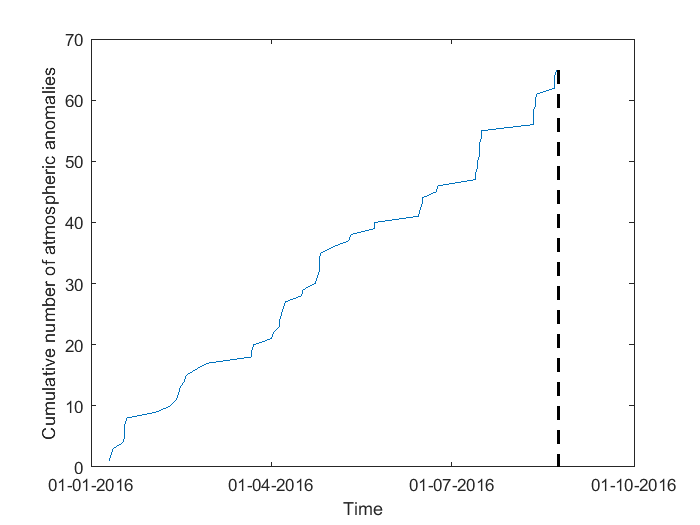

In [21]:
figure
atmospheric_anomalies = sortrows(atmospheric_anomalies,1);
cumulate_atmosphere = (1:size(atmospheric_anomalies, 1))';
plot(time_start-1+atmospheric_anomalies(:,1), cumulate_atmosphere)
line([EQ_time, EQ_time], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of atmospheric anomalies');

## Ionospheric analysis
In this session, the magnetic data from Swarm three-identical satellites are analysed.

Data must be downloaded from ESA's ftp dissemination service, which requires a free EO user account (you can create one here: https://eoiam-idp.eo.esa.int/) and placed in one folder of your computer were the VRE is running.

In the following example the data are inside the folder **ndir** = E:\Swarm_data  
The ESA Swarm file names appear as:  
SW_OPER_MAGA_LR_1B_20131125T110252_20131125T235959_0602_MDR_MAG_LR.cdf  
SW_OPER_MAGA_LR_1B_20201027T134456_20201027T150128_0605_MDR_MAG_LR.cdf  
...  
SW_OPER_MAGC_LR_1B_20140524T000000_20140524T235959_0602_MDR_MAG_LR.cdf


A full description of the method used for this analysis can be found in the following papers:
1. De Santis, A.; Balasis, G.; Pavón-Carrasco, F.J.; Cianchini, G.; Mandea, M. Potential earthquake precursory pattern from space: The 2015 Nepal event as seen by magnetic Swarm satellites. Earth Planet. Sci. Lett. 2017, 461, 119–126. <a href="http://doi.org/10.1016/j.epsl.2016.12.037"> doi:10.1016/j.epsl.2016.12.037</a>.
2. De Santis, A.; Marchetti, D.; Pavón-Carrasco, F.J.; Cianchini, G.; Perrone, L.; Abbattista, C.; Alfonsi, L.; Amoruso, L.; Campuzano, S.A.; Carbone, M.; et al. Precursory worldwide signatures of earthquake occurrences on Swarm satellite data. Sci. Rep. 2019, 9, 20287. <a href="http://doi.org/10.1038/s41598-019-56599-1">doi:10.1038/s41598-019-56599-1</a>.  
3. Marchetti, D.; De Santis, A.; Campuzano, S.A.; Zhu, K.; Soldani, M.; D’Arcangelo, S.; Orlando, M.; Wang, T.; Cianchini, G.; Di Mauro, D.; et al. Worldwide Statistical Correlation of Eight Years of Swarm Satellite Data with M5.5+ Earthquakes: New Hints about the Preseismic Phenomena from Space. Remote Sens. 2022, 14, 2649. <a href="https://doi.org/10.3390/rs14112649">doi:10.3390/rs14112649</a>.


The first part of the following code selects the data in the time range defined for the analysis of the earthquake.

Data are downloaded from ESA ftp dissemination service which requires a free EO user account (you can create one here: https://eoiam-idp.eo.esa.int/)

Credits for the password tool:   
Serge (2025). passwordtools (https://github.com/serg3y/MatLab-passwordtools/releases/tag/1.2.2), GitHub. Retrieved January 30, 2025.the passw

In [25]:
[EO_user, EO_pass] = uilogin(char(32:126),'Please insert your EO user and password (and after press ENTER):');


Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

In [26]:
f = ftp('swarm-diss.eo.esa.int', EO_user, EO_pass, TLSMode="strict");
file_serverFTP = dir(f)

Error connecting to MATLAB. Check the status of MATLAB by clicking the "Open MATLAB" button. Retry after ensuring MATLAB is running successfully

In [3]:
threshold = 4; %Threshold to identify Swarm magnetic anomalies
width_window = 3; %Lenght of the latitudinal window to search for anomalies

EQ_time = datenum([EQ_year, EQ_month, EQ_day, EQ_hour, EQ_minute, EQ_second]);
time_start = EQ_time - day_before;
time_end = EQ_time + day_after;

YYYY = EQ_year;
MM = EQ_month;
DD = EQ_day;
DB = day_before;
DA = day_after;

ndir = 'E:\dati_magnetici_swarm/';
files = dir([ndir, '*cdf.dat']);
files = {files.name}';

k=1;
newfiles={};
for i=1:size(files,1)
    a=files{i};
    t=datenum([str2double(a(20:23)),str2double(a(24:25)),str2double(a(26:27))]);
    if t>=time_start && t<=time_end
        newfiles(k,:)=files(i);
        k = k + 1;
    end
end


### Here we defined some functions that are necessary to properly exectute the code that processes the Swarm satellite magnetic data
The following cell defines a function called *"dat_order_alpha"* that permits to organise the satellite data from Swarm.  
In particular, it adds a column with a number corresponding to which satellite the data belongs (1=*Alpha*, 2=*Bravo*, 3=*Charlie*) and determines the semi-orbit number.  

In [1]:
function [yn]=dat_orden_alpha(x,SAT)
Mmlat=70;% maximum and minimum latitude (outside the polar areas)
if SAT=='A';sat=1;end
if SAT=='B';sat=2;end
if SAT=='C';sat=3;end
if SAT=='S';sat=4;end
%We add 2 new colums: SAT YYYY MM DD HH MM SS TRACK-NUMBER LAT LONG R X Y Z F
y=x(abs(x(:,7))<=Mmlat,:);
nn=size(y,1);
yn=zeros(nn-1,size(y,2)+2);
if nn>1
    k=1;m=1;
    while k<=nn-1
        yn(k,:)=[sat,y(k,1:6),m,y(k,7:end)];
        if abs(y(k,7)-y(k+1,7))>.5 || abs(y(k,8)-y(k+1,8))>1;
            m=m+1;
        end
        k=k+1;
    end
end
return

The following cell defines a function called *"geograph2geomag"* that permits to transform (i.e., rotate) the geographic coordinates of longitude and latitude in geomagnetic coordinates (i.e., geomagnetic latitude and longitude).  
The conversion is performed using the coordinates of the magnetic pole provided in the file `polos_igrf_swarm.dat` into the data folder.

In [2]:
function [mlat,mlong]=geograph2geomag(lat,long,time)
%lat, lon = geographic latitude and longitude
%time expressed in year. For example if you have 30/01/2016 time must be only 2016
format long
polo=load(fullfile("data", "polos_igrf_swarm.dat"));
fact=pi/180;
%latitude and longitude of magnetic pole in the year "time" (according to IGRF).
Dlat = polo(polo(:,1)==time,2)*fact; %latitude of geoamgentic pole
Dlong = (360+polo(polo(:,1)==time,3))*fact;%Geomagnetic longitude of the pole
%program
glong=long*fact;
glat=lat*fact;
x=cos(glat).*cos(glong);
y=cos(glat).*sin(glong);
z=sin(glat);
dato=[x,y,z];
%first rotation of the equator plane from the Greenwich meridian to the pole meridian.
M1=[cos(Dlong) sin(Dlong) 0;-sin(Dlong) cos(Dlong) 0;0 0 1];
S1=M1*dato';
%second rotation in the plane of the current meridian from the geographic pole to the magnetic pole.
M2=[cos(pi/2-Dlat) 0 -sin(pi/2-Dlat);0 1 0;sin(pi/2-Dlat) 0 cos(pi/2-Dlat)];
S2=M2*S1;
S2=S2';
%The last transformation
mlat=atan(S2(:,3)./sqrt(S2(:,1).^2+S2(:,2).^2));
mlat=mlat/fact;
mlong=atan(S2(:,2)./S2(:,1));
mlong=mlong/fact;
return

The following cell defines a function called *"geomagnetic_indexes"* that extracts the Dst and ap geomagnetic indexes at the time of interest  


In [3]:
function [dst,ap]=geomagnetic_indexes(z,a,b)
a1=a(a(:,1)==z(1) & a(:,2)==z(2) & a(:,3)==z(3),4:end);
b1=b(b(:,1)==z(1) & b(:,2)==z(2) & b(:,3)==z(3),4:end);
dst=a1(1, round(z(4))+1);
ap=b1(1, round(z(4))+1);
return

The following code extracts the Swarm magnetic data inside the Dobrovolsky's area and stores in struct variable **"tracks"** for further processing.  
Total number of extracted tracks is shown as i_tr

In [9]:
idst=load('dst_index2.dat');
iap=load('ap_index2.dat');
load('Solar_activity_SW_and_F_1min.mat');
radius_Dobrovolsky = 10.^(0.43*EQ_mag)/111;

tracks = {};
i_tr = 1;
for i=1:10%size(newfiles,1)
    a=newfiles{i};
    y=load(fullfile(ndir,newfiles{i}));%Read the .cdf.dat file.
    yn=dat_orden_alpha(y,a(12));% Include the number of track for each day
    y=yn( abs(yn(:,10)-epilon)<=(radius_Dobrovolsky+15),:);
    if size(y,1) > 50
        tracks{i_tr} = y;
        i_tr = i_tr + 1;
    end
end
i_tr


i_tr =     11

The following section calculated the magnetic residual along the tracks. The residual of the magnetic field in this case is the part of data that may contains eventual non ordinary signals, i.e. eventual earthquake induced signals.  

In [10]:
format compact
load("tracks.mat"); %this file provides the full set of files and not only the first 100
residuals = {};
i_res = 1;
for i=1:size(tracks,2)
    y = tracks{i};
    p1=y(1,8):y(end,8);
    for j=1:length(p1)
        z=y(y(:,8)==p1(j),:); %select the data of a specific track
        if size(z,1)>10 %if the track is longer than 10 data
            [dst,ap]=geomagnetic_indexes(z(1,2:5),idst,iap);
            z=sortrows(z,9);
            tt1=z(abs(z(:,9)-epilat)<radius_Dobrovolsky,5)+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,6)/60+z(abs(z(:,9)-epilat)<radius_Dobrovolsky,7)/3600;%UTC TIME in decimal hour for the track
            tt1_v=datevec(mean(tt1)/24);
            delta_solar_time = abs(solar_activity(:,1) - datenum([z(1,2:4), tt1_v(4:6)]));
            if delta_solar_time < 1/24
                [~, index_solar] = min(delta_solar_time);
                solar_condition = solar_activity(index_solar, 2);
            else
                solar_condition = -1;
            end
            z = z(z(:,13) <= 9 & z(:,14) <= 18 & z(:,15) <= 1, :);
            %The difference with A, B and C is not correct because in ASM burst mode for all the satellites, these parameters need to be considered
            if size(z,1)>1000
                latmag=geograph2geomag(z(:,9),z(:,10),z(1,2)); %geomagnetic latitude.
                D1=z(:,end-2);
                d=diff(D1);
                tt1s = z(:,5)*3600+z(:,6)*60+z(:,7);
                for tem=1:size(d, 1)
                    d(tem) = d(tem) / (tt1s(tem+1) - tt1s(tem));
                end
                latmag = latmag(1:end-1)/2 + latmag(2:end)/2;
                if size(d,1)>50
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 20/size(d,1));
                else
                    spline_fit = fit(latmag, d, 'smoothingspline', 'SmoothingParam', 10/size(d,1));
                end
                fitted_value = feval(spline_fit, latmag);
                val = d - fitted_value; % residual for further processing (e.g., researching anomalies).
                val = val(abs(latmag) <= 50);
                z = z(1:end-1,:)/2 + z(2:end,:)/2;
                z = z(abs(latmag) <= 50, :);
                latmag = latmag(abs(latmag) <= 50);
                residuals{i_res}.residual = val;
                residuals{i_res}.latmag = latmag;
                residuals{i_res}.track = z;
                residuals{i_res}.geomag_index = [dst, ap, solar_condition];
                i_res = i_res + 1;
            end
        end
    end
end
i_res

i_res =         2523

The following code plots 10 tracks selcted randomically among all the selected data.

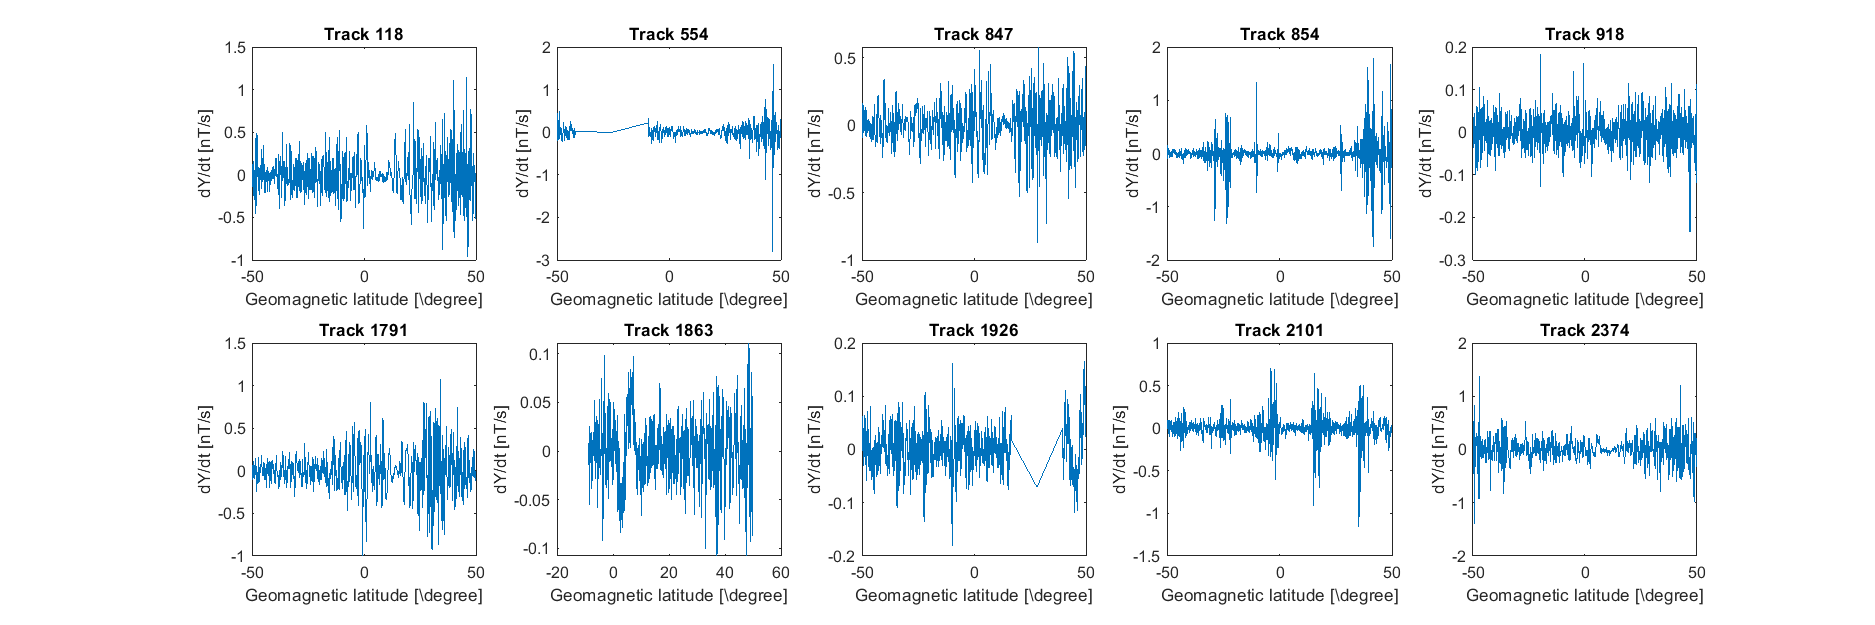

In [11]:
figure_index = fix(1+rand(10,1)*size(residuals,2));
figure_index = sortrows(figure_index);
figure('Position', [1, 1, 1500, 500])
for i=1:size(figure_index,1)
    latmag = residuals{figure_index(i)}.latmag;
    val = residuals{figure_index(i)}.residual;
    subplot(2,5,i)
    %plot(latmag, d);
    %hold on;
    %plot(latmag, fitted_value)
    %xlabel('Geoamgnetic latitude [\degree]', 'Interpreter', 'latex');
    %ylabel('dY/dt [nT/s]');
    %title('Numerical derivative of Y component');
    %subplot(2,1,2)
    plot(latmag, val)
    ylabel('dY/dt [nT/s]');
    xlabel('Geomagnetic latitude [\degree]', 'Interpreter', 'latex');
    title(['Track ', num2str(figure_index(i), '%d')]);
end

The following section extracted the anomalous magnetic signal from the previous selected tracs. 

In [12]:
max_dst = 20;
max_ap = 10;
anomalous_windows = {};
k_window = 1;
anomalous_track = nan(size(residuals,2), 9);
i_anom_track = 1;
for i=1:size(residuals,2)
    latmag = residuals{i}.latmag;
    val = residuals{i}.residual;
    z = residuals{i}.track;
    geomag_indexes = residuals{i}.geomag_index;
    track_threshold = threshold*nanstd(val);
    number_of_anomalous_windows = 0;
    geomag_lat_start = -50;
    geomag_lat_end = +50;
    step = width_window / 5;
    window_center = geomag_lat_start;
    while window_center <= geomag_lat_end
        window_rms = nanstd(val(abs(latmag - window_center) <= width_window / 2));
        if window_rms > track_threshold && abs(geomag_indexes(1)) <= max_dst && geomag_indexes(2) <= max_ap
            number_of_anomalous_windows = number_of_anomalous_windows + 1;
            anomalous_windows{k_window,1}.latmag = window_center;
            anomalous_windows{k_window,1}.latgeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 9));
            anomalous_windows{k_window,1}.longeo = nanmean(z(abs(latmag - window_center) <= width_window / 2, 10));
            anomalous_windows{k_window,1}.time = nanmean(datenum(z(abs(latmag - window_center) <= width_window / 2, 2:7)));
            k_window =  + 1;
        end
        window_center = window_center + step;
    end
    if number_of_anomalous_windows > 0
        [~, index_sample] = min(abs(epilat - z(:,9))); %search the closest latitudinal sample to the epicenter
        anomalous_track(i_anom_track,:) = [z(index_sample,2:7), z(1,1), z(index_sample,10), number_of_anomalous_windows];
        i_anom_track = i_anom_track + 1;
    end
end
i_anom_track
anomalous_track = anomalous_track(1:i_anom_track-1,:);
anomalous_track = sortrows(anomalous_track);

i_anom_track =    112

## Visualization of the cumulative number of Swarm magnetic tracks

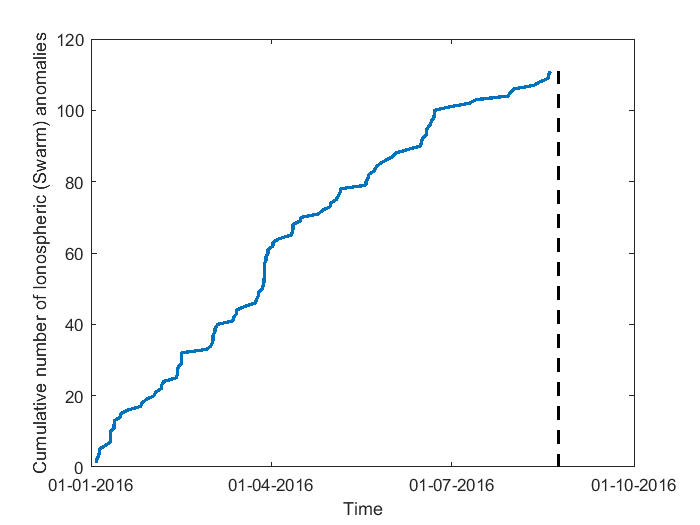

In [13]:
format compact
time_Swarm_anomalies = datenum(anomalous_track(:,1:6));
Cumulative_anomalies_Swarm = (1:size(anomalous_track,1))';
figure
plot(time_Swarm_anomalies, Cumulative_anomalies_Swarm, 'LineWidth', 2)
line([EQ_time, EQ_time], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
datetick('x', 'dd-mm-yyyy');
xlabel('Time');
ylabel('Cumulative number of Ionospheric (Swarm) anomalies');

# Comparison of Lithosphere Atmosphere and Ionosphere analyses 

A final comparison of the analysed parameters is provided by the follwing code.  
The approach has been used in different earhtquake investigations in the World, as Mw = 7.5 Indonesia 2018, Mw = 7.7 Jamaica 2020, Mw = 7.1 Haiti 2021 or recent Mw = 6.8 Morocco 2023 earthquakes.  
**References:**
1. Marchetti, D. Observation of the Preparation Phase Associated with Mw = 7.2 Haiti Earthquake on 14 August 2021 from a Geophysical Data Point of View. Geosciences 2024, 14, 96. https://doi.org/10.3390/geosciences14040096

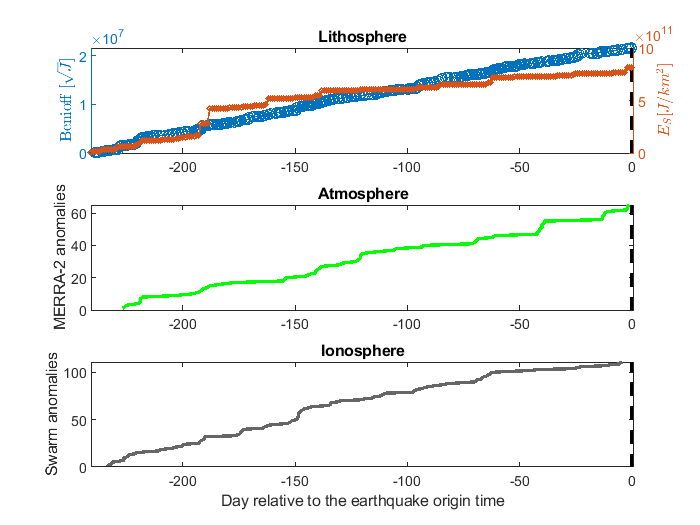

In [22]:
figure
subplot(3,1,1)
yyaxis left;
plot(time_EQ_sel - EQ_time, EQ_sqrt_energy, '-o');
line([0, 0], [0 EQ_sqrt_energy(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('Benioff [$\sqrt{J}$]', 'Interpreter', 'latex');
yyaxis right;
plot(cumulative_ES(:,1)- EQ_time, cumulative_ES(:,2), '-o', 'Linewidth', 1, 'MarkerSize', 2.5);
ylabel('$E_S [J/km^2]$', 'Interpreter', 'latex');
title(['Lithosphere']);
xlim([-day_before-1 day_after + 1]);
subplot(3,1,2)
plot(time_start-1+atmospheric_anomalies(:,1)-EQ_time, cumulate_atmosphere, 'g', 'LineWidth', 2)
line([0, 0], [0 cumulate_atmosphere(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
ylabel('MERRA-2 anomalies');
xlim([-day_before-1 day_after + 1]);
title('Atmosphere')
subplot(3,1,3)
plot(time_Swarm_anomalies-EQ_time, Cumulative_anomalies_Swarm, 'Color', [0.4 0.4 0.4], 'LineWidth', 2)
line([0, 0], [0 Cumulative_anomalies_Swarm(end)], 'LineStyle', '--', 'LineWidth', 2, 'Color', 'k');
xlabel('Day relative to the earthquake origin time');
ylabel('Swarm anomalies');
title('Ionosphere')
xlim([-day_before-1 day_after + 1]);
